# Importing libraries

In [110]:
import torch
import torchvision
import os
import numpy as np
import argparse
import time
import pdb
import sys
import torch.multiprocessing
import json
import lmdb
import random
import pickle
import ast
import pandas as pd

from torch import nn
from tqdm import tqdm
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
from io import BytesIO
from types import SimpleNamespace
from glob import glob
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.manifold import TSNE

# Dataset

In [2]:
class EmbeddingDataset(Dataset):
    def __init__(self, image_path, text_path, part=None):
        embeddings = self.read_pickle(image_path)
        self.image_embeddings = torch.tensor(embeddings[0])
        if part == 'all':
            self.text_embeddings = torch.tensor(embeddings[1])
        else:
            text_embeddings = self.read_pickle(text_path)
            self.text_embeddings = torch.tensor(text_embeddings[0])
            

    def __getitem__(self, idx):
        return (self.image_embeddings[idx], self.text_embeddings[idx])

    def __len__(self):
        return len(self.image_embeddings)

    def read_pickle(self, fpath):
        objects = []
        with (open(fpath, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break
        if len(objects) == 1:
            return objects[0]
        return objects


# Model

In [3]:
class Embedder(nn.Module):
    def __init__(self, output_size, input_size=1024):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.layer1(x)
        return self.layer2(x)

# Loss

In [15]:
class TripletLoss:
    def __init__(self, margin=None):
        self.margin = margin
        if margin is not None:
            self.ranking_loss = nn.MarginRankingLoss(margin=margin)
        else:
            self.ranking_loss = nn.SoftMarginLoss()

    def __call__(self, dist_ap, dist_an):
        y = torch.ones_like(dist_ap)
        if self.margin is not None:
            loss = self.ranking_loss(dist_an, dist_ap, y)
        else:
            loss = self.ranking_loss(dist_an - dist_ap, y)
        return loss


def normalize(x, axis=-1):
    x = 1. * x / (torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12)
    return x

def euclidean_dist(x, y):
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(x, y.t(), beta=1, alpha=-2)
    dist = dist.clamp(min=1e-12).sqrt()
    return dist

def hard_example_mining(dist_mat, labels, return_inds=False):
    N = dist_mat.size(0)
    is_pos = labels.expand(N, N).eq(labels.expand(N, N).t())
    is_neg = labels.expand(N, N).ne(labels.expand(N, N).t())
    dist_ap, relative_p_inds = torch.max(
    dist_mat[is_pos].contiguous().view(N, -1), 1, keepdim=True)
    dist_an, relative_n_inds = torch.min(dist_mat[is_neg].contiguous().view(N, -1), 1, keepdim=True)
    dist_ap = dist_ap.squeeze(1)
    dist_an = dist_an.squeeze(1)
    return dist_ap, dist_an

def triplet_loss_fn(tri_loss, global_feat, labels, normalize_feature=False):
    if normalize_feature:
        global_feat = normalize(global_feat, axis=-1)
    dist_mat = euclidean_dist(global_feat, global_feat)
    dist_ap, dist_an = hard_example_mining(dist_mat, labels, return_inds=False)
    loss = tri_loss(dist_ap, dist_an)
    return loss, dist_ap, dist_an, dist_mat

# Helper functions

In [29]:
def compute_ranks(rcps, imgs, retrieved_type='recipe'):
    imgs = imgs / np.linalg.norm(imgs, axis=1)[:, None]
    rcps = rcps / np.linalg.norm(rcps, axis=1)[:, None]
    if retrieved_type == 'recipe':
        sims = np.dot(imgs, rcps.T) # [N, N]
    else:
        sims = np.dot(rcps, imgs.T)
    
    ranks = []
    preds = []
    for ii in range(imgs.shape[0]):
        sim = sims[ii,:]
        sorting = np.argsort(sim)[::-1].tolist()
        pos = sorting.index(ii)
        ranks.append(pos+1.0)
        preds.append(sorting[0])
    return np.asarray(ranks), preds

def pickler(file_, path, mode='ab'):
    dbfile_paths = open(path, mode) 
    pickle.dump(file_, dbfile_paths)                      
    dbfile_paths.close()

def rank(rcps, imgs, retrieved_type='recipe', retrieved_range=1000, draw_hist=False, verbose=False, epoch=-1):
    t1 = time.time()
    N = retrieved_range
    data_size = imgs.shape[0]
    glob_rank = []
    glob_recall = {1:0.0, 5:0.0, 10:0.0}
    pickler(imgs, 'image_outputs.pkl')
    pickler(rcps, 'recipe_outputs.pkl')
    if draw_hist:
        plt.figure(figsize=(16, 6))
    for i in range(10):
        ids_sub = np.random.choice(data_size, N, replace=False)
        imgs_sub = imgs[ids_sub, :]
        rcps_sub = rcps[ids_sub, :]
        ranks, _ = compute_ranks(rcps_sub, imgs_sub, retrieved_type)
        pickler(ranks, 'ranks.pkl')
        pickler(ids_sub, 'indices.pkl')
        recall = {1:0.0, 5:0.0, 10:0.0}
        for ii in recall.keys():
            recall[ii] = (ranks<=ii).sum() / ranks.shape[0]
        med = int(np.median(ranks))
        for ii in recall.keys():
            glob_recall[ii] += recall[ii]
        glob_rank.append(med)
        if draw_hist:
            ranks = np.array(ranks)
            plt.subplot(2,5,i+1)
            n, bins, patches = plt.hist(x=ranks, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
            plt.grid(axis='y', alpha=0.75)
            plt.ylim(top=300)
            plt.text(23, 45, 'avgR(std) = {:.2f}({:.2f})\nmedR={:.2f}\n#<{:d}:{:d}|#={:d}:{:d}|#>{:d}:{:d}'.format(
                np.mean(ranks), np.std(ranks), np.median(ranks), 
                med,(ranks<med).sum(), med,(ranks==med).sum(), med,(ranks>med).sum()))
    if draw_hist:
        plt.savefig(f'hist_{epoch}.png')
    
    for i in glob_recall.keys():
        glob_recall[i] = glob_recall[i]/10

    medR = np.mean(glob_rank)
    medR_std = np.std(glob_rank)
    t2 = time.time()
    if verbose:
        print(f'=>retrieved_range={retrieved_range}, MedR={medR:.4f}({medR_std:.4f}), time={t2-t1:.4f}s')
    return medR, medR_std, glob_recall

def create_retrieval_model(args, device='cuda', image_encoder='resnet'):
    txt_encoder = Embedder(args.latent_size).to(device)
    img_encoder = Embedder(args.latent_size).to(device)
    optimizer = torch.optim.Adam(
        [
            {'params': txt_encoder.parameters()},
            {'params': img_encoder.parameters()},
        ], 
        lr=args.lr
    )
    return txt_encoder, img_encoder, optimizer

def load_retrieval_model(ckpt_path, device='cuda', image_encoder='resnet'):
    print(f'load retrieval model from {ckpt_path}')
    ckpt = torch.load(ckpt_path)
    
    ckpt_args = ckpt['args']
    if 'lr' not in ckpt_args.__dict__:
        ckpt_args.lr = 0.0001

    txt_encoder, img_encoder, optimizer = create_retrieval_model(ckpt_args, device, image_encoder)
    epoch_start = ckpt['epoch']+1
    txt_encoder.load_state_dict(ckpt['txt_encoder'])
    img_encoder.load_state_dict(ckpt['img_encoder'])
    optimizer.load_state_dict(ckpt['optimizer'])
    
    return ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer

def save_retrieval_model(args, txt_module, img_module, optimizer, epoch, ckpt_path):
    print(f'save retrieval model to {ckpt_path}')
    ckpt = {
        'args': args,
        'epoch': epoch,
        'txt_encoder': txt_module.state_dict(),
        'img_encoder': img_module.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(ckpt, ckpt_path)

def train_triplet_loss(
    args, train_loader, val_loader, 
    txt_encoder, img_encoder, optimizer, 
    n_train, n_val):
    
    save_dir = args.save_dir
    device = args.device
    if device == 'cuda':
        txt_module = txt_encoder.module
        img_module = img_encoder.module
    else:
        txt_module = txt_encoder
        img_module = img_encoder
    
    ckpt_path = os.path.join(save_dir, f'model.pt')
    triplet_loss = TripletLoss(args.margin)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)
    min_val_loss = float('inf')
    for epoch in range(args.epochs):
        time.sleep(0.5)
        txt_encoder.train()
        img_encoder.train()
        train_loss = 0.0
        time.sleep(0.5)
        iteration = 1
        for img, txt in train_loader:
            txt_output = txt_encoder(txt.to(device))
            img_output = img_encoder(img.to(device))

            bs = img.shape[0]
            label = list(range(0, bs))
            label.extend(label)
            label = np.array(label)
            label = torch.tensor(label).long().to(device)
            loss = triplet_loss_fn(triplet_loss, torch.cat((img_output, txt_output)), label)[0]
            train_loss += loss.item() * bs
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iteration += 1

        train_loss /= n_train
        
        time.sleep(0.5)
        txt_encoder.eval()
        img_encoder.eval()
        txt_outputs = []
        img_outputs = []
        val_loss = 0.0

        time.sleep(0.5)
        with torch.no_grad():
            iteration = 0
            for txt, img in val_loader:

                txt_output = txt_encoder(txt.to(device))
                img_output = img_encoder(img.to(device))

                txt_outputs.append(txt_output.detach().cpu())
                img_outputs.append(img_output.detach().cpu())

                bs = img.shape[0]
                label = list(range(0, bs))
                label.extend(label)
                label = np.array(label)
                label = torch.tensor(label).long().to(device)
                loss = triplet_loss_fn(triplet_loss, torch.cat((img_output, txt_output)), label)[0]
                val_loss += loss.item() * bs

                iteration += 1

        val_loss /= n_val
        txt_outputs = torch.cat(txt_outputs, dim=0).numpy()
        img_outputs = torch.cat(img_outputs, dim=0).numpy()
        retrieved_range = min(txt_outputs.shape[0], args.retrieved_range)
        medR, medR_std, recalls = rank(
            txt_outputs, img_outputs, epoch=epoch, retrieved_type=args.retrieved_type, 
            retrieved_range=retrieved_range, verbose=True)

        ckpt_path = os.path.join(save_dir, f'model.pt')
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print(f'save to {ckpt_path}')
            ckpt = {
                'args': args,
                'epoch': epoch,
                'txt_encoder': txt_module.state_dict(),
                'img_encoder': img_module.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': val_loss
            }
            torch.save(ckpt, ckpt_path)

        log = {
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'medR': medR,
            'medR_std': medR_std
        }
        for k, v in recalls.items():
            log["Recall"+str(k)] = v

        print(log)
        with open(os.path.join(save_dir, 'metrics.txt'), 'a') as f:
            f.write('\n' + str(log) + '\n')
        scheduler.step(recalls[1])

def train_mse(
    args, train_loader, val_loader, 
    txt_encoder, img_encoder, optimizer, 
    n_train, n_val):
    
    save_dir = args.save_dir
    device = args.device
    if device == 'cuda':
        txt_module = txt_encoder.module
        img_module = img_encoder.module
    else:
        txt_module = txt_encoder
        img_module = img_encoder
    
    ckpt_path = os.path.join(save_dir, f'model.pt')
    mse_loss = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)
    min_val_loss = float('inf')
    for epoch in range(args.epochs):
        time.sleep(0.5)
        txt_encoder.train()
        img_encoder.train()
        train_loss = 0.0
        time.sleep(0.5)
        for img, txt in train_loader:
            txt_output = txt_encoder(txt.to(device))
            img_output = img_encoder(img.to(device))
            bs = img.shape[0]
            loss = mse_loss(img_output, txt_output)
            train_loss += loss.item() * bs
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= n_train
        
        time.sleep(0.5)
        txt_encoder.eval()
        img_encoder.eval()
        txt_outputs = []
        img_outputs = []
        val_loss = 0.0

        time.sleep(0.5)
        with torch.no_grad():
            for txt, img in val_loader:
                txt_output = txt_encoder(txt.to(device))
                img_output = img_encoder(img.to(device))

                txt_outputs.append(txt_output.detach().cpu())
                img_outputs.append(img_output.detach().cpu())
                bs = img.shape[0]
                loss = mse_loss(img_output, txt_output)
                val_loss += loss.item() * bs

        val_loss /= n_val
        txt_outputs = torch.cat(txt_outputs, dim=0).numpy()
        img_outputs = torch.cat(img_outputs, dim=0).numpy()
        retrieved_range = min(txt_outputs.shape[0], args.retrieved_range)
        medR, medR_std, recalls = rank(
            txt_outputs, img_outputs, epoch=epoch, retrieved_type=args.retrieved_type, 
            retrieved_range=retrieved_range, verbose=True)

        ckpt_path = os.path.join(save_dir, f'model.pt')
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print(f'save to {ckpt_path}')
            ckpt = {
                'args': args,
                'epoch': epoch,
                'txt_encoder': txt_module.state_dict(),
                'img_encoder': img_module.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': val_loss
            }
            torch.save(ckpt, ckpt_path)

        log = {
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'medR': medR,
            'medR_std': medR_std
        }
        for k, v in recalls.items():
            log["Recall"+str(k)] = v

        print(log)
        with open(os.path.join(save_dir, 'metrics.txt'), 'a') as f:
            f.write('\n' + str(log) + '\n')
        scheduler.step(recalls[1])

# Setting parameters

In [26]:
args = SimpleNamespace(
    device='cuda:7',
    seed=8,
    epochs=30,
    lr=0.0001,
    margin=0.3,
    retrieved_type='image',
    retrieved_range=1000,
    latent_size=256
)
   
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.benchmark = True
device = args.device
image_pkl_path='/common/home/as3503/as3503/courses/cs536/dataset/prof_embeddings/embeddings_train1.pkl'
text_pkl_path='/common/home/as3503/as3503/courses/cs536/dataset/prof_embeddings/#replace#_embeddings_train.pkl'
batch_size=1024
parts = ['all', 'title', 'ingredients', 'instructions']
latent_sizes = [64, 128, 256]

# Training triplet loss (with ablation study)

In [47]:
for part in parts:    
    train_set = EmbeddingDataset(image_path=image_pkl_path, text_path=text_pkl_path.replace('#replace#', part), part=part)
    val_set = EmbeddingDataset(image_path=image_pkl_path.replace('train', 'val'), text_path=text_pkl_path.replace('#replace#', part).replace('train', 'val'), part=part)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

    for latent_size in latent_sizes:
        args.latent_size = latent_size
        args.save_dir = f'notebook_latent_{latent_size}_{part}'
        ckpt_path = os.path.join(args.save_dir, 'model.pt')

        if os.path.exists(ckpt_path):
            print('Loading model')
            ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer = load_retrieval_model(ckpt_path, device)
        else:
            print('Creating model')
            txt_encoder, img_encoder, optimizer = create_retrieval_model(args, device)

        if device == 'cuda':
            txt_encoder = nn.DataParallel(txt_encoder)
            img_encoder = nn.DataParallel(img_encoder)

        os.makedirs(args.save_dir, exist_ok=True)
        to_print = ['Now training', f'Latent size: {latent_size}', f'text part: {part}']
        print('\n'.join(to_print))
        train_triplet_loss(args, train_loader, val_loader, txt_encoder, img_encoder, optimizer, len(train_set), len(val_set))

    # Making space    
    for fpath in glob('./*.pkl'):
        os.remove(fpath)


Creating model
Now training
Latent size: 64
text part: all
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 14.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.11it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.4837s
save to notebook_latent_64_all/model.pt
{'epoch': 0, 'train_loss': 1.1231496344684613, 'val_loss': 0.774420966860878, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.579, 'Recall5': 0.8280000000000001, 'Recall10': 0.8897}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.55it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2425s
save to notebook_latent_64_all/model.pt
{'epoch': 1, 'train_loss': 0.6670835313651777, 'val_loss': 0.7710723467843227, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.592, 'Recall5': 0.8391, 'Recall10': 0.8968}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.02it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3609s
save to notebook_latent_64_all/model.pt
{'epoch': 2, 'train_loss': 0.586988301840835, 'val_loss': 0.7524685176094154, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5944, 'Recall5': 0.8469, 'Recall10': 0.8997999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:20<00:00, 13.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.34it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8874s
save to notebook_latent_64_all/model.pt
{'epoch': 3, 'train_loss': 0.5413296573196741, 'val_loss': 0.7289846396991551, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5983999999999999, 'Recall5': 0.8462, 'Recall10': 0.9026}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.39it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1154s
save to notebook_latent_64_all/model.pt
{'epoch': 4, 'train_loss': 0.508035314316863, 'val_loss': 0.7033208656569886, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6005, 'Recall5': 0.8532, 'Recall10': 0.9062000000000001}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.18it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1786s
save to notebook_latent_64_all/model.pt
{'epoch': 5, 'train_loss': 0.480864906417249, 'val_loss': 0.6785181043069991, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.604, 'Recall5': 0.8474999999999999, 'Recall10': 0.9020000000000001}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 14.39it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.66it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8451s
save to notebook_latent_64_all/model.pt
{'epoch': 6, 'train_loss': 0.45771120556874095, 'val_loss': 0.6518712614022262, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6016999999999999, 'Recall5': 0.8516, 'Recall10': 0.9067999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 14.52it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.72it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0934s
save to notebook_latent_64_all/model.pt
{'epoch': 7, 'train_loss': 0.43710457306814, 'val_loss': 0.6262683427099841, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6053999999999999, 'Recall5': 0.8498999999999999, 'Recall10': 0.9043000000000001}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.04it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7966s
save to notebook_latent_64_all/model.pt
{'epoch': 8, 'train_loss': 0.41797545402119224, 'val_loss': 0.6054530310885703, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6009, 'Recall5': 0.8523999999999999, 'Recall10': 0.9074000000000002}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.17it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1577s
save to notebook_latent_64_all/model.pt
{'epoch': 9, 'train_loss': 0.40085488871440655, 'val_loss': 0.5833805136377401, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6109000000000001, 'Recall5': 0.8575999999999999, 'Recall10': 0.9104000000000001}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 15.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.84it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.0308s
save to notebook_latent_64_all/model.pt
{'epoch': 10, 'train_loss': 0.38534480147782074, 'val_loss': 0.5628428270238257, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6041, 'Recall5': 0.8493, 'Recall10': 0.9041000000000002}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.35it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0753s
save to notebook_latent_64_all/model.pt
{'epoch': 11, 'train_loss': 0.372572509795839, 'val_loss': 0.5435631599134589, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6049999999999999, 'Recall5': 0.8524999999999998, 'Recall10': 0.9088}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:20<00:00, 13.38it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.59it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1244s
save to notebook_latent_64_all/model.pt
{'epoch': 12, 'train_loss': 0.35988055969901056, 'val_loss': 0.525323315310086, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6001, 'Recall5': 0.8523, 'Recall10': 0.9111}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:20<00:00, 13.52it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.33it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=23.5269s
save to notebook_latent_64_all/model.pt
{'epoch': 13, 'train_loss': 0.34851553619497627, 'val_loss': 0.5085759152327847, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6047, 'Recall5': 0.8534999999999998, 'Recall10': 0.9085000000000001}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:20<00:00, 13.66it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.35it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=15.5309s
save to notebook_latent_64_all/model.pt
{'epoch': 14, 'train_loss': 0.33897022606030286, 'val_loss': 0.5030757468047649, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6075999999999999, 'Recall5': 0.8606999999999999, 'Recall10': 0.9097000000000002}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.95it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=18.6605s
save to notebook_latent_64_all/model.pt
{'epoch': 15, 'train_loss': 0.33572285099898524, 'val_loss': 0.5006522125964377, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6098999999999999, 'Recall5': 0.8587999999999999, 'Recall10': 0.913}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:20<00:00, 13.37it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.55it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=21.6587s
save to notebook_latent_64_all/model.pt
{'epoch': 16, 'train_loss': 0.33381328592229365, 'val_loss': 0.49847465192647, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6152, 'Recall5': 0.8523, 'Recall10': 0.9051}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 13.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.54it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=19.3269s
save to notebook_latent_64_all/model.pt
{'epoch': 17, 'train_loss': 0.3319400112541595, 'val_loss': 0.4964450597407931, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6088, 'Recall5': 0.8563000000000001, 'Recall10': 0.909}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:20<00:00, 13.71it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.28it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=6.4819s
save to notebook_latent_64_all/model.pt
{'epoch': 18, 'train_loss': 0.3303368091367353, 'val_loss': 0.49469142783888087, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6057, 'Recall5': 0.8555999999999999, 'Recall10': 0.9082000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.25it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3233s
save to notebook_latent_64_all/model.pt
{'epoch': 19, 'train_loss': 0.32776338573084607, 'val_loss': 0.4924121094154059, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6000000000000001, 'Recall5': 0.8527000000000001, 'Recall10': 0.9034000000000001}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.63it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8926s
save to notebook_latent_64_all/model.pt
{'epoch': 20, 'train_loss': 0.32743724508968236, 'val_loss': 0.4907866183097824, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6011, 'Recall5': 0.8537000000000001, 'Recall10': 0.9041}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.38it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.63it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.7758s
save to notebook_latent_64_all/model.pt
{'epoch': 21, 'train_loss': 0.32616865784121385, 'val_loss': 0.4905088609729085, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6065, 'Recall5': 0.8509999999999998, 'Recall10': 0.9062000000000001}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2889s
save to notebook_latent_64_all/model.pt
{'epoch': 22, 'train_loss': 0.325767908669318, 'val_loss': 0.4902016290356136, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6091, 'Recall5': 0.8586, 'Recall10': 0.9088}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:20<00:00, 13.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1761s
save to notebook_latent_64_all/model.pt
{'epoch': 23, 'train_loss': 0.32462620931128583, 'val_loss': 0.49015575266378425, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6094, 'Recall5': 0.8554, 'Recall10': 0.9093}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.48it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4633s
save to notebook_latent_64_all/model.pt
{'epoch': 24, 'train_loss': 0.3256114639978363, 'val_loss': 0.489860178338298, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6090000000000001, 'Recall5': 0.8539, 'Recall10': 0.9061999999999999}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.71it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.9897s
save to notebook_latent_64_all/model.pt
{'epoch': 25, 'train_loss': 0.3248923270648802, 'val_loss': 0.48979463893257397, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6066, 'Recall5': 0.8561, 'Recall10': 0.9093}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.51it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7734s
{'epoch': 26, 'train_loss': 0.32581280462392975, 'val_loss': 0.4899712668279326, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6098, 'Recall5': 0.8549999999999999, 'Recall10': 0.9101000000000001}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.72it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2267s
{'epoch': 27, 'train_loss': 0.32543914326267714, 'val_loss': 0.4899865195561077, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6037, 'Recall5': 0.8491, 'Recall10': 0.9052}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.35it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.06it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2666s
{'epoch': 28, 'train_loss': 0.32540059460075665, 'val_loss': 0.4898519895743686, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6048000000000001, 'Recall5': 0.8519999999999998, 'Recall10': 0.9084999999999999}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.36it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3456s
{'epoch': 29, 'train_loss': 0.3253788094713896, 'val_loss': 0.4898327381757421, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6012, 'Recall5': 0.8503999999999999, 'Recall10': 0.9089}
Creating model
Now training
Latent size: 128
text part: all
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 14.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.08it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3680s
save to notebook_latent_128_all/model.pt
{'epoch': 0, 'train_loss': 1.1194318088356805, 'val_loss': 0.7796951247983583, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5820000000000001, 'Recall5': 0.8341, 'Recall10': 0.891}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.30it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.68it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.3299s
save to notebook_latent_128_all/model.pt
{'epoch': 1, 'train_loss': 0.6665731076049559, 'val_loss': 0.7740074618089748, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5891, 'Recall5': 0.8373999999999999, 'Recall10': 0.8924}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:20<00:00, 13.36it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.15it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=18.2707s
save to notebook_latent_128_all/model.pt
{'epoch': 2, 'train_loss': 0.5866366438816081, 'val_loss': 0.753974464277356, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5963, 'Recall5': 0.8413999999999999, 'Recall10': 0.8986000000000001}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:20<00:00, 13.53it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.80it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=20.2374s
save to notebook_latent_128_all/model.pt
{'epoch': 3, 'train_loss': 0.5408361098874005, 'val_loss': 0.7289002458829281, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.597, 'Recall5': 0.8456999999999999, 'Recall10': 0.9013000000000002}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:20<00:00, 13.74it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.09it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=18.4888s
save to notebook_latent_128_all/model.pt
{'epoch': 4, 'train_loss': 0.5079807538953321, 'val_loss': 0.7041822298806338, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5964, 'Recall5': 0.8481, 'Recall10': 0.9048}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.34it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=15.8200s
save to notebook_latent_128_all/model.pt
{'epoch': 5, 'train_loss': 0.48166075571716904, 'val_loss': 0.6786978156788143, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6002, 'Recall5': 0.8564999999999999, 'Recall10': 0.9048}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 14.25it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.85it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=21.2552s
save to notebook_latent_128_all/model.pt
{'epoch': 6, 'train_loss': 0.45790464726178254, 'val_loss': 0.6540972142173613, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6031, 'Recall5': 0.8521000000000003, 'Recall10': 0.9027000000000001}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.36it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.58it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=18.7043s
save to notebook_latent_128_all/model.pt
{'epoch': 7, 'train_loss': 0.4379884131031416, 'val_loss': 0.6296638568823753, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6073999999999999, 'Recall5': 0.8533, 'Recall10': 0.9055}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.40it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.98it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.6699s
save to notebook_latent_128_all/model.pt
{'epoch': 8, 'train_loss': 0.41888549669432257, 'val_loss': 0.6066744776824227, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6079, 'Recall5': 0.8516999999999999, 'Recall10': 0.9105000000000001}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.35it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.01it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7024s
save to notebook_latent_128_all/model.pt
{'epoch': 9, 'train_loss': 0.40186010272464173, 'val_loss': 0.5838891978549695, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6005, 'Recall5': 0.8468, 'Recall10': 0.9007999999999999}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 14.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.69it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8838s
save to notebook_latent_128_all/model.pt
{'epoch': 10, 'train_loss': 0.3869284321415926, 'val_loss': 0.5625971691566839, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.603, 'Recall5': 0.8533999999999999, 'Recall10': 0.9071000000000001}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.53it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4112s
save to notebook_latent_128_all/model.pt
{'epoch': 11, 'train_loss': 0.37203768586300306, 'val_loss': 0.5440096316470641, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5997, 'Recall5': 0.8494999999999999, 'Recall10': 0.9021000000000001}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 14.63it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.90it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6518s
save to notebook_latent_128_all/model.pt
{'epoch': 12, 'train_loss': 0.3598555314724928, 'val_loss': 0.5256059627729307, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6022, 'Recall5': 0.8533999999999999, 'Recall10': 0.9074}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 15.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.74it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7689s
save to notebook_latent_128_all/model.pt
{'epoch': 13, 'train_loss': 0.3496436820543612, 'val_loss': 0.5205173876919184, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6093999999999999, 'Recall5': 0.857, 'Recall10': 0.9080999999999999}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 14.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.89it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6757s
save to notebook_latent_128_all/model.pt
{'epoch': 14, 'train_loss': 0.3461246145952332, 'val_loss': 0.5176255049769745, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6134, 'Recall5': 0.8565999999999999, 'Recall10': 0.9073}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:18<00:00, 14.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.04it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.8191s
save to notebook_latent_128_all/model.pt
{'epoch': 15, 'train_loss': 0.34426754799989584, 'val_loss': 0.5156649205398269, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6055, 'Recall5': 0.8543, 'Recall10': 0.9067999999999999}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:20<00:00, 13.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.66it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0653s
save to notebook_latent_128_all/model.pt
{'epoch': 16, 'train_loss': 0.3420472394846122, 'val_loss': 0.5136747751346131, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6121000000000001, 'Recall5': 0.8547, 'Recall10': 0.906}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.25it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.00it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0890s
save to notebook_latent_128_all/model.pt
{'epoch': 17, 'train_loss': 0.34033173280153967, 'val_loss': 0.5109623007471151, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6037000000000001, 'Recall5': 0.8544, 'Recall10': 0.9058000000000002}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.72it/s]


val


100%|██████████| 60/60 [00:01<00:00, 45.75it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.1215s
save to notebook_latent_128_all/model.pt
{'epoch': 18, 'train_loss': 0.33824441157897506, 'val_loss': 0.5094271729267175, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6084, 'Recall5': 0.8495999999999999, 'Recall10': 0.9037000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.07it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2166s
save to notebook_latent_128_all/model.pt
{'epoch': 19, 'train_loss': 0.33740106634883243, 'val_loss': 0.5089027288870686, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6098999999999999, 'Recall5': 0.8583000000000001, 'Recall10': 0.9113}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.43it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.23it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8685s
save to notebook_latent_128_all/model.pt
{'epoch': 20, 'train_loss': 0.33843651129946806, 'val_loss': 0.5086179192026496, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6007, 'Recall5': 0.8502999999999998, 'Recall10': 0.9065000000000001}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 14.63it/s]


val


100%|██████████| 60/60 [00:01<00:00, 30.78it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1775s
save to notebook_latent_128_all/model.pt
{'epoch': 21, 'train_loss': 0.3376608840776552, 'val_loss': 0.5085714973509559, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5982, 'Recall5': 0.8499000000000001, 'Recall10': 0.9049000000000001}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.44it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=24.4956s
save to notebook_latent_128_all/model.pt
{'epoch': 22, 'train_loss': 0.3370235913892826, 'val_loss': 0.5081356963146637, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6065, 'Recall5': 0.8487, 'Recall10': 0.9065000000000001}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.71it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=20.2671s
{'epoch': 23, 'train_loss': 0.3372979185008592, 'val_loss': 0.5083789207355208, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6039, 'Recall5': 0.8517999999999999, 'Recall10': 0.9055000000000002}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.28it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.38it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=15.6751s
{'epoch': 24, 'train_loss': 0.336917855839559, 'val_loss': 0.5083405810771532, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6101, 'Recall5': 0.8565999999999999, 'Recall10': 0.9078000000000002}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.99it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=27.7983s
save to notebook_latent_128_all/model.pt
{'epoch': 25, 'train_loss': 0.3368751300929887, 'val_loss': 0.507965845501548, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6044999999999999, 'Recall5': 0.8528, 'Recall10': 0.9053000000000001}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.43it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.46it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=15.8628s
save to notebook_latent_128_all/model.pt
{'epoch': 26, 'train_loss': 0.33760373269239347, 'val_loss': 0.5079314550163848, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6089, 'Recall5': 0.8584000000000002, 'Recall10': 0.9086000000000002}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 15.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.74it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2763s
{'epoch': 27, 'train_loss': 0.3376840363578438, 'val_loss': 0.5083187623876457, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6077, 'Recall5': 0.8579000000000001, 'Recall10': 0.9092}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.27it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.44it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4610s
save to notebook_latent_128_all/model.pt
{'epoch': 28, 'train_loss': 0.3374538987394292, 'val_loss': 0.5078709724110346, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6145000000000002, 'Recall5': 0.86, 'Recall10': 0.9095000000000001}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.36it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.23it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.3386s
{'epoch': 29, 'train_loss': 0.33679352523027506, 'val_loss': 0.5082499884883546, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6115, 'Recall5': 0.8529, 'Recall10': 0.9081000000000001}
Creating model
Now training
Latent size: 256
text part: all
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.07it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7371s
save to notebook_latent_256_all/model.pt
{'epoch': 0, 'train_loss': 1.134041480809313, 'val_loss': 0.7821482225001215, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5745, 'Recall5': 0.8255000000000001, 'Recall10': 0.8875}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.23it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2410s
save to notebook_latent_256_all/model.pt
{'epoch': 1, 'train_loss': 0.6696939444211564, 'val_loss': 0.7751170011883218, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5864999999999999, 'Recall5': 0.8384, 'Recall10': 0.8956000000000002}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:18<00:00, 14.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.78it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4171s
save to notebook_latent_256_all/model.pt
{'epoch': 2, 'train_loss': 0.5876537439632634, 'val_loss': 0.7554380705961818, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5978, 'Recall5': 0.8504999999999999, 'Recall10': 0.9048999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.32it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.02it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.9412s
save to notebook_latent_256_all/model.pt
{'epoch': 3, 'train_loss': 0.5439119027925309, 'val_loss': 0.7314348524185236, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6068, 'Recall5': 0.8521000000000001, 'Recall10': 0.9048999999999999}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:18<00:00, 15.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 45.86it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1976s
save to notebook_latent_256_all/model.pt
{'epoch': 4, 'train_loss': 0.5092679001990212, 'val_loss': 0.7052204114023685, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5968, 'Recall5': 0.8444999999999998, 'Recall10': 0.8992000000000001}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.17it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1334s
save to notebook_latent_256_all/model.pt
{'epoch': 5, 'train_loss': 0.4815283489164303, 'val_loss': 0.6820383646736702, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5957, 'Recall5': 0.8515, 'Recall10': 0.9036000000000002}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.97it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2704s
save to notebook_latent_256_all/model.pt
{'epoch': 6, 'train_loss': 0.4588903739368644, 'val_loss': 0.6542104184617669, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5988, 'Recall5': 0.8472999999999999, 'Recall10': 0.9022}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 15.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.80it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.7771s
save to notebook_latent_256_all/model.pt
{'epoch': 7, 'train_loss': 0.4385531837361911, 'val_loss': 0.6318578930645475, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6003000000000001, 'Recall5': 0.8486, 'Recall10': 0.9044000000000001}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.23it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.02it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2258s
save to notebook_latent_256_all/model.pt
{'epoch': 8, 'train_loss': 0.4234603942166596, 'val_loss': 0.6245118965360299, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6004, 'Recall5': 0.8511000000000001, 'Recall10': 0.9057999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 15.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.29it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.5020s
save to notebook_latent_256_all/model.pt
{'epoch': 9, 'train_loss': 0.41885272740309376, 'val_loss': 0.620630734569207, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6101999999999999, 'Recall5': 0.8574999999999999, 'Recall10': 0.9111}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 15.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.06it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3403s
save to notebook_latent_256_all/model.pt
{'epoch': 10, 'train_loss': 0.4154092796903416, 'val_loss': 0.617376978491834, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6096, 'Recall5': 0.8494999999999999, 'Recall10': 0.9105000000000001}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.17it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8851s
save to notebook_latent_256_all/model.pt
{'epoch': 11, 'train_loss': 0.4124578257229065, 'val_loss': 0.6148418345575571, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6097, 'Recall5': 0.8540999999999999, 'Recall10': 0.9079}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:17<00:00, 15.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.15it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=20.0091s
save to notebook_latent_256_all/model.pt
{'epoch': 12, 'train_loss': 0.4102434917578194, 'val_loss': 0.6119069114610055, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6071, 'Recall5': 0.8512000000000001, 'Recall10': 0.9051000000000002}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.22it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=16.0434s
save to notebook_latent_256_all/model.pt
{'epoch': 13, 'train_loss': 0.4092392798150353, 'val_loss': 0.6095116578582848, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6087, 'Recall5': 0.8493999999999999, 'Recall10': 0.9026}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.71it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=24.1683s
save to notebook_latent_256_all/model.pt
{'epoch': 14, 'train_loss': 0.4063161551376208, 'val_loss': 0.6092219474413423, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6026, 'Recall5': 0.851, 'Recall10': 0.9056000000000001}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.17it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=22.2871s
save to notebook_latent_256_all/model.pt
{'epoch': 15, 'train_loss': 0.40639641022240064, 'val_loss': 0.6087764752490814, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5996999999999999, 'Recall5': 0.844, 'Recall10': 0.9016000000000002}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:20<00:00, 13.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.02it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=18.1149s
save to notebook_latent_256_all/model.pt
{'epoch': 16, 'train_loss': 0.4049482458331153, 'val_loss': 0.6082455223214562, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6034, 'Recall5': 0.8465000000000001, 'Recall10': 0.9019}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.30it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.47it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6724s
save to notebook_latent_256_all/model.pt
{'epoch': 17, 'train_loss': 0.40616182002136714, 'val_loss': 0.6079963814643647, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6016, 'Recall5': 0.8506, 'Recall10': 0.9050999999999998}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.48it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.11it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4525s
save to notebook_latent_256_all/model.pt
{'epoch': 18, 'train_loss': 0.40563775559791765, 'val_loss': 0.6078636318682945, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6033, 'Recall5': 0.8484, 'Recall10': 0.9062000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 14.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.94it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=4.2122s
{'epoch': 19, 'train_loss': 0.40551073318819814, 'val_loss': 0.6079096986530025, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6037, 'Recall5': 0.8498000000000001, 'Recall10': 0.9071}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.49it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.06it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3274s
{'epoch': 20, 'train_loss': 0.40637507142302254, 'val_loss': 0.6082038638221721, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6022000000000001, 'Recall5': 0.8469, 'Recall10': 0.9073}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.84it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.1358s
save to notebook_latent_256_all/model.pt
{'epoch': 21, 'train_loss': 0.4052287928110185, 'val_loss': 0.6078490433123619, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6006, 'Recall5': 0.8492, 'Recall10': 0.9048}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 14.52it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.96it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=4.0892s
{'epoch': 22, 'train_loss': 0.40466552115886056, 'val_loss': 0.6079081046396206, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6056999999999999, 'Recall5': 0.8503999999999999, 'Recall10': 0.9048}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.43it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.54it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8184s
{'epoch': 23, 'train_loss': 0.40492445028639573, 'val_loss': 0.6082096762131731, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6023, 'Recall5': 0.8564999999999999, 'Recall10': 0.9084999999999999}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.91it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8197s
{'epoch': 24, 'train_loss': 0.40462403678477654, 'val_loss': 0.6078914058847306, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5936, 'Recall5': 0.8473, 'Recall10': 0.9042999999999999}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.77it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.83it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6334s
{'epoch': 25, 'train_loss': 0.40653187583691347, 'val_loss': 0.6080815904699447, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6036, 'Recall5': 0.851, 'Recall10': 0.9038999999999998}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 30.60it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8345s
{'epoch': 26, 'train_loss': 0.40471441306179146, 'val_loss': 0.6079143180593368, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5962, 'Recall5': 0.8501000000000001, 'Recall10': 0.9076000000000002}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.23it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4887s
{'epoch': 27, 'train_loss': 0.4048731431378454, 'val_loss': 0.6078798265593839, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.597, 'Recall5': 0.8492, 'Recall10': 0.9072999999999999}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.29it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2934s
save to notebook_latent_256_all/model.pt
{'epoch': 28, 'train_loss': 0.40638620173731566, 'val_loss': 0.6075352752130976, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6047999999999999, 'Recall5': 0.8565999999999999, 'Recall10': 0.9069}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.48it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.5055s
{'epoch': 29, 'train_loss': 0.4057480783274362, 'val_loss': 0.607833906246121, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.601, 'Recall5': 0.8513, 'Recall10': 0.9087000000000002}
Creating model
Now training
Latent size: 64
text part: title
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 15.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.26it/s]


=>retrieved_range=1000, MedR=14.0000(0.6325), time=2.4315s
save to notebook_latent_64_title/model.pt
{'epoch': 0, 'train_loss': 1.6590420395655097, 'val_loss': 1.7344522912374993, 'medR': 14.0, 'medR_std': 0.6324555320336759, 'Recall1': 0.1541, 'Recall5': 0.35609999999999997, 'Recall10': 0.4528}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.23it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.68it/s]


=>retrieved_range=1000, MedR=11.4000(0.9165), time=26.0685s
save to notebook_latent_64_title/model.pt
{'epoch': 1, 'train_loss': 1.3006382732521946, 'val_loss': 1.6060879723173256, 'medR': 11.4, 'medR_std': 0.9165151389911681, 'Recall1': 0.1683, 'Recall5': 0.38380000000000003, 'Recall10': 0.4859}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:20<00:00, 13.73it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.36it/s]


=>retrieved_range=1000, MedR=10.9000(1.0440), time=16.9567s
save to notebook_latent_64_title/model.pt
{'epoch': 2, 'train_loss': 1.1389980528852297, 'val_loss': 1.4838752316351755, 'medR': 10.9, 'medR_std': 1.044030650891055, 'Recall1': 0.1714, 'Recall5': 0.3902, 'Recall10': 0.49660000000000004}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.86it/s]


=>retrieved_range=1000, MedR=10.5000(0.9220), time=25.5523s
save to notebook_latent_64_title/model.pt
{'epoch': 3, 'train_loss': 1.0118519350084025, 'val_loss': 1.357834459609381, 'medR': 10.5, 'medR_std': 0.9219544457292888, 'Recall1': 0.16949999999999996, 'Recall5': 0.392, 'Recall10': 0.49940000000000007}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.03it/s]


=>retrieved_range=1000, MedR=10.5000(0.8062), time=22.9187s
save to notebook_latent_64_title/model.pt
{'epoch': 4, 'train_loss': 0.9088796554384319, 'val_loss': 1.2275339291710583, 'medR': 10.5, 'medR_std': 0.806225774829855, 'Recall1': 0.1739, 'Recall5': 0.40049999999999997, 'Recall10': 0.5021}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.88it/s]


=>retrieved_range=1000, MedR=10.0000(1.0000), time=17.7921s
save to notebook_latent_64_title/model.pt
{'epoch': 5, 'train_loss': 0.8190997027667742, 'val_loss': 1.1097455883729674, 'medR': 10.0, 'medR_std': 1.0, 'Recall1': 0.17220000000000002, 'Recall5': 0.4042, 'Recall10': 0.5065999999999999}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.26it/s]


=>retrieved_range=1000, MedR=10.5000(1.0247), time=1.8372s
save to notebook_latent_64_title/model.pt
{'epoch': 6, 'train_loss': 0.7406455946743833, 'val_loss': 0.987394220428364, 'medR': 10.5, 'medR_std': 1.02469507659596, 'Recall1': 0.1675, 'Recall5': 0.3961, 'Recall10': 0.5017000000000001}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 15.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 47.60it/s]


=>retrieved_range=1000, MedR=10.0000(0.6325), time=2.6465s
save to notebook_latent_64_title/model.pt
{'epoch': 7, 'train_loss': 0.6708420575292023, 'val_loss': 0.8821847475198296, 'medR': 10.0, 'medR_std': 0.6324555320336759, 'Recall1': 0.1742, 'Recall5': 0.40329999999999994, 'Recall10': 0.5065000000000001}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.32it/s]


val


100%|██████████| 60/60 [00:01<00:00, 43.09it/s]


=>retrieved_range=1000, MedR=10.6000(1.0198), time=3.0321s
save to notebook_latent_64_title/model.pt
{'epoch': 8, 'train_loss': 0.6072903150831395, 'val_loss': 0.7823178686300466, 'medR': 10.6, 'medR_std': 1.0198039027185568, 'Recall1': 0.16849999999999998, 'Recall5': 0.39499999999999996, 'Recall10': 0.49960000000000004}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.30it/s]


=>retrieved_range=1000, MedR=9.7000(0.7810), time=2.2689s
save to notebook_latent_64_title/model.pt
{'epoch': 9, 'train_loss': 0.5510096050465149, 'val_loss': 0.68949414466163, 'medR': 9.7, 'medR_std': 0.7810249675906655, 'Recall1': 0.179, 'Recall5': 0.40619999999999995, 'Recall10': 0.5115}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 15.24it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.67it/s]


=>retrieved_range=1000, MedR=10.7000(1.0050), time=2.5332s
save to notebook_latent_64_title/model.pt
{'epoch': 10, 'train_loss': 0.4989564497358808, 'val_loss': 0.6044814511711881, 'medR': 10.7, 'medR_std': 1.004987562112089, 'Recall1': 0.1721, 'Recall5': 0.39659999999999995, 'Recall10': 0.4968}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.90it/s]


=>retrieved_range=1000, MedR=10.4000(1.3565), time=1.7583s
save to notebook_latent_64_title/model.pt
{'epoch': 11, 'train_loss': 0.45144137804164075, 'val_loss': 0.5275965420820441, 'medR': 10.4, 'medR_std': 1.3564659966250536, 'Recall1': 0.17679999999999998, 'Recall5': 0.4008999999999999, 'Recall10': 0.5023}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 14.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.67it/s]


=>retrieved_range=1000, MedR=11.3000(1.1874), time=2.4895s
save to notebook_latent_64_title/model.pt
{'epoch': 12, 'train_loss': 0.4083771431660027, 'val_loss': 0.45874562796992857, 'medR': 11.3, 'medR_std': 1.1874342087037917, 'Recall1': 0.1685, 'Recall5': 0.3869, 'Recall10': 0.4885}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 14.73it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.89it/s]


=>retrieved_range=1000, MedR=12.0000(1.4832), time=2.2303s
save to notebook_latent_64_title/model.pt
{'epoch': 13, 'train_loss': 0.37026652043574865, 'val_loss': 0.3917980315911293, 'medR': 12.0, 'medR_std': 1.4832396974191326, 'Recall1': 0.16449999999999998, 'Recall5': 0.3759, 'Recall10': 0.48310000000000003}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 14.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.97it/s]


=>retrieved_range=1000, MedR=10.7000(1.0050), time=2.4407s
save to notebook_latent_64_title/model.pt
{'epoch': 14, 'train_loss': 0.3482945683950751, 'val_loss': 0.37995138051852284, 'medR': 10.7, 'medR_std': 1.004987562112089, 'Recall1': 0.16970000000000002, 'Recall5': 0.39380000000000004, 'Recall10': 0.49820000000000003}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:20<00:00, 13.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.95it/s]


=>retrieved_range=1000, MedR=10.7000(0.9000), time=2.0193s
save to notebook_latent_64_title/model.pt
{'epoch': 15, 'train_loss': 0.3427205660056422, 'val_loss': 0.3720627072908164, 'medR': 10.7, 'medR_std': 0.9, 'Recall1': 0.17820000000000003, 'Recall5': 0.39630000000000004, 'Recall10': 0.4992}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 13.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.89it/s]


=>retrieved_range=1000, MedR=11.2000(0.6000), time=2.2528s
save to notebook_latent_64_title/model.pt
{'epoch': 16, 'train_loss': 0.338112253242259, 'val_loss': 0.3643561304079212, 'medR': 11.2, 'medR_std': 0.6, 'Recall1': 0.16919999999999996, 'Recall5': 0.38910000000000006, 'Recall10': 0.4901}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:18<00:00, 14.64it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.30it/s]


=>retrieved_range=1000, MedR=11.2000(1.1662), time=2.4956s
save to notebook_latent_64_title/model.pt
{'epoch': 17, 'train_loss': 0.3335940067794801, 'val_loss': 0.35680734272241665, 'medR': 11.2, 'medR_std': 1.16619037896906, 'Recall1': 0.1698, 'Recall5': 0.39149999999999996, 'Recall10': 0.49139999999999995}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.37it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.18it/s]


=>retrieved_range=1000, MedR=11.7000(0.6403), time=1.8194s
save to notebook_latent_64_title/model.pt
{'epoch': 18, 'train_loss': 0.33108313812633905, 'val_loss': 0.35571729805613855, 'medR': 11.7, 'medR_std': 0.6403124237432849, 'Recall1': 0.1664, 'Recall5': 0.3874000000000001, 'Recall10': 0.48549999999999993}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.27it/s]


=>retrieved_range=1000, MedR=11.4000(1.3565), time=2.2209s
save to notebook_latent_64_title/model.pt
{'epoch': 19, 'train_loss': 0.3305553589816957, 'val_loss': 0.3548310246458041, 'medR': 11.4, 'medR_std': 1.3564659966250536, 'Recall1': 0.1699, 'Recall5': 0.38859999999999995, 'Recall10': 0.4899000000000001}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 15.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.68it/s]


=>retrieved_range=1000, MedR=10.9000(0.8307), time=1.9486s
save to notebook_latent_64_title/model.pt
{'epoch': 20, 'train_loss': 0.33008057425860815, 'val_loss': 0.3539361053480497, 'medR': 10.9, 'medR_std': 0.8306623862918074, 'Recall1': 0.1778, 'Recall5': 0.3943, 'Recall10': 0.4939}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.18it/s]


=>retrieved_range=1000, MedR=10.4000(0.6633), time=19.4562s
save to notebook_latent_64_title/model.pt
{'epoch': 21, 'train_loss': 0.3295666030961963, 'val_loss': 0.353196025787472, 'medR': 10.4, 'medR_std': 0.6633249580710799, 'Recall1': 0.17830000000000001, 'Recall5': 0.4021, 'Recall10': 0.5006999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 15.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.69it/s]


=>retrieved_range=1000, MedR=10.7000(1.6763), time=23.4500s
save to notebook_latent_64_title/model.pt
{'epoch': 22, 'train_loss': 0.3293087279060681, 'val_loss': 0.3530558320287954, 'medR': 10.7, 'medR_std': 1.676305461424021, 'Recall1': 0.1709, 'Recall5': 0.3965, 'Recall10': 0.4955}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.38it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.78it/s]


=>retrieved_range=1000, MedR=11.4000(1.2000), time=18.7919s
save to notebook_latent_64_title/model.pt
{'epoch': 23, 'train_loss': 0.3292823146861548, 'val_loss': 0.3528849981050222, 'medR': 11.4, 'medR_std': 1.2, 'Recall1': 0.16849999999999998, 'Recall5': 0.39410000000000006, 'Recall10': 0.4913}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.50it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.68it/s]


=>retrieved_range=1000, MedR=10.8000(1.1662), time=19.9451s
save to notebook_latent_64_title/model.pt
{'epoch': 24, 'train_loss': 0.3292348964387349, 'val_loss': 0.3527854482951055, 'medR': 10.8, 'medR_std': 1.1661903789690602, 'Recall1': 0.1737, 'Recall5': 0.39580000000000004, 'Recall10': 0.4948}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.61it/s]


=>retrieved_range=1000, MedR=10.2000(0.9798), time=27.9365s
{'epoch': 25, 'train_loss': 0.3291424416531971, 'val_loss': 0.35282145331622566, 'medR': 10.2, 'medR_std': 0.9797958971132711, 'Recall1': 0.1782, 'Recall5': 0.39659999999999995, 'Recall10': 0.502}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.60it/s]


=>retrieved_range=1000, MedR=11.1000(0.9434), time=2.5709s
save to notebook_latent_64_title/model.pt
{'epoch': 26, 'train_loss': 0.3291440397389444, 'val_loss': 0.3527606690682838, 'medR': 11.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.1749, 'Recall5': 0.3893, 'Recall10': 0.4931}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 15.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.85it/s]


=>retrieved_range=1000, MedR=10.2000(0.8718), time=2.2068s
{'epoch': 27, 'train_loss': 0.32909826145321874, 'val_loss': 0.3528009638314072, 'medR': 10.2, 'medR_std': 0.8717797887081347, 'Recall1': 0.17189999999999997, 'Recall5': 0.39960000000000007, 'Recall10': 0.5056}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 14.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.15it/s]


=>retrieved_range=1000, MedR=10.4000(0.9165), time=2.9552s
save to notebook_latent_64_title/model.pt
{'epoch': 28, 'train_loss': 0.32912969583878254, 'val_loss': 0.3526994027903922, 'medR': 10.4, 'medR_std': 0.9165151389911681, 'Recall1': 0.171, 'Recall5': 0.3965, 'Recall10': 0.5044000000000001}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.42it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.44it/s]


=>retrieved_range=1000, MedR=9.9000(0.9434), time=2.0675s
save to notebook_latent_64_title/model.pt
{'epoch': 29, 'train_loss': 0.32911331896066526, 'val_loss': 0.3526655398865355, 'medR': 9.9, 'medR_std': 0.9433981132056604, 'Recall1': 0.17559999999999998, 'Recall5': 0.40119999999999995, 'Recall10': 0.5111}
Creating model
Now training
Latent size: 128
text part: title
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 15.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.22it/s]


=>retrieved_range=1000, MedR=13.8000(1.1662), time=2.0563s
save to notebook_latent_128_title/model.pt
{'epoch': 0, 'train_loss': 1.6562911546672527, 'val_loss': 1.7163927207254006, 'medR': 13.8, 'medR_std': 1.1661903789690602, 'Recall1': 0.1497, 'Recall5': 0.3612, 'Recall10': 0.4629}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:18<00:00, 14.78it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.01it/s]


=>retrieved_range=1000, MedR=11.2000(0.8718), time=1.9638s
save to notebook_latent_128_title/model.pt
{'epoch': 1, 'train_loss': 1.295382171270899, 'val_loss': 1.608480406169136, 'medR': 11.2, 'medR_std': 0.8717797887081347, 'Recall1': 0.163, 'Recall5': 0.3912, 'Recall10': 0.4909}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.43it/s]


=>retrieved_range=1000, MedR=10.7000(0.9000), time=1.8275s
save to notebook_latent_128_title/model.pt
{'epoch': 2, 'train_loss': 1.1320681108725776, 'val_loss': 1.4793261124382133, 'medR': 10.7, 'medR_std': 0.9, 'Recall1': 0.1737, 'Recall5': 0.3938, 'Recall10': 0.49670000000000003}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:18<00:00, 15.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.23it/s]


=>retrieved_range=1000, MedR=11.0000(1.4142), time=2.1132s
save to notebook_latent_128_title/model.pt
{'epoch': 3, 'train_loss': 1.006833653081155, 'val_loss': 1.3478913521022664, 'medR': 11.0, 'medR_std': 1.4142135623730951, 'Recall1': 0.1768, 'Recall5': 0.3931, 'Recall10': 0.49349999999999994}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:18<00:00, 14.54it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.65it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=2.4768s
save to notebook_latent_128_title/model.pt
{'epoch': 4, 'train_loss': 0.9035445423779641, 'val_loss': 1.2142573649638388, 'medR': 10.3, 'medR_std': 0.7810249675906654, 'Recall1': 0.17439999999999997, 'Recall5': 0.3963, 'Recall10': 0.5025000000000001}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.81it/s]


=>retrieved_range=1000, MedR=10.1000(0.9434), time=2.2183s
save to notebook_latent_128_title/model.pt
{'epoch': 5, 'train_loss': 0.8142316020912839, 'val_loss': 1.098721124131935, 'medR': 10.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.1711, 'Recall5': 0.4016, 'Recall10': 0.5052000000000001}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.74it/s]


=>retrieved_range=1000, MedR=10.8000(1.1662), time=1.8363s
save to notebook_latent_128_title/model.pt
{'epoch': 6, 'train_loss': 0.7360029480955296, 'val_loss': 0.9786651496013429, 'medR': 10.8, 'medR_std': 1.1661903789690602, 'Recall1': 0.17909999999999998, 'Recall5': 0.3982, 'Recall10': 0.4988}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.53it/s]


=>retrieved_range=1000, MedR=10.1000(1.0440), time=2.5898s
save to notebook_latent_128_title/model.pt
{'epoch': 7, 'train_loss': 0.6669553869596891, 'val_loss': 0.8819424586877943, 'medR': 10.1, 'medR_std': 1.044030650891055, 'Recall1': 0.17270000000000002, 'Recall5': 0.4006, 'Recall10': 0.5083}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:17<00:00, 15.34it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.32it/s]


=>retrieved_range=1000, MedR=10.2000(1.0770), time=2.3015s
save to notebook_latent_128_title/model.pt
{'epoch': 8, 'train_loss': 0.6049406681320953, 'val_loss': 0.7796072444093133, 'medR': 10.2, 'medR_std': 1.077032961426901, 'Recall1': 0.17309999999999998, 'Recall5': 0.3951, 'Recall10': 0.5025000000000001}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.49it/s]


=>retrieved_range=1000, MedR=10.5000(1.2042), time=2.1885s
save to notebook_latent_128_title/model.pt
{'epoch': 9, 'train_loss': 0.5475555515762421, 'val_loss': 0.696382729807845, 'medR': 10.5, 'medR_std': 1.2041594578792296, 'Recall1': 0.1726, 'Recall5': 0.39990000000000003, 'Recall10': 0.49870000000000003}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 14.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 46.13it/s]


=>retrieved_range=1000, MedR=10.8000(0.9798), time=1.7754s
save to notebook_latent_128_title/model.pt
{'epoch': 10, 'train_loss': 0.4965818946773477, 'val_loss': 0.6049237980403334, 'medR': 10.8, 'medR_std': 0.9797958971132712, 'Recall1': 0.17129999999999998, 'Recall5': 0.3912, 'Recall10': 0.4949}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 15.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.44it/s]


=>retrieved_range=1000, MedR=10.2000(1.1662), time=24.6419s
save to notebook_latent_128_title/model.pt
{'epoch': 11, 'train_loss': 0.46712895394550985, 'val_loss': 0.5908690894681116, 'medR': 10.2, 'medR_std': 1.16619037896906, 'Recall1': 0.1719, 'Recall5': 0.39580000000000004, 'Recall10': 0.5025999999999999}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.90it/s]


=>retrieved_range=1000, MedR=10.2000(0.4000), time=29.5872s
save to notebook_latent_128_title/model.pt
{'epoch': 12, 'train_loss': 0.4604176166678208, 'val_loss': 0.5811431490150955, 'medR': 10.2, 'medR_std': 0.39999999999999997, 'Recall1': 0.1704, 'Recall5': 0.39570000000000005, 'Recall10': 0.5031000000000001}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 15.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.36it/s]


=>retrieved_range=1000, MedR=11.1000(0.5385), time=16.9273s
save to notebook_latent_128_title/model.pt
{'epoch': 13, 'train_loss': 0.4549427361697688, 'val_loss': 0.5712509148644342, 'medR': 11.1, 'medR_std': 0.5385164807134505, 'Recall1': 0.1736, 'Recall5': 0.39080000000000004, 'Recall10': 0.4929}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 15.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.90it/s]


=>retrieved_range=1000, MedR=10.2000(0.7483), time=27.0246s
save to notebook_latent_128_title/model.pt
{'epoch': 14, 'train_loss': 0.44921812344003303, 'val_loss': 0.5614931229798521, 'medR': 10.2, 'medR_std': 0.7483314773547883, 'Recall1': 0.1731, 'Recall5': 0.40279999999999994, 'Recall10': 0.5045}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.85it/s]


=>retrieved_range=1000, MedR=11.3000(0.9000), time=18.6229s
{'epoch': 15, 'train_loss': 0.44607118116397826, 'val_loss': 0.561497645204829, 'medR': 11.3, 'medR_std': 0.9, 'Recall1': 0.1726, 'Recall5': 0.3871, 'Recall10': 0.4907}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:18<00:00, 15.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.52it/s]


=>retrieved_range=1000, MedR=10.7000(0.7810), time=2.4548s
save to notebook_latent_128_title/model.pt
{'epoch': 16, 'train_loss': 0.4455075912872197, 'val_loss': 0.5602126086570274, 'medR': 10.7, 'medR_std': 0.7810249675906655, 'Recall1': 0.1691, 'Recall5': 0.39530000000000004, 'Recall10': 0.4976}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:18<00:00, 15.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.53it/s]


=>retrieved_range=1000, MedR=10.1000(0.5385), time=2.6594s
save to notebook_latent_128_title/model.pt
{'epoch': 17, 'train_loss': 0.4448394028737664, 'val_loss': 0.5590869912862944, 'medR': 10.1, 'medR_std': 0.5385164807134504, 'Recall1': 0.17570000000000002, 'Recall5': 0.3984, 'Recall10': 0.5039999999999999}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.96it/s]


=>retrieved_range=1000, MedR=11.5000(1.5652), time=2.6815s
save to notebook_latent_128_title/model.pt
{'epoch': 18, 'train_loss': 0.4442762140743465, 'val_loss': 0.5577925442761467, 'medR': 11.5, 'medR_std': 1.5652475842498528, 'Recall1': 0.1711, 'Recall5': 0.3893, 'Recall10': 0.49060000000000004}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 15.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.35it/s]


=>retrieved_range=1000, MedR=9.9000(0.8307), time=2.7981s
{'epoch': 19, 'train_loss': 0.4438501939478396, 'val_loss': 0.5578539083169213, 'medR': 9.9, 'medR_std': 0.8306623862918074, 'Recall1': 0.174, 'Recall5': 0.4024, 'Recall10': 0.5074}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 15.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.82it/s]


=>retrieved_range=1000, MedR=10.6000(1.1136), time=2.4750s
{'epoch': 20, 'train_loss': 0.4435546332059636, 'val_loss': 0.5581142398809622, 'medR': 10.6, 'medR_std': 1.1135528725660042, 'Recall1': 0.1763, 'Recall5': 0.3999, 'Recall10': 0.5008}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.08it/s]


=>retrieved_range=1000, MedR=11.0000(0.7746), time=2.9501s
{'epoch': 21, 'train_loss': 0.44370986795065415, 'val_loss': 0.5578340367905721, 'medR': 11.0, 'medR_std': 0.7745966692414834, 'Recall1': 0.1708, 'Recall5': 0.3907, 'Recall10': 0.49189999999999995}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 15.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.97it/s]


=>retrieved_range=1000, MedR=10.6000(1.1136), time=2.0322s
save to notebook_latent_128_title/model.pt
{'epoch': 22, 'train_loss': 0.4436078979034834, 'val_loss': 0.5577238464960373, 'medR': 10.6, 'medR_std': 1.1135528725660042, 'Recall1': 0.1772, 'Recall5': 0.39780000000000004, 'Recall10': 0.49960000000000004}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 15.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.69it/s]


=>retrieved_range=1000, MedR=11.2000(0.7483), time=1.8034s
{'epoch': 23, 'train_loss': 0.44327164918700956, 'val_loss': 0.5578638039664223, 'medR': 11.2, 'medR_std': 0.7483314773547883, 'Recall1': 0.1762, 'Recall5': 0.3941, 'Recall10': 0.4928}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.53it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.37it/s]


=>retrieved_range=1000, MedR=10.6000(0.6633), time=2.3040s
save to notebook_latent_128_title/model.pt
{'epoch': 24, 'train_loss': 0.4435350948511157, 'val_loss': 0.5574992910914836, 'medR': 10.6, 'medR_std': 0.66332495807108, 'Recall1': 0.17170000000000002, 'Recall5': 0.3888, 'Recall10': 0.49639999999999995}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.88it/s]


=>retrieved_range=1000, MedR=10.8000(1.1662), time=1.9819s
{'epoch': 25, 'train_loss': 0.4435658510163057, 'val_loss': 0.5575811476292706, 'medR': 10.8, 'medR_std': 1.16619037896906, 'Recall1': 0.17169999999999996, 'Recall5': 0.39859999999999995, 'Recall10': 0.4981}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:18<00:00, 15.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.27it/s]


=>retrieved_range=1000, MedR=10.7000(1.1874), time=1.8531s
{'epoch': 26, 'train_loss': 0.4435739607917027, 'val_loss': 0.5579060741807912, 'medR': 10.7, 'medR_std': 1.1874342087037917, 'Recall1': 0.17830000000000001, 'Recall5': 0.39590000000000003, 'Recall10': 0.5001}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.91it/s]


=>retrieved_range=1000, MedR=10.5000(0.8062), time=2.3295s
{'epoch': 27, 'train_loss': 0.44347464634822353, 'val_loss': 0.5576398422802411, 'medR': 10.5, 'medR_std': 0.806225774829855, 'Recall1': 0.1728, 'Recall5': 0.4003000000000001, 'Recall10': 0.4999999999999999}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.82it/s]


=>retrieved_range=1000, MedR=10.6000(1.5620), time=2.4747s
save to notebook_latent_128_title/model.pt
{'epoch': 28, 'train_loss': 0.44355103597766193, 'val_loss': 0.5572717651068317, 'medR': 10.6, 'medR_std': 1.5620499351813308, 'Recall1': 0.16999999999999998, 'Recall5': 0.3917999999999999, 'Recall10': 0.49990000000000007}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.74it/s]


=>retrieved_range=1000, MedR=10.4000(1.1136), time=2.2966s
{'epoch': 29, 'train_loss': 0.44355862868777146, 'val_loss': 0.5575203614231807, 'medR': 10.4, 'medR_std': 1.1135528725660042, 'Recall1': 0.1789, 'Recall5': 0.4029, 'Recall10': 0.502}
Creating model
Now training
Latent size: 256
text part: title
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.43it/s]


=>retrieved_range=1000, MedR=13.7000(1.5524), time=2.1828s
save to notebook_latent_256_title/model.pt
{'epoch': 0, 'train_loss': 1.6643664527385922, 'val_loss': 1.7117091333857044, 'medR': 13.7, 'medR_std': 1.5524174696260025, 'Recall1': 0.1548, 'Recall5': 0.3583, 'Recall10': 0.4598}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.89it/s]


=>retrieved_range=1000, MedR=11.2000(1.6613), time=22.6252s
save to notebook_latent_256_title/model.pt
{'epoch': 1, 'train_loss': 1.3007354665682573, 'val_loss': 1.6080957739960295, 'medR': 11.2, 'medR_std': 1.6613247725836149, 'Recall1': 0.17109999999999997, 'Recall5': 0.3933, 'Recall10': 0.491}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:18<00:00, 15.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.68it/s]


=>retrieved_range=1000, MedR=10.6000(0.6633), time=17.7115s
save to notebook_latent_256_title/model.pt
{'epoch': 2, 'train_loss': 1.1387396011663502, 'val_loss': 1.4694912697823814, 'medR': 10.6, 'medR_std': 0.66332495807108, 'Recall1': 0.1732, 'Recall5': 0.39480000000000004, 'Recall10': 0.49879999999999997}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.74it/s]


=>retrieved_range=1000, MedR=10.0000(0.7746), time=26.4290s
save to notebook_latent_256_title/model.pt
{'epoch': 3, 'train_loss': 1.0130836984845537, 'val_loss': 1.3290770833004213, 'medR': 10.0, 'medR_std': 0.7745966692414834, 'Recall1': 0.17870000000000003, 'Recall5': 0.4006, 'Recall10': 0.507}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:18<00:00, 15.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.66it/s]


=>retrieved_range=1000, MedR=10.2000(0.9798), time=22.1082s
save to notebook_latent_256_title/model.pt
{'epoch': 4, 'train_loss': 0.9089831740913117, 'val_loss': 1.20138836014138, 'medR': 10.2, 'medR_std': 0.9797958971132713, 'Recall1': 0.1725, 'Recall5': 0.40049999999999997, 'Recall10': 0.5065}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:20<00:00, 13.51it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.51it/s]


=>retrieved_range=1000, MedR=10.0000(1.0000), time=25.4868s
save to notebook_latent_256_title/model.pt
{'epoch': 5, 'train_loss': 0.819634824342894, 'val_loss': 1.0914524345588772, 'medR': 10.0, 'medR_std': 1.0, 'Recall1': 0.179, 'Recall5': 0.3973, 'Recall10': 0.5038000000000001}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.40it/s]


=>retrieved_range=1000, MedR=9.8000(1.2490), time=2.4516s
save to notebook_latent_256_title/model.pt
{'epoch': 6, 'train_loss': 0.7412912791882345, 'val_loss': 0.9901240944348414, 'medR': 9.8, 'medR_std': 1.2489995996796797, 'Recall1': 0.1814, 'Recall5': 0.4076000000000001, 'Recall10': 0.5100000000000001}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 14.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.02it/s]


=>retrieved_range=1000, MedR=9.9000(0.9434), time=1.9229s
save to notebook_latent_256_title/model.pt
{'epoch': 7, 'train_loss': 0.6715808019665053, 'val_loss': 0.8759241409384977, 'medR': 9.9, 'medR_std': 0.9433981132056604, 'Recall1': 0.17769999999999997, 'Recall5': 0.40779999999999994, 'Recall10': 0.5075000000000001}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.32it/s]


=>retrieved_range=1000, MedR=10.3000(0.9000), time=2.3961s
save to notebook_latent_256_title/model.pt
{'epoch': 8, 'train_loss': 0.6091838266415366, 'val_loss': 0.7750587576473053, 'medR': 10.3, 'medR_std': 0.9, 'Recall1': 0.17879999999999996, 'Recall5': 0.39849999999999997, 'Recall10': 0.5027}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 14.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.37it/s]


=>retrieved_range=1000, MedR=10.9000(1.2207), time=2.2942s
save to notebook_latent_256_title/model.pt
{'epoch': 9, 'train_loss': 0.5516742763738133, 'val_loss': 0.6898962861563692, 'medR': 10.9, 'medR_std': 1.2206555615733703, 'Recall1': 0.1743, 'Recall5': 0.3922, 'Recall10': 0.4936}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 15.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.19it/s]


=>retrieved_range=1000, MedR=10.5000(0.9220), time=2.6317s
save to notebook_latent_256_title/model.pt
{'epoch': 10, 'train_loss': 0.5000335551988684, 'val_loss': 0.6065370264713413, 'medR': 10.5, 'medR_std': 0.9219544457292888, 'Recall1': 0.17439999999999997, 'Recall5': 0.3971, 'Recall10': 0.4981}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.04it/s]


=>retrieved_range=1000, MedR=10.9000(0.9434), time=2.4128s
save to notebook_latent_256_title/model.pt
{'epoch': 11, 'train_loss': 0.47037963085053014, 'val_loss': 0.5904869106335088, 'medR': 10.9, 'medR_std': 0.9433981132056604, 'Recall1': 0.1818, 'Recall5': 0.4010000000000001, 'Recall10': 0.4986999999999999}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 14.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.24it/s]


=>retrieved_range=1000, MedR=10.2000(0.7483), time=1.7317s
save to notebook_latent_256_title/model.pt
{'epoch': 12, 'train_loss': 0.4640050867096457, 'val_loss': 0.580592260576045, 'medR': 10.2, 'medR_std': 0.7483314773547882, 'Recall1': 0.1735, 'Recall5': 0.4035, 'Recall10': 0.5034}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 15.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 45.81it/s]


=>retrieved_range=1000, MedR=11.1000(0.8307), time=2.2338s
save to notebook_latent_256_title/model.pt
{'epoch': 13, 'train_loss': 0.4581087054344836, 'val_loss': 0.5701894659205828, 'medR': 11.1, 'medR_std': 0.8306623862918076, 'Recall1': 0.17379999999999998, 'Recall5': 0.39200000000000007, 'Recall10': 0.4908}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 14.50it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.80it/s]


=>retrieved_range=1000, MedR=10.8000(1.2490), time=1.9714s
save to notebook_latent_256_title/model.pt
{'epoch': 14, 'train_loss': 0.45226536709360315, 'val_loss': 0.561705475450075, 'medR': 10.8, 'medR_std': 1.2489995996796797, 'Recall1': 0.1774, 'Recall5': 0.3954, 'Recall10': 0.4963}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.91it/s]


=>retrieved_range=1000, MedR=10.0000(1.0000), time=2.7132s
save to notebook_latent_256_title/model.pt
{'epoch': 15, 'train_loss': 0.4467166043485523, 'val_loss': 0.5521935823741173, 'medR': 10.0, 'medR_std': 1.0, 'Recall1': 0.1797, 'Recall5': 0.40499999999999997, 'Recall10': 0.5065999999999999}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.64it/s]


=>retrieved_range=1000, MedR=10.2000(1.5362), time=1.8434s
save to notebook_latent_256_title/model.pt
{'epoch': 16, 'train_loss': 0.4437164444354156, 'val_loss': 0.5512677968152092, 'medR': 10.2, 'medR_std': 1.5362291495737215, 'Recall1': 0.17849999999999996, 'Recall5': 0.4051, 'Recall10': 0.5034000000000001}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.51it/s]


=>retrieved_range=1000, MedR=9.8000(0.7483), time=1.9080s
save to notebook_latent_256_title/model.pt
{'epoch': 17, 'train_loss': 0.44323756043218865, 'val_loss': 0.5507744343743014, 'medR': 9.8, 'medR_std': 0.7483314773547883, 'Recall1': 0.18, 'Recall5': 0.4027, 'Recall10': 0.5110000000000001}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 15.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.98it/s]


=>retrieved_range=1000, MedR=10.1000(0.7000), time=1.8860s
save to notebook_latent_256_title/model.pt
{'epoch': 18, 'train_loss': 0.442448272858849, 'val_loss': 0.5499881609318916, 'medR': 10.1, 'medR_std': 0.7, 'Recall1': 0.17809999999999998, 'Recall5': 0.4062, 'Recall10': 0.5059000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.10it/s]


=>retrieved_range=1000, MedR=10.3000(1.0050), time=2.4548s
save to notebook_latent_256_title/model.pt
{'epoch': 19, 'train_loss': 0.44173828149005434, 'val_loss': 0.5486652360896929, 'medR': 10.3, 'medR_std': 1.004987562112089, 'Recall1': 0.173, 'Recall5': 0.3973, 'Recall10': 0.5023}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.45it/s]


=>retrieved_range=1000, MedR=10.4000(0.8000), time=2.4828s
save to notebook_latent_256_title/model.pt
{'epoch': 20, 'train_loss': 0.44140629771030104, 'val_loss': 0.5482830437157542, 'medR': 10.4, 'medR_std': 0.8, 'Recall1': 0.17759999999999998, 'Recall5': 0.39920000000000005, 'Recall10': 0.5029}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:20<00:00, 13.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.65it/s]


=>retrieved_range=1000, MedR=10.0000(0.7746), time=24.3805s
save to notebook_latent_256_title/model.pt
{'epoch': 21, 'train_loss': 0.44137901550881947, 'val_loss': 0.5480437442393491, 'medR': 10.0, 'medR_std': 0.7745966692414834, 'Recall1': 0.1709, 'Recall5': 0.404, 'Recall10': 0.5086999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 13.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.82it/s]


=>retrieved_range=1000, MedR=10.5000(1.5000), time=16.2104s
{'epoch': 22, 'train_loss': 0.4414176563242816, 'val_loss': 0.5480612894148201, 'medR': 10.5, 'medR_std': 1.5, 'Recall1': 0.17429999999999998, 'Recall5': 0.3971, 'Recall10': 0.5041}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.23it/s]


val


100%|██████████| 60/60 [00:02<00:00, 29.62it/s]


=>retrieved_range=1000, MedR=10.3000(1.0050), time=27.9133s
{'epoch': 23, 'train_loss': 0.4413301915982111, 'val_loss': 0.5481363238808036, 'medR': 10.3, 'medR_std': 1.004987562112089, 'Recall1': 0.17929999999999996, 'Recall5': 0.40590000000000004, 'Recall10': 0.5029999999999999}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.63it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.24it/s]


=>retrieved_range=1000, MedR=11.0000(1.0000), time=25.6202s
save to notebook_latent_256_title/model.pt
{'epoch': 24, 'train_loss': 0.4411196560987323, 'val_loss': 0.5477986204933336, 'medR': 11.0, 'medR_std': 1.0, 'Recall1': 0.1743, 'Recall5': 0.39740000000000003, 'Recall10': 0.4967}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.95it/s]


=>retrieved_range=1000, MedR=10.0000(0.8944), time=23.6148s
{'epoch': 25, 'train_loss': 0.44134303452972845, 'val_loss': 0.5482361131352309, 'medR': 10.0, 'medR_std': 0.8944271909999159, 'Recall1': 0.1767, 'Recall5': 0.4004, 'Recall10': 0.5050000000000001}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:18<00:00, 14.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.19it/s]


=>retrieved_range=1000, MedR=10.7000(1.2689), time=2.2036s
{'epoch': 26, 'train_loss': 0.44107215180856024, 'val_loss': 0.5479875651422266, 'medR': 10.7, 'medR_std': 1.2688577540449522, 'Recall1': 0.17579999999999998, 'Recall5': 0.39649999999999996, 'Recall10': 0.49899999999999994}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.47it/s]


=>retrieved_range=1000, MedR=9.7000(0.6403), time=2.2860s
save to notebook_latent_256_title/model.pt
{'epoch': 27, 'train_loss': 0.44125489282237534, 'val_loss': 0.5476324315314528, 'medR': 9.7, 'medR_std': 0.6403124237432849, 'Recall1': 0.1774, 'Recall5': 0.40469999999999995, 'Recall10': 0.5095000000000001}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 14.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.31it/s]


=>retrieved_range=1000, MedR=10.2000(1.0770), time=3.0332s
save to notebook_latent_256_title/model.pt
{'epoch': 28, 'train_loss': 0.4410957291090793, 'val_loss': 0.5476262524917849, 'medR': 10.2, 'medR_std': 1.0770329614269007, 'Recall1': 0.1771, 'Recall5': 0.4037, 'Recall10': 0.5024}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.02it/s]


=>retrieved_range=1000, MedR=10.6000(1.0198), time=1.7447s
{'epoch': 29, 'train_loss': 0.4412132977687071, 'val_loss': 0.547846983828077, 'medR': 10.6, 'medR_std': 1.0198039027185568, 'Recall1': 0.17149999999999996, 'Recall5': 0.3963, 'Recall10': 0.4992}
Creating model
Now training
Latent size: 64
text part: ingredients
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.34it/s]


=>retrieved_range=1000, MedR=3.7000(0.4583), time=2.3201s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 0, 'train_loss': 1.4724603185094958, 'val_loss': 1.5879672666977278, 'medR': 3.7, 'medR_std': 0.45825756949558405, 'Recall1': 0.30850000000000005, 'Recall5': 0.577, 'Recall10': 0.6827}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:18<00:00, 14.50it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.69it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.3194s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 1, 'train_loss': 1.0856584855630125, 'val_loss': 1.538755267345786, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.33819999999999995, 'Recall5': 0.6034999999999999, 'Recall10': 0.7053}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.24it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.99it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.9535s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 2, 'train_loss': 0.953291771590948, 'val_loss': 1.4531562439978338, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34739999999999993, 'Recall5': 0.6129, 'Recall10': 0.7113000000000002}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.09it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.4738s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 3, 'train_loss': 0.8626306623419198, 'val_loss': 1.356801889000506, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34509999999999996, 'Recall5': 0.6159999999999999, 'Recall10': 0.7169}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:18<00:00, 14.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.07it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=3.0820s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 4, 'train_loss': 0.7895936944420212, 'val_loss': 1.2723515830935404, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3537, 'Recall5': 0.6268999999999999, 'Recall10': 0.7226000000000001}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.55it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8647s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 5, 'train_loss': 0.7292456533238473, 'val_loss': 1.177889186240574, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.354, 'Recall5': 0.6216999999999999, 'Recall10': 0.7184}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.78it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.58it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7658s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 6, 'train_loss': 0.6743385662133308, 'val_loss': 1.0833908426358185, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3508, 'Recall5': 0.6237999999999999, 'Recall10': 0.7162}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 14.53it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.67it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7969s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 7, 'train_loss': 0.6276395727459858, 'val_loss': 1.0045508877632718, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3533, 'Recall5': 0.6216999999999999, 'Recall10': 0.7223999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.41it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.12it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8865s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 8, 'train_loss': 0.586618013348989, 'val_loss': 0.9347359998857173, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3517, 'Recall5': 0.6242, 'Recall10': 0.72}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 14.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.94it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=1.9900s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 9, 'train_loss': 0.5499047421404238, 'val_loss': 0.8561923895463412, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3569000000000001, 'Recall5': 0.6318, 'Recall10': 0.7256999999999999}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 14.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.45it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5708s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 10, 'train_loss': 0.5171900045361282, 'val_loss': 0.7908246884639958, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3519, 'Recall5': 0.6321000000000001, 'Recall10': 0.7301}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.58it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.16it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.8812s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 11, 'train_loss': 0.4876134644973339, 'val_loss': 0.7330948061557205, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35890000000000005, 'Recall5': 0.6242, 'Recall10': 0.716}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 15.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.85it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=28.5598s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 12, 'train_loss': 0.4606085905789633, 'val_loss': 0.676415404812957, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3477, 'Recall5': 0.6126, 'Recall10': 0.7154}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 14.07it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.20it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=16.1110s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 13, 'train_loss': 0.43659323611022666, 'val_loss': 0.6207095868532854, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35229999999999995, 'Recall5': 0.6229, 'Recall10': 0.7237999999999999}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 15.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.70it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=24.3288s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 14, 'train_loss': 0.41492181984728654, 'val_loss': 0.5648347146732403, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35569999999999996, 'Recall5': 0.6278000000000001, 'Recall10': 0.7238}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.35it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.74it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=25.1359s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 15, 'train_loss': 0.3952949820777647, 'val_loss': 0.5227658876081429, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3441, 'Recall5': 0.6133, 'Recall10': 0.7128000000000001}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:18<00:00, 14.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3957s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 16, 'train_loss': 0.3820102731775015, 'val_loss': 0.5131876923136218, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3548, 'Recall5': 0.6287999999999999, 'Recall10': 0.7266}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:18<00:00, 14.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 46.85it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4430s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 17, 'train_loss': 0.37861623451170745, 'val_loss': 0.5073528171709225, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35490000000000005, 'Recall5': 0.6247, 'Recall10': 0.7174}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.87it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1054s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 18, 'train_loss': 0.3756006260530909, 'val_loss': 0.5015025763758216, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.364, 'Recall5': 0.6274, 'Recall10': 0.7239999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 14.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.64it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0733s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 19, 'train_loss': 0.37342174432124586, 'val_loss': 0.4955330463299243, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3611, 'Recall5': 0.6216999999999999, 'Recall10': 0.7199000000000001}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 15.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.62it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.9403s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 20, 'train_loss': 0.37100671473416014, 'val_loss': 0.4899478100060446, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.36139999999999994, 'Recall5': 0.6335000000000001, 'Recall10': 0.7299}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.23it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7895s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 21, 'train_loss': 0.3685141898089095, 'val_loss': 0.4846079128039936, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3629, 'Recall5': 0.6368, 'Recall10': 0.7334}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 15.22it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.43it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7718s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 22, 'train_loss': 0.36641256251444637, 'val_loss': 0.47983975755292774, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3569, 'Recall5': 0.6272, 'Recall10': 0.7285}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 15.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.20it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8911s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 23, 'train_loss': 0.3649052108646634, 'val_loss': 0.47869589889422615, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3604, 'Recall5': 0.6321000000000001, 'Recall10': 0.7293000000000001}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.50it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8284s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 24, 'train_loss': 0.3645413812925086, 'val_loss': 0.4781293508921545, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3572, 'Recall5': 0.6285999999999999, 'Recall10': 0.7237}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 15.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.32it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=1.7913s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 25, 'train_loss': 0.3643304316669226, 'val_loss': 0.4775312349746755, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.36150000000000004, 'Recall5': 0.6301, 'Recall10': 0.7235}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.34it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.48it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.8230s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 26, 'train_loss': 0.36404056497328463, 'val_loss': 0.47670236972907676, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3535, 'Recall5': 0.6299, 'Recall10': 0.7275}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 14.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.58it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.3461s
{'epoch': 27, 'train_loss': 0.3640197428603124, 'val_loss': 0.47709425820884793, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.35250000000000004, 'Recall5': 0.6250000000000001, 'Recall10': 0.723}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 15.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.38it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.4357s
{'epoch': 28, 'train_loss': 0.36393386296738645, 'val_loss': 0.47680347391541483, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3593, 'Recall5': 0.6336, 'Recall10': 0.7324999999999999}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.45it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.18it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3319s
save to notebook_latent_64_ingredients/model.pt
{'epoch': 29, 'train_loss': 0.36417233432978147, 'val_loss': 0.47657202533608867, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3549, 'Recall5': 0.6318999999999999, 'Recall10': 0.727}
Creating model
Now training
Latent size: 128
text part: ingredients
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.02it/s]


=>retrieved_range=1000, MedR=3.8000(0.4000), time=2.0920s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 0, 'train_loss': 1.47433326013537, 'val_loss': 1.5900566668968035, 'medR': 3.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.30799999999999994, 'Recall5': 0.5731, 'Recall10': 0.6771}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:18<00:00, 15.16it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.31it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=26.7968s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 1, 'train_loss': 1.088072620046651, 'val_loss': 1.5268472434653768, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3274, 'Recall5': 0.6011, 'Recall10': 0.6967000000000001}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.32it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.40it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=27.6963s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 2, 'train_loss': 0.956488181091767, 'val_loss': 1.4516067598321494, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.33840000000000003, 'Recall5': 0.595, 'Recall10': 0.6982999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:18<00:00, 14.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.54it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=15.7978s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 3, 'train_loss': 0.8663160831447568, 'val_loss': 1.352177051757457, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3483, 'Recall5': 0.6155999999999999, 'Recall10': 0.7118999999999999}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 13.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.75it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=26.6175s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 4, 'train_loss': 0.7912837312582527, 'val_loss': 1.2607388984584464, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34400000000000003, 'Recall5': 0.616, 'Recall10': 0.7121999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.49it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.59it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=28.3886s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 5, 'train_loss': 0.729451478883549, 'val_loss': 1.174061964525907, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35150000000000003, 'Recall5': 0.6216999999999999, 'Recall10': 0.72}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.98it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.9558s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 6, 'train_loss': 0.6759526982858713, 'val_loss': 1.0870155797973693, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3517, 'Recall5': 0.6242, 'Recall10': 0.7185}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.37it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6607s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 7, 'train_loss': 0.630592150137722, 'val_loss': 1.0076060122502495, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3471, 'Recall5': 0.6177, 'Recall10': 0.7147}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 14.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.58it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=3.2462s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 8, 'train_loss': 0.5889961509836873, 'val_loss': 0.9380388245086908, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35009999999999997, 'Recall5': 0.6236999999999999, 'Recall10': 0.7184999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.60it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5910s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 9, 'train_loss': 0.5516915574620838, 'val_loss': 0.8642359184811053, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3517, 'Recall5': 0.6146, 'Recall10': 0.7133}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 14.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.72it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1398s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 10, 'train_loss': 0.5188088911929803, 'val_loss': 0.794121617982094, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34530000000000005, 'Recall5': 0.6198999999999999, 'Recall10': 0.7161000000000001}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.18it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7627s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 11, 'train_loss': 0.49819739226135873, 'val_loss': 0.7804950898688482, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35090000000000005, 'Recall5': 0.6244, 'Recall10': 0.724}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 13.77it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.76it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1913s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 12, 'train_loss': 0.4927588196349216, 'val_loss': 0.7756160494286737, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35370000000000007, 'Recall5': 0.6194000000000001, 'Recall10': 0.7192000000000001}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.01it/s]


=>retrieved_range=1000, MedR=2.7000(0.4583), time=1.9680s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 13, 'train_loss': 0.4895832364323412, 'val_loss': 0.7712192270626225, 'medR': 2.7, 'medR_std': 0.45825756949558405, 'Recall1': 0.3597, 'Recall5': 0.631, 'Recall10': 0.7268}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 14.63it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.63it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.0491s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 14, 'train_loss': 0.48593405432156334, 'val_loss': 0.7617730736602515, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35969999999999996, 'Recall5': 0.6316999999999999, 'Recall10': 0.7266999999999999}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.24it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=1.8999s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 15, 'train_loss': 0.48197196726149655, 'val_loss': 0.7551197424520625, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.36160000000000003, 'Recall5': 0.6362000000000001, 'Recall10': 0.7294000000000002}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:18<00:00, 15.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.02it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.1297s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 16, 'train_loss': 0.47871389317512003, 'val_loss': 0.7475367140704703, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.35869999999999996, 'Recall5': 0.6381, 'Recall10': 0.732}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:18<00:00, 14.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.86it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=3.3952s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 17, 'train_loss': 0.47555820929491804, 'val_loss': 0.7415650835423085, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3572, 'Recall5': 0.6336999999999999, 'Recall10': 0.7303}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.05it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2979s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 18, 'train_loss': 0.47231708899662006, 'val_loss': 0.7346384166396928, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3559, 'Recall5': 0.6264, 'Recall10': 0.7208}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 14.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 45.86it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3499s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 19, 'train_loss': 0.46859725848789524, 'val_loss': 0.7267864107516437, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3601, 'Recall5': 0.6265000000000001, 'Recall10': 0.7236}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.68it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.87it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7259s
{'epoch': 20, 'train_loss': 0.4668134480014396, 'val_loss': 0.7275136756657654, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35150000000000003, 'Recall5': 0.6304999999999998, 'Recall10': 0.724}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.16it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.09it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=26.5709s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 21, 'train_loss': 0.46614353686139537, 'val_loss': 0.7254218475993698, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3493, 'Recall5': 0.6228, 'Recall10': 0.7173}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 15.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.80it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=22.6079s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 22, 'train_loss': 0.46592860484446824, 'val_loss': 0.7242339480744635, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3576, 'Recall5': 0.6305, 'Recall10': 0.7226}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.49it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.69it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=26.1910s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 23, 'train_loss': 0.46529951558278093, 'val_loss': 0.7235021730649698, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3644, 'Recall5': 0.6387, 'Recall10': 0.7259}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.70it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.59it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.3171s
{'epoch': 24, 'train_loss': 0.4656044817080722, 'val_loss': 0.72387380414245, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3505, 'Recall5': 0.6138999999999999, 'Recall10': 0.7181}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.8011s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 25, 'train_loss': 0.46449484065779256, 'val_loss': 0.7222670488455836, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35779999999999995, 'Recall5': 0.6285000000000001, 'Recall10': 0.7247999999999999}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.35it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.3969s
{'epoch': 26, 'train_loss': 0.464182652961942, 'val_loss': 0.7223475471882261, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.362, 'Recall5': 0.6337000000000002, 'Recall10': 0.7296}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.73it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.6553s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 27, 'train_loss': 0.46400535890584116, 'val_loss': 0.7208472082993684, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35140000000000005, 'Recall5': 0.6242, 'Recall10': 0.7231}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 15.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.98it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7974s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 28, 'train_loss': 0.46366883339304066, 'val_loss': 0.720325413506617, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3571, 'Recall5': 0.6272, 'Recall10': 0.7267}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.15it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1071s
save to notebook_latent_128_ingredients/model.pt
{'epoch': 29, 'train_loss': 0.4636892816385148, 'val_loss': 0.719750260888856, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3585, 'Recall5': 0.6255999999999999, 'Recall10': 0.7191}
Creating model
Now training
Latent size: 256
text part: ingredients
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 15.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.58it/s]


=>retrieved_range=1000, MedR=4.0000(0.0000), time=1.6450s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 0, 'train_loss': 1.4659334189316136, 'val_loss': 1.5872659434552605, 'medR': 4.0, 'medR_std': 0.0, 'Recall1': 0.3033, 'Recall5': 0.5636, 'Recall10': 0.6657}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:18<00:00, 14.71it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.47it/s]


=>retrieved_range=1000, MedR=3.3000(0.4583), time=1.7894s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 1, 'train_loss': 1.083177966486794, 'val_loss': 1.5464090844933507, 'medR': 3.3, 'medR_std': 0.45825756949558405, 'Recall1': 0.3184, 'Recall5': 0.5953000000000002, 'Recall10': 0.6970000000000001}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:18<00:00, 14.57it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.68it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8401s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 2, 'train_loss': 0.9530618383148358, 'val_loss': 1.4512189958790944, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3409, 'Recall5': 0.6056999999999999, 'Recall10': 0.7027}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:17<00:00, 15.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.96it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7898s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 3, 'train_loss': 0.860114706814044, 'val_loss': 1.362703418492889, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34290000000000004, 'Recall5': 0.6085, 'Recall10': 0.7081}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.16it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0610s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 4, 'train_loss': 0.7870598145576506, 'val_loss': 1.2618113040327503, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35469999999999996, 'Recall5': 0.6186, 'Recall10': 0.7157}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.72it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.21it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7561s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 5, 'train_loss': 0.7256385382406642, 'val_loss': 1.1738860142617291, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3479, 'Recall5': 0.6114, 'Recall10': 0.7124999999999999}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 43.76it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7864s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 6, 'train_loss': 0.6724038482510745, 'val_loss': 1.087197165294038, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3508, 'Recall5': 0.6202, 'Recall10': 0.7184999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 14.47it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.99it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.5227s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 7, 'train_loss': 0.6260482688790159, 'val_loss': 1.0026993817892054, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3448, 'Recall5': 0.6188, 'Recall10': 0.7147}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.44it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4348s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 8, 'train_loss': 0.584812745899706, 'val_loss': 0.9254031125323537, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35200000000000004, 'Recall5': 0.6172, 'Recall10': 0.7162}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 15.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.41it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4073s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 9, 'train_loss': 0.5615563919644482, 'val_loss': 0.9144157848149594, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3492, 'Recall5': 0.6207, 'Recall10': 0.7164999999999999}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 14.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.42it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5232s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 10, 'train_loss': 0.5548156525173659, 'val_loss': 0.9072613397811757, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3525, 'Recall5': 0.6228, 'Recall10': 0.7229999999999999}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.50it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.9014s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 11, 'train_loss': 0.5506308767665837, 'val_loss': 0.8988822612848945, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35259999999999997, 'Recall5': 0.6213, 'Recall10': 0.7198}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 14.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.29it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=23.6456s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 12, 'train_loss': 0.5457889408435973, 'val_loss': 0.8932030628970198, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3501, 'Recall5': 0.6268, 'Recall10': 0.7251}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:20<00:00, 13.57it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.39it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=26.2139s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 13, 'train_loss': 0.5432847212505264, 'val_loss': 0.8881872232728029, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35129999999999995, 'Recall5': 0.6186, 'Recall10': 0.7230000000000001}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 14.22it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.98it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=16.0740s
{'epoch': 14, 'train_loss': 0.5426601002254083, 'val_loss': 0.8892865819140531, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3617, 'Recall5': 0.6357999999999999, 'Recall10': 0.7316}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.01it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=18.6343s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 15, 'train_loss': 0.5416416957329806, 'val_loss': 0.8879903821878051, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.358, 'Recall5': 0.6217, 'Recall10': 0.7220000000000001}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.22it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=8.0123s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 16, 'train_loss': 0.5415504635553392, 'val_loss': 0.8863393266023661, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3556, 'Recall5': 0.6228, 'Recall10': 0.7212}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.80it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1879s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 17, 'train_loss': 0.5416403054303738, 'val_loss': 0.8854130506398359, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35629999999999995, 'Recall5': 0.6197999999999999, 'Recall10': 0.7162}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.45it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.6846s
{'epoch': 18, 'train_loss': 0.5399389699604048, 'val_loss': 0.8858815651856907, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3470999999999999, 'Recall5': 0.622, 'Recall10': 0.7206999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 15.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.30it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8983s
{'epoch': 19, 'train_loss': 0.5406269593652306, 'val_loss': 0.8858612383383829, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35359999999999997, 'Recall5': 0.6234999999999999, 'Recall10': 0.7225}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.52it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9450s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 20, 'train_loss': 0.5397126026099852, 'val_loss': 0.8852913184290901, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34829999999999994, 'Recall5': 0.6258999999999999, 'Recall10': 0.7246}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.36it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1143s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 21, 'train_loss': 0.5402724269380478, 'val_loss': 0.8851164023220719, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3499, 'Recall5': 0.6258999999999999, 'Recall10': 0.7261}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.16it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.9362s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 22, 'train_loss': 0.5403887437633993, 'val_loss': 0.8849400748785092, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3494, 'Recall5': 0.6235, 'Recall10': 0.7187}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.91it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0074s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 23, 'train_loss': 0.5395534205488691, 'val_loss': 0.8846511219679236, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3487, 'Recall5': 0.6215999999999999, 'Recall10': 0.7192}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:20<00:00, 13.60it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.45it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1732s
{'epoch': 24, 'train_loss': 0.5397560684963504, 'val_loss': 0.8857015594307355, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3578, 'Recall5': 0.6249999999999999, 'Recall10': 0.7247999999999999}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.17it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1413s
save to notebook_latent_256_ingredients/model.pt
{'epoch': 25, 'train_loss': 0.5404443305664229, 'val_loss': 0.8844504808072797, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34829999999999994, 'Recall5': 0.6215999999999999, 'Recall10': 0.723}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.74it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=3.2656s
{'epoch': 26, 'train_loss': 0.5398213089933545, 'val_loss': 0.8846653905337382, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35359999999999997, 'Recall5': 0.6234, 'Recall10': 0.7213999999999999}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:20<00:00, 13.51it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.10it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3455s
{'epoch': 27, 'train_loss': 0.540037917475635, 'val_loss': 0.8848974994864011, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3594, 'Recall5': 0.6292, 'Recall10': 0.7284}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.92it/s]


=>retrieved_range=1000, MedR=2.7000(0.4583), time=2.2460s
{'epoch': 28, 'train_loss': 0.5394468025403972, 'val_loss': 0.8848053079304019, 'medR': 2.7, 'medR_std': 0.45825756949558405, 'Recall1': 0.36190000000000005, 'Recall5': 0.6384, 'Recall10': 0.73}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.43it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7218s
{'epoch': 29, 'train_loss': 0.5399656812668301, 'val_loss': 0.886373991145389, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34809999999999997, 'Recall5': 0.6253, 'Recall10': 0.7174999999999999}
Creating model
Now training
Latent size: 64
text part: instructions
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 15.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.91it/s]


=>retrieved_range=1000, MedR=3.5000(0.5000), time=25.5422s
save to notebook_latent_64_instructions/model.pt
{'epoch': 0, 'train_loss': 1.4470646342567146, 'val_loss': 1.6731130404627879, 'medR': 3.5, 'medR_std': 0.5, 'Recall1': 0.3123, 'Recall5': 0.5862999999999999, 'Recall10': 0.6920999999999999}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.50it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=27.8388s
save to notebook_latent_64_instructions/model.pt
{'epoch': 1, 'train_loss': 1.0598575625341113, 'val_loss': 1.6587389088257838, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.325, 'Recall5': 0.6076999999999999, 'Recall10': 0.7127000000000001}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:18<00:00, 15.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.33it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=28.9080s
save to notebook_latent_64_instructions/model.pt
{'epoch': 2, 'train_loss': 0.9343481542097245, 'val_loss': 1.5871594563027422, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.32820000000000005, 'Recall5': 0.6173, 'Recall10': 0.7186999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:02<00:00, 28.58it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.1526s
save to notebook_latent_64_instructions/model.pt
{'epoch': 3, 'train_loss': 0.8470555489929009, 'val_loss': 1.4875813459227234, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3378, 'Recall5': 0.6182000000000001, 'Recall10': 0.7217999999999999}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:20<00:00, 13.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.00it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=21.4354s
save to notebook_latent_64_instructions/model.pt
{'epoch': 4, 'train_loss': 0.7764349419233011, 'val_loss': 1.3639665708847952, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34199999999999997, 'Recall5': 0.6232000000000001, 'Recall10': 0.7243999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 13.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.68it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2790s
save to notebook_latent_64_instructions/model.pt
{'epoch': 5, 'train_loss': 0.7176116830936935, 'val_loss': 1.287318070672687, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3396, 'Recall5': 0.6198, 'Recall10': 0.7194999999999999}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.56it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=3.2345s
save to notebook_latent_64_instructions/model.pt
{'epoch': 6, 'train_loss': 0.6663541473446001, 'val_loss': 1.1915892770777219, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3437, 'Recall5': 0.6231, 'Recall10': 0.7242999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.56it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=1.7068s
save to notebook_latent_64_instructions/model.pt
{'epoch': 7, 'train_loss': 0.6226885297610698, 'val_loss': 1.1071522741407953, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.33180000000000004, 'Recall5': 0.6189, 'Recall10': 0.7247999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 15.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.63it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2063s
save to notebook_latent_64_instructions/model.pt
{'epoch': 8, 'train_loss': 0.5823881909858588, 'val_loss': 1.0212140698368761, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3489, 'Recall5': 0.6277999999999999, 'Recall10': 0.7228999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 14.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.28it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2062s
save to notebook_latent_64_instructions/model.pt
{'epoch': 9, 'train_loss': 0.5479698196557375, 'val_loss': 0.9479414335627458, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3403999999999999, 'Recall5': 0.6270999999999998, 'Recall10': 0.7238}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.72it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.0256s
save to notebook_latent_64_instructions/model.pt
{'epoch': 10, 'train_loss': 0.5165985239843339, 'val_loss': 0.8772879265053207, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3379, 'Recall5': 0.6226, 'Recall10': 0.7224}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.43it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1247s
save to notebook_latent_64_instructions/model.pt
{'epoch': 11, 'train_loss': 0.48764071434570944, 'val_loss': 0.8139133173788021, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3373, 'Recall5': 0.6253, 'Recall10': 0.7212}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 13.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.79it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7846s
save to notebook_latent_64_instructions/model.pt
{'epoch': 12, 'train_loss': 0.4619108251696819, 'val_loss': 0.7538693903178003, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33510000000000006, 'Recall5': 0.6269, 'Recall10': 0.7269}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0126s
save to notebook_latent_64_instructions/model.pt
{'epoch': 13, 'train_loss': 0.4456254469113839, 'val_loss': 0.7396300936455696, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3481, 'Recall5': 0.6251, 'Recall10': 0.7233999999999999}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.10it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3844s
save to notebook_latent_64_instructions/model.pt
{'epoch': 14, 'train_loss': 0.44210106978241254, 'val_loss': 0.7339892170864343, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3277, 'Recall5': 0.6125999999999999, 'Recall10': 0.7118}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:20<00:00, 13.71it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.84it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4118s
save to notebook_latent_64_instructions/model.pt
{'epoch': 15, 'train_loss': 0.4384598079374166, 'val_loss': 0.7258291580030815, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33899999999999997, 'Recall5': 0.6270999999999999, 'Recall10': 0.725}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.61it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2621s
save to notebook_latent_64_instructions/model.pt
{'epoch': 16, 'train_loss': 0.43578982540280614, 'val_loss': 0.7208081356704359, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34420000000000006, 'Recall5': 0.6287, 'Recall10': 0.7229}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.46it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2334s
save to notebook_latent_64_instructions/model.pt
{'epoch': 17, 'train_loss': 0.43375161714346877, 'val_loss': 0.7185425325389146, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34159999999999996, 'Recall5': 0.6264000000000001, 'Recall10': 0.7258}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.09it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.8662s
save to notebook_latent_64_instructions/model.pt
{'epoch': 18, 'train_loss': 0.4333663831369346, 'val_loss': 0.7183300052460254, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3465, 'Recall5': 0.6226, 'Recall10': 0.7229}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.06it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2748s
save to notebook_latent_64_instructions/model.pt
{'epoch': 19, 'train_loss': 0.43309917852365815, 'val_loss': 0.7180431484386909, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3402, 'Recall5': 0.6264000000000001, 'Recall10': 0.7293}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.96it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=22.5627s
save to notebook_latent_64_instructions/model.pt
{'epoch': 20, 'train_loss': 0.43282741500933924, 'val_loss': 0.7164568539445835, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3425000000000001, 'Recall5': 0.6215999999999999, 'Recall10': 0.7261999999999998}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 14.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.58it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=23.3379s
{'epoch': 21, 'train_loss': 0.4319904364835398, 'val_loss': 0.716843889045473, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3457, 'Recall5': 0.6327, 'Recall10': 0.7319}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.47it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=27.5029s
save to notebook_latent_64_instructions/model.pt
{'epoch': 22, 'train_loss': 0.432721953620704, 'val_loss': 0.7164005960855192, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35009999999999997, 'Recall5': 0.6255999999999999, 'Recall10': 0.7263000000000001}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 13.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.45it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=24.3492s
save to notebook_latent_64_instructions/model.pt
{'epoch': 23, 'train_loss': 0.43224444322410327, 'val_loss': 0.7160678346108698, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3428, 'Recall5': 0.6274, 'Recall10': 0.724}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.15it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=19.8868s
save to notebook_latent_64_instructions/model.pt
{'epoch': 24, 'train_loss': 0.4323540925884365, 'val_loss': 0.7156557803592223, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35139999999999993, 'Recall5': 0.6283000000000001, 'Recall10': 0.7338}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.68it/s]


val


100%|██████████| 60/60 [00:01<00:00, 45.16it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4344s
save to notebook_latent_64_instructions/model.pt
{'epoch': 25, 'train_loss': 0.4326404439239585, 'val_loss': 0.7150165335841869, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34430000000000005, 'Recall5': 0.6218, 'Recall10': 0.7262}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.25it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2063s
{'epoch': 26, 'train_loss': 0.4325341740461258, 'val_loss': 0.7161916459063654, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33799999999999997, 'Recall5': 0.6234, 'Recall10': 0.7241}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 14.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.28it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7764s
{'epoch': 27, 'train_loss': 0.43229622012409, 'val_loss': 0.7163105912923119, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3366, 'Recall5': 0.6161, 'Recall10': 0.7182999999999999}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.61it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.4386s
{'epoch': 28, 'train_loss': 0.4322795383495394, 'val_loss': 0.7156315943718407, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35040000000000004, 'Recall5': 0.6397999999999999, 'Recall10': 0.7401}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:18<00:00, 15.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.43it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2127s
{'epoch': 29, 'train_loss': 0.43230276340379087, 'val_loss': 0.7158061634535973, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3482, 'Recall5': 0.6307, 'Recall10': 0.7306}
Creating model
Now training
Latent size: 128
text part: instructions
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.04it/s]


=>retrieved_range=1000, MedR=3.6000(0.4899), time=1.7859s
save to notebook_latent_128_instructions/model.pt
{'epoch': 0, 'train_loss': 1.463934826943516, 'val_loss': 1.6707876491525322, 'medR': 3.6, 'medR_std': 0.48989794855663565, 'Recall1': 0.3102, 'Recall5': 0.5803, 'Recall10': 0.6805000000000001}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.66it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2160s
save to notebook_latent_128_instructions/model.pt
{'epoch': 1, 'train_loss': 1.0672934726317183, 'val_loss': 1.6618582771322876, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3197, 'Recall5': 0.5980999999999999, 'Recall10': 0.7060999999999998}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.84it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1901s
save to notebook_latent_128_instructions/model.pt
{'epoch': 2, 'train_loss': 0.9388411246766499, 'val_loss': 1.5842332067547944, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.32860000000000006, 'Recall5': 0.6147999999999999, 'Recall10': 0.7224999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.91it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9528s
save to notebook_latent_128_instructions/model.pt
{'epoch': 3, 'train_loss': 0.8503343459781745, 'val_loss': 1.4752523156787365, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33130000000000004, 'Recall5': 0.6108, 'Recall10': 0.7106}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.03it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6833s
save to notebook_latent_128_instructions/model.pt
{'epoch': 4, 'train_loss': 0.7798447715136215, 'val_loss': 1.3854733935556165, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34130000000000005, 'Recall5': 0.6179, 'Recall10': 0.7198999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.25it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.45it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2360s
save to notebook_latent_128_instructions/model.pt
{'epoch': 5, 'train_loss': 0.7207011726199075, 'val_loss': 1.2885967104510374, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3389, 'Recall5': 0.6244999999999999, 'Recall10': 0.7227}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.93it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1197s
save to notebook_latent_128_instructions/model.pt
{'epoch': 6, 'train_loss': 0.6698923983253299, 'val_loss': 1.196310958844627, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3417, 'Recall5': 0.6223, 'Recall10': 0.7226999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.94it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.8206s
save to notebook_latent_128_instructions/model.pt
{'epoch': 7, 'train_loss': 0.6250520755628645, 'val_loss': 1.1161970171712052, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3447, 'Recall5': 0.6204999999999999, 'Recall10': 0.7224000000000002}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 15.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.01it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9001s
save to notebook_latent_128_instructions/model.pt
{'epoch': 8, 'train_loss': 0.5856893802477561, 'val_loss': 1.0290568779469254, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33949999999999997, 'Recall5': 0.6214999999999999, 'Recall10': 0.7243999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.04it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=27.4981s
save to notebook_latent_128_instructions/model.pt
{'epoch': 9, 'train_loss': 0.5499485896600909, 'val_loss': 0.9592196482725183, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3386, 'Recall5': 0.6252, 'Recall10': 0.7289000000000001}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 14.68it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.58it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=28.1869s
save to notebook_latent_128_instructions/model.pt
{'epoch': 10, 'train_loss': 0.518843156212222, 'val_loss': 0.8848248410692897, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34530000000000005, 'Recall5': 0.6285999999999999, 'Recall10': 0.7223999999999999}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 14.44it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.67it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=20.0842s
save to notebook_latent_128_instructions/model.pt
{'epoch': 11, 'train_loss': 0.4899320690690066, 'val_loss': 0.8228542571831576, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3432, 'Recall5': 0.6218999999999999, 'Recall10': 0.7242999999999999}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 14.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.88it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=20.7140s
save to notebook_latent_128_instructions/model.pt
{'epoch': 12, 'train_loss': 0.4646031607177708, 'val_loss': 0.7526250940872625, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3328, 'Recall5': 0.6186, 'Recall10': 0.7179}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 14.07it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.91it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=25.4898s
save to notebook_latent_128_instructions/model.pt
{'epoch': 13, 'train_loss': 0.44075918309243173, 'val_loss': 0.6938664948187401, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33699999999999997, 'Recall5': 0.6252, 'Recall10': 0.7227}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 15.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.50it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0618s
save to notebook_latent_128_instructions/model.pt
{'epoch': 14, 'train_loss': 0.41974140402192056, 'val_loss': 0.6388814480033991, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3448, 'Recall5': 0.6233, 'Recall10': 0.7231}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4812s
save to notebook_latent_128_instructions/model.pt
{'epoch': 15, 'train_loss': 0.4059807041223774, 'val_loss': 0.628029462377083, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3424, 'Recall5': 0.6274, 'Recall10': 0.7265999999999999}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.95it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1734s
save to notebook_latent_128_instructions/model.pt
{'epoch': 16, 'train_loss': 0.40250100136088546, 'val_loss': 0.6225088736036399, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3477, 'Recall5': 0.6294, 'Recall10': 0.7325999999999999}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.06it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.9013s
save to notebook_latent_128_instructions/model.pt
{'epoch': 17, 'train_loss': 0.3995300675082956, 'val_loss': 0.6159971067597133, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.34809999999999997, 'Recall5': 0.6323000000000001, 'Recall10': 0.7313000000000001}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.72it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.75it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9022s
save to notebook_latent_128_instructions/model.pt
{'epoch': 18, 'train_loss': 0.39742269397665836, 'val_loss': 0.6088598821261509, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3426, 'Recall5': 0.6266, 'Recall10': 0.7289999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.14it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9032s
save to notebook_latent_128_instructions/model.pt
{'epoch': 19, 'train_loss': 0.3948362386937258, 'val_loss': 0.6041223674762024, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3457, 'Recall5': 0.6271, 'Recall10': 0.7262000000000001}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.70it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.38it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4112s
save to notebook_latent_128_instructions/model.pt
{'epoch': 20, 'train_loss': 0.3922629874738821, 'val_loss': 0.5976295085253748, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3451, 'Recall5': 0.6272, 'Recall10': 0.7198}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 15.22it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.79it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2169s
save to notebook_latent_128_instructions/model.pt
{'epoch': 21, 'train_loss': 0.39005634324520266, 'val_loss': 0.5902011958767966, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3407, 'Recall5': 0.6226, 'Recall10': 0.7251999999999998}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.41it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7826s
save to notebook_latent_128_instructions/model.pt
{'epoch': 22, 'train_loss': 0.3888267504611726, 'val_loss': 0.5899034248914861, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35059999999999997, 'Recall5': 0.6302, 'Recall10': 0.7283999999999999}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 15.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.93it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2062s
save to notebook_latent_128_instructions/model.pt
{'epoch': 23, 'train_loss': 0.38833037769130935, 'val_loss': 0.5895443411358323, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35, 'Recall5': 0.6301, 'Recall10': 0.7307}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 15.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.30it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.8513s
save to notebook_latent_128_instructions/model.pt
{'epoch': 24, 'train_loss': 0.38794667658446425, 'val_loss': 0.5879934823330336, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34609999999999996, 'Recall5': 0.6359, 'Recall10': 0.7362}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.28it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.04it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.8419s
save to notebook_latent_128_instructions/model.pt
{'epoch': 25, 'train_loss': 0.38787955740598645, 'val_loss': 0.587583181028321, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3474, 'Recall5': 0.6311, 'Recall10': 0.7334}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:18<00:00, 15.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.92it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5814s
save to notebook_latent_128_instructions/model.pt
{'epoch': 26, 'train_loss': 0.3875373518866405, 'val_loss': 0.586542912846837, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3469, 'Recall5': 0.6235999999999999, 'Recall10': 0.7265}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 14.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.76it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5196s
{'epoch': 27, 'train_loss': 0.3874120391390801, 'val_loss': 0.5868554163198517, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34829999999999994, 'Recall5': 0.6282, 'Recall10': 0.7256}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.58it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=15.5155s
{'epoch': 28, 'train_loss': 0.3872106412773047, 'val_loss': 0.5868009610578725, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3513, 'Recall5': 0.6294000000000001, 'Recall10': 0.7330000000000001}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:18<00:00, 15.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 45.06it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=25.4165s
{'epoch': 29, 'train_loss': 0.3870398064219871, 'val_loss': 0.5867275189869627, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3514, 'Recall5': 0.6314, 'Recall10': 0.7318999999999999}
Creating model
Now training
Latent size: 256
text part: instructions
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 14.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.86it/s]


=>retrieved_range=1000, MedR=3.7000(0.4583), time=25.5939s
save to notebook_latent_256_instructions/model.pt
{'epoch': 0, 'train_loss': 1.4606484715060188, 'val_loss': 1.689985113471272, 'medR': 3.7, 'medR_std': 0.45825756949558405, 'Recall1': 0.3014, 'Recall5': 0.5765999999999999, 'Recall10': 0.6872}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.64it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=15.6889s
save to notebook_latent_256_instructions/model.pt
{'epoch': 1, 'train_loss': 1.0643265362567325, 'val_loss': 1.6731581781691462, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.32520000000000004, 'Recall5': 0.6048, 'Recall10': 0.7078999999999998}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:18<00:00, 15.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.90it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=25.4842s
save to notebook_latent_256_instructions/model.pt
{'epoch': 2, 'train_loss': 0.9375949999520025, 'val_loss': 1.5845497949186675, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3449, 'Recall5': 0.6267, 'Recall10': 0.727}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:18<00:00, 14.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.86it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=4.1856s
save to notebook_latent_256_instructions/model.pt
{'epoch': 3, 'train_loss': 0.851329009761392, 'val_loss': 1.4955834344738208, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3472, 'Recall5': 0.6252000000000001, 'Recall10': 0.7253999999999999}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.32it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.89it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1170s
save to notebook_latent_256_instructions/model.pt
{'epoch': 4, 'train_loss': 0.7815348543963581, 'val_loss': 1.3919611732465564, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3428, 'Recall5': 0.6271, 'Recall10': 0.7303}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 15.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.52it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8788s
save to notebook_latent_256_instructions/model.pt
{'epoch': 5, 'train_loss': 0.7210373442989475, 'val_loss': 1.2912996583704694, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33870000000000006, 'Recall5': 0.6147, 'Recall10': 0.7196}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 13.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 30.56it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1758s
save to notebook_latent_256_instructions/model.pt
{'epoch': 6, 'train_loss': 0.6701798834582552, 'val_loss': 1.2119362664820126, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34559999999999996, 'Recall5': 0.6338000000000001, 'Recall10': 0.727}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9593s
save to notebook_latent_256_instructions/model.pt
{'epoch': 7, 'train_loss': 0.6263561712873332, 'val_loss': 1.1228786968818105, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3386, 'Recall5': 0.6205999999999999, 'Recall10': 0.7242999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 13.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.61it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9341s
save to notebook_latent_256_instructions/model.pt
{'epoch': 8, 'train_loss': 0.598251691142624, 'val_loss': 1.105946552532084, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3392, 'Recall5': 0.6229, 'Recall10': 0.723}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 13.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.97it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8030s
save to notebook_latent_256_instructions/model.pt
{'epoch': 9, 'train_loss': 0.5925688798984229, 'val_loss': 1.0958179355206277, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3478, 'Recall5': 0.6231000000000001, 'Recall10': 0.7239}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 14.39it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.20it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7396s
save to notebook_latent_256_instructions/model.pt
{'epoch': 10, 'train_loss': 0.5867197738767254, 'val_loss': 1.0862093725057405, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3423, 'Recall5': 0.6236, 'Recall10': 0.724}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.20it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1968s
save to notebook_latent_256_instructions/model.pt
{'epoch': 11, 'train_loss': 0.5826512800145969, 'val_loss': 1.0745951161447007, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3456, 'Recall5': 0.6258, 'Recall10': 0.7245999999999999}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 14.66it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.02it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2683s
save to notebook_latent_256_instructions/model.pt
{'epoch': 12, 'train_loss': 0.5791506838007401, 'val_loss': 1.0644836096082393, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3465, 'Recall5': 0.6273, 'Recall10': 0.7253}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 14.54it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.55it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4420s
save to notebook_latent_256_instructions/model.pt
{'epoch': 13, 'train_loss': 0.5736963328711921, 'val_loss': 1.0537836196067565, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33909999999999996, 'Recall5': 0.6203000000000001, 'Recall10': 0.73}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:21<00:00, 12.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.65it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7662s
{'epoch': 14, 'train_loss': 0.5699683091613532, 'val_loss': 1.0538308337207016, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34479999999999994, 'Recall5': 0.6309, 'Recall10': 0.7273}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:20<00:00, 13.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.98it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.5547s
save to notebook_latent_256_instructions/model.pt
{'epoch': 15, 'train_loss': 0.5706874137630048, 'val_loss': 1.0524370785873998, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3487, 'Recall5': 0.6391, 'Recall10': 0.734}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:18<00:00, 14.52it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.48it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1931s
save to notebook_latent_256_instructions/model.pt
{'epoch': 16, 'train_loss': 0.5705097512123286, 'val_loss': 1.0514052102651075, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.346, 'Recall5': 0.6244000000000001, 'Recall10': 0.7217}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:20<00:00, 13.57it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.48it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2152s
{'epoch': 17, 'train_loss': 0.5691595852706499, 'val_loss': 1.0515403868386686, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34209999999999996, 'Recall5': 0.6289999999999999, 'Recall10': 0.7295}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 13.79it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.16it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=31.4589s
save to notebook_latent_256_instructions/model.pt
{'epoch': 18, 'train_loss': 0.5682569730260578, 'val_loss': 1.0507867006712441, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34740000000000004, 'Recall5': 0.6292, 'Recall10': 0.7313999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.96it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=27.7140s
save to notebook_latent_256_instructions/model.pt
{'epoch': 19, 'train_loss': 0.5683915407369978, 'val_loss': 1.0503410190686162, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34629999999999994, 'Recall5': 0.6278, 'Recall10': 0.7351}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.52it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.1465s
save to notebook_latent_256_instructions/model.pt
{'epoch': 20, 'train_loss': 0.5677687652994173, 'val_loss': 1.0490581498049658, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3437, 'Recall5': 0.6260999999999999, 'Recall10': 0.7256000000000001}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.82it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=27.2837s
{'epoch': 21, 'train_loss': 0.5673733763594383, 'val_loss': 1.0497564347419248, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3418, 'Recall5': 0.6259, 'Recall10': 0.7279999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 14.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.60it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.4001s
{'epoch': 22, 'train_loss': 0.5678476278036438, 'val_loss': 1.0509673139897142, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33740000000000003, 'Recall5': 0.6254, 'Recall10': 0.7277}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.73it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.57it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3828s
save to notebook_latent_256_instructions/model.pt
{'epoch': 23, 'train_loss': 0.5681888429777983, 'val_loss': 1.0485840629475391, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35, 'Recall5': 0.6234000000000001, 'Recall10': 0.7265999999999999}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 13.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.10it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3355s
{'epoch': 24, 'train_loss': 0.5679036909887444, 'val_loss': 1.0499141696759264, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34199999999999997, 'Recall5': 0.6317, 'Recall10': 0.7301}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.05it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9814s
save to notebook_latent_256_instructions/model.pt
{'epoch': 25, 'train_loss': 0.5676952544023643, 'val_loss': 1.0479698394294537, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3472, 'Recall5': 0.6282, 'Recall10': 0.7333000000000001}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.43it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0399s
{'epoch': 26, 'train_loss': 0.5675428852885859, 'val_loss': 1.0491828085232986, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34209999999999996, 'Recall5': 0.6177, 'Recall10': 0.7213999999999999}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.73it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1458s
{'epoch': 27, 'train_loss': 0.5673134734399802, 'val_loss': 1.048871418580505, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3403999999999999, 'Recall5': 0.6287, 'Recall10': 0.7318}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.51it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8030s
{'epoch': 28, 'train_loss': 0.5670856501574557, 'val_loss': 1.0516310526232375, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.343, 'Recall5': 0.6343, 'Recall10': 0.7308}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.45it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4205s
{'epoch': 29, 'train_loss': 0.5668979752409952, 'val_loss': 1.0494174796539553, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34209999999999996, 'Recall5': 0.618, 'Recall10': 0.7216}


# Training MSE (with ablation study)

In [50]:
for part in parts:    
    train_set = EmbeddingDataset(image_path=image_pkl_path, text_path=text_pkl_path.replace('#replace#', part), part=part)
    val_set = EmbeddingDataset(image_path=image_pkl_path.replace('train', 'val'), text_path=text_pkl_path.replace('#replace#', part).replace('train', 'val'), part=part)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

    for latent_size in latent_sizes:
        args.latent_size = latent_size
        args.save_dir = f'notebook_latent_{latent_size}_{part}_mse'
        ckpt_path = os.path.join(args.save_dir, 'model.pt')

        if os.path.exists(ckpt_path):
            print('Loading model')
            ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer = load_retrieval_model(ckpt_path, device)
        else:
            print('Creating model')
            txt_encoder, img_encoder, optimizer = create_retrieval_model(args, device)

        if device == 'cuda':
            txt_encoder = nn.DataParallel(txt_encoder)
            img_encoder = nn.DataParallel(img_encoder)

        os.makedirs(args.save_dir, exist_ok=True)
        to_print = ['Now training', f'Latent size: {latent_size}', f'text part: {part}']
        print('\n'.join(to_print))
        train_mse(args, train_loader, val_loader, txt_encoder, img_encoder, optimizer, len(train_set), len(val_set))

    # Making space    
    for fpath in glob('./*.pkl'):
        os.remove(fpath)


Creating model
Now training
Latent size: 64
text part: all
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:20<00:00, 13.38it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.91it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2983s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 0, 'train_loss': 1.1257691062328412, 'val_loss': 0.7800897790685596, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5805, 'Recall5': 0.8309999999999998, 'Recall10': 0.8878999999999999}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.40it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.76it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2213s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 1, 'train_loss': 0.6692514624041688, 'val_loss': 0.7741407488037263, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.596, 'Recall5': 0.8433999999999999, 'Recall10': 0.8972999999999999}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.84it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0862s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 2, 'train_loss': 0.5880083394863056, 'val_loss': 0.7553064968122641, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5900999999999998, 'Recall5': 0.8413, 'Recall10': 0.8981}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.94it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8023s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 3, 'train_loss': 0.5412486694299518, 'val_loss': 0.7310235565600718, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6027999999999999, 'Recall5': 0.8485999999999999, 'Recall10': 0.9020999999999999}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.43it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2168s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 4, 'train_loss': 0.5094826874238927, 'val_loss': 0.705888870712512, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6012, 'Recall5': 0.8495999999999999, 'Recall10': 0.9028000000000003}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.80it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7722s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 5, 'train_loss': 0.48195217470775475, 'val_loss': 0.6814159711380866, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5964999999999999, 'Recall5': 0.8455, 'Recall10': 0.9006000000000001}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 14.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.13it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2139s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 6, 'train_loss': 0.4587660899884428, 'val_loss': 0.6548780211664936, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6067, 'Recall5': 0.8493999999999999, 'Recall10': 0.9035}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.22it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1966s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 7, 'train_loss': 0.43688778873503353, 'val_loss': 0.6312003241588846, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6035, 'Recall5': 0.8481, 'Recall10': 0.9006000000000001}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.57it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0728s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 8, 'train_loss': 0.418786152752473, 'val_loss': 0.6070688485128554, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6081, 'Recall5': 0.8539999999999999, 'Recall10': 0.9058999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.55it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.8131s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 9, 'train_loss': 0.4023278625884997, 'val_loss': 0.5858055484207687, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6045, 'Recall5': 0.8549, 'Recall10': 0.9097}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:20<00:00, 13.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.45it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=25.2980s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 10, 'train_loss': 0.38776150129987935, 'val_loss': 0.5643551295423361, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6005999999999999, 'Recall5': 0.8513, 'Recall10': 0.9045}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.14it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=15.9556s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 11, 'train_loss': 0.3733066743113647, 'val_loss': 0.5454860936131047, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6072, 'Recall5': 0.8564999999999998, 'Recall10': 0.9111999999999998}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 14.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.73it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=16.7128s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 12, 'train_loss': 0.3598597961947959, 'val_loss': 0.5278008419235233, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6047000000000001, 'Recall5': 0.8511000000000001, 'Recall10': 0.9061999999999999}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 14.36it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.38it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=19.1130s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 13, 'train_loss': 0.34936147557399566, 'val_loss': 0.5210868514979798, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6072, 'Recall5': 0.8511, 'Recall10': 0.9040000000000001}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:20<00:00, 13.37it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.04it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=17.7766s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 14, 'train_loss': 0.34727241241829215, 'val_loss': 0.5184753484638511, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5976999999999999, 'Recall5': 0.8492, 'Recall10': 0.9057000000000001}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.10it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=11.0439s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 15, 'train_loss': 0.3449008332348589, 'val_loss': 0.516444302170276, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6051, 'Recall5': 0.8549, 'Recall10': 0.9095000000000001}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.13it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2128s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 16, 'train_loss': 0.34267005520027505, 'val_loss': 0.5144451634183327, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6107, 'Recall5': 0.8554, 'Recall10': 0.9075000000000001}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.25it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.92it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3458s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 17, 'train_loss': 0.3410716180720146, 'val_loss': 0.5118695438679595, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6060000000000001, 'Recall5': 0.8561, 'Recall10': 0.909}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.76it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.85it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2111s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 18, 'train_loss': 0.33996110534460366, 'val_loss': 0.5101150205105278, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6069, 'Recall5': 0.8503999999999999, 'Recall10': 0.9028}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 15.07it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.32it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2110s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 19, 'train_loss': 0.3374283700123718, 'val_loss': 0.508020123778513, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6146999999999999, 'Recall5': 0.8567, 'Recall10': 0.9069}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.30it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.46it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.9480s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 20, 'train_loss': 0.3372052652458962, 'val_loss': 0.5062888565510467, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6009, 'Recall5': 0.8496, 'Recall10': 0.9008}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 14.71it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.92it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3964s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 21, 'train_loss': 0.33516005675696464, 'val_loss': 0.5043778819923569, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6111000000000001, 'Recall5': 0.8519999999999998, 'Recall10': 0.907}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:18<00:00, 15.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.30it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.5174s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 22, 'train_loss': 0.3345097593171463, 'val_loss': 0.5022878915486793, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6031, 'Recall5': 0.8523999999999999, 'Recall10': 0.9073}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.95it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.5794s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 23, 'train_loss': 0.3322962083317268, 'val_loss': 0.5005303458287389, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6100999999999999, 'Recall5': 0.8539999999999999, 'Recall10': 0.9077}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.30it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.41it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4013s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 24, 'train_loss': 0.33147403260330727, 'val_loss': 0.500103511875331, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6194, 'Recall5': 0.8553000000000001, 'Recall10': 0.9067000000000001}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.63it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4962s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 25, 'train_loss': 0.3311104695896314, 'val_loss': 0.4997207026926567, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6124, 'Recall5': 0.859, 'Recall10': 0.9092}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.86it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8864s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 26, 'train_loss': 0.33061694352924603, 'val_loss': 0.4995085155710177, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6092000000000001, 'Recall5': 0.8478999999999999, 'Recall10': 0.9047999999999998}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4256s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 27, 'train_loss': 0.33070532563488786, 'val_loss': 0.4993167374774955, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6025, 'Recall5': 0.8544, 'Recall10': 0.9088}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.78it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4004s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 28, 'train_loss': 0.3298078468687432, 'val_loss': 0.4991068267241431, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6163000000000001, 'Recall5': 0.8603, 'Recall10': 0.9122999999999999}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.71it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.9842s
save to notebook_latent_64_all_mse/model.pt
{'epoch': 29, 'train_loss': 0.3301547363651601, 'val_loss': 0.4991037174889152, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6036, 'Recall5': 0.8506, 'Recall10': 0.9083}
Creating model
Now training
Latent size: 128
text part: all
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.51it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=22.1122s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 0, 'train_loss': 1.1165580968115847, 'val_loss': 0.779843929685108, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5837999999999999, 'Recall5': 0.8364, 'Recall10': 0.8941000000000002}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.35it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.07it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=17.3101s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 1, 'train_loss': 0.6658241698204773, 'val_loss': 0.7738993012330204, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5882999999999999, 'Recall5': 0.8412000000000001, 'Recall10': 0.8979000000000001}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 13.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.06it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=16.8285s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 2, 'train_loss': 0.5843481383925376, 'val_loss': 0.7547397583852297, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5972999999999999, 'Recall5': 0.8455999999999999, 'Recall10': 0.8932}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.25it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=17.7572s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 3, 'train_loss': 0.5392160246194068, 'val_loss': 0.7296065604855226, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5898, 'Recall5': 0.8506, 'Recall10': 0.9037000000000001}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.94it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=16.3064s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 4, 'train_loss': 0.505870521816388, 'val_loss': 0.7055763390342741, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5965999999999999, 'Recall5': 0.8497, 'Recall10': 0.9017}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=6.2985s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 5, 'train_loss': 0.4805591369309975, 'val_loss': 0.6786243506526881, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6004999999999999, 'Recall5': 0.8478999999999999, 'Recall10': 0.9044000000000001}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.68it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.55it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7242s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 6, 'train_loss': 0.45668703228827273, 'val_loss': 0.6539541742446615, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5968000000000001, 'Recall5': 0.842, 'Recall10': 0.8968999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.34it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.23it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.5470s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 7, 'train_loss': 0.4350410515900496, 'val_loss': 0.6288779971734607, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5938000000000001, 'Recall5': 0.8528, 'Recall10': 0.9056}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.28it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4431s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 8, 'train_loss': 0.4180025758985872, 'val_loss': 0.605538862345255, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5984999999999999, 'Recall5': 0.8496, 'Recall10': 0.9025000000000001}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.38it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4657s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 9, 'train_loss': 0.40085296627718253, 'val_loss': 0.5847504358101276, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6053999999999999, 'Recall5': 0.8539999999999999, 'Recall10': 0.9077}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.68it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6963s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 10, 'train_loss': 0.3863995171313602, 'val_loss': 0.5621913361780606, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5957999999999999, 'Recall5': 0.8513999999999999, 'Recall10': 0.9036}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:20<00:00, 13.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.14it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7297s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 11, 'train_loss': 0.3721751341035821, 'val_loss': 0.5431577921079423, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6053, 'Recall5': 0.8514999999999999, 'Recall10': 0.907}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:20<00:00, 13.68it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.94it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2469s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 12, 'train_loss': 0.35937280575160047, 'val_loss': 0.5265803827492405, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6093, 'Recall5': 0.8535, 'Recall10': 0.9065}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.58it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.7785s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 13, 'train_loss': 0.3483665045325787, 'val_loss': 0.5085734322892531, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6013999999999999, 'Recall5': 0.8483, 'Recall10': 0.9029}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.12it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6278s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 14, 'train_loss': 0.3372546363964346, 'val_loss': 0.49210440068830347, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6083, 'Recall5': 0.8515, 'Recall10': 0.9029}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.68it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6196s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 15, 'train_loss': 0.3275482520936378, 'val_loss': 0.47937518560457465, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5988999999999999, 'Recall5': 0.8507, 'Recall10': 0.9036000000000002}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.25it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.29it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4928s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 16, 'train_loss': 0.31904153378393557, 'val_loss': 0.46521691984636443, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6015999999999999, 'Recall5': 0.8527999999999999, 'Recall10': 0.9047000000000001}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.24it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8104s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 17, 'train_loss': 0.3109655387538791, 'val_loss': 0.4602292640961048, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6129, 'Recall5': 0.8568999999999999, 'Recall10': 0.9077999999999999}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.54it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0424s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 18, 'train_loss': 0.3074355953262479, 'val_loss': 0.4584508744793779, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6101, 'Recall5': 0.8572, 'Recall10': 0.9097999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.82it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=29.0935s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 19, 'train_loss': 0.3070322612279626, 'val_loss': 0.4561292465162989, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6071, 'Recall5': 0.8492999999999998, 'Recall10': 0.9019}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.35it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=21.3778s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 20, 'train_loss': 0.30446318311345305, 'val_loss': 0.4551205269681366, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6100999999999999, 'Recall5': 0.8526, 'Recall10': 0.9076000000000001}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 14.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.86it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=19.5805s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 21, 'train_loss': 0.3043301814738195, 'val_loss': 0.453128776437914, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6154000000000001, 'Recall5': 0.8573999999999999, 'Recall10': 0.9131}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.23it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.70it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=20.7010s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 22, 'train_loss': 0.3025272477968436, 'val_loss': 0.45200044729752953, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6008, 'Recall5': 0.8481, 'Recall10': 0.9046999999999998}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.47it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=17.8817s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 23, 'train_loss': 0.3021524136089331, 'val_loss': 0.45019545947651907, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6119999999999999, 'Recall5': 0.8561, 'Recall10': 0.9052000000000001}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.73it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.65it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=5.5393s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 24, 'train_loss': 0.30094284479553335, 'val_loss': 0.4485221313019976, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6067999999999999, 'Recall5': 0.8539000000000001, 'Recall10': 0.9072000000000001}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.28it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1431s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 25, 'train_loss': 0.3001843739072711, 'val_loss': 0.4468897333101263, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6073999999999999, 'Recall5': 0.8561, 'Recall10': 0.9056000000000001}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.44it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7743s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 26, 'train_loss': 0.29833281159020786, 'val_loss': 0.44656636072465455, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6054999999999999, 'Recall5': 0.8517999999999999, 'Recall10': 0.9065999999999999}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.96it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6582s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 27, 'train_loss': 0.2982959407483015, 'val_loss': 0.44627354056741025, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6077, 'Recall5': 0.8539, 'Recall10': 0.9061000000000001}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.17it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3150s
save to notebook_latent_128_all_mse/model.pt
{'epoch': 28, 'train_loss': 0.2980005060573863, 'val_loss': 0.44597127401210446, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6136999999999999, 'Recall5': 0.8645999999999999, 'Recall10': 0.9139999999999999}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.19it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6558s
{'epoch': 29, 'train_loss': 0.29824552343145166, 'val_loss': 0.44603179702337054, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6046, 'Recall5': 0.8558, 'Recall10': 0.9093000000000002}
Creating model
Now training
Latent size: 256
text part: all
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.08it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8462s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 0, 'train_loss': 1.1351284580289676, 'val_loss': 0.7805006712796431, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5884, 'Recall5': 0.8395999999999999, 'Recall10': 0.8924}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.63it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.69it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0720s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 1, 'train_loss': 0.6698244244910319, 'val_loss': 0.7745413815409743, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5857, 'Recall5': 0.8437999999999999, 'Recall10': 0.8994}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.90it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4437s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 2, 'train_loss': 0.5876375298518552, 'val_loss': 0.7559024578078194, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6036, 'Recall5': 0.8496999999999998, 'Recall10': 0.9025000000000001}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.47it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.15it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.7146s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 3, 'train_loss': 0.5431484315677955, 'val_loss': 0.7306983343938, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6018000000000001, 'Recall5': 0.8468, 'Recall10': 0.9018}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.10it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4046s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 4, 'train_loss': 0.5092138969028447, 'val_loss': 0.7053208362657253, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6078999999999999, 'Recall5': 0.8519, 'Recall10': 0.9057000000000001}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.52it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0284s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 5, 'train_loss': 0.4823404270198999, 'val_loss': 0.6788466801642898, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5997999999999999, 'Recall5': 0.8461000000000001, 'Recall10': 0.9042}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.00it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.7214s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 6, 'train_loss': 0.4575585996154096, 'val_loss': 0.6549167007396287, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6075999999999999, 'Recall5': 0.8552000000000002, 'Recall10': 0.9051}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.40it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.6719s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 7, 'train_loss': 0.4375739094142947, 'val_loss': 0.6304131391359289, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6057, 'Recall5': 0.8538, 'Recall10': 0.9081999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 14.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.87it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=15.5671s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 8, 'train_loss': 0.41912619483919733, 'val_loss': 0.6075337579709559, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6076999999999998, 'Recall5': 0.8537999999999999, 'Recall10': 0.9058999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.70it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=25.3714s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 9, 'train_loss': 0.4047592124879428, 'val_loss': 0.6006395541300923, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6057, 'Recall5': 0.8484999999999999, 'Recall10': 0.9033000000000001}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.89it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=18.8703s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 10, 'train_loss': 0.40067808337012273, 'val_loss': 0.5968196737956063, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6043, 'Recall5': 0.8512000000000001, 'Recall10': 0.9038}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 13.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=19.6654s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 11, 'train_loss': 0.3988075360150644, 'val_loss': 0.5945514705345192, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5967999999999999, 'Recall5': 0.8478, 'Recall10': 0.9026}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 13.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.21it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=17.9335s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 12, 'train_loss': 0.39597914089769565, 'val_loss': 0.5920466694227812, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6060000000000001, 'Recall5': 0.8483, 'Recall10': 0.9012}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 14.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.82it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=14.3238s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 13, 'train_loss': 0.39398853860956945, 'val_loss': 0.5917284223277403, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6043999999999999, 'Recall5': 0.8522000000000001, 'Recall10': 0.9026}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 14.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.28it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7726s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 14, 'train_loss': 0.39444623988514044, 'val_loss': 0.5913532604697224, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5953999999999999, 'Recall5': 0.8455999999999999, 'Recall10': 0.9022000000000002}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.92it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0798s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 15, 'train_loss': 0.3950838533224391, 'val_loss': 0.5908333727021641, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6001000000000001, 'Recall5': 0.8428000000000001, 'Recall10': 0.8977}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.56it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1088s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 16, 'train_loss': 0.39338937028096876, 'val_loss': 0.5905347265169222, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.605, 'Recall5': 0.8558, 'Recall10': 0.9068999999999999}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.36it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.35it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.7036s
{'epoch': 17, 'train_loss': 0.39411815636174874, 'val_loss': 0.5906118250450348, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6011, 'Recall5': 0.8507999999999999, 'Recall10': 0.9033}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:20<00:00, 13.48it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.29it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0725s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 18, 'train_loss': 0.39301502190103316, 'val_loss': 0.5902902384010454, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5980999999999999, 'Recall5': 0.8511, 'Recall10': 0.9041}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.54it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.1544s
{'epoch': 19, 'train_loss': 0.39338648923909864, 'val_loss': 0.590412726914775, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.5955999999999999, 'Recall5': 0.851, 'Recall10': 0.9023}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 43.65it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3063s
{'epoch': 20, 'train_loss': 0.3929400607618734, 'val_loss': 0.590581414542587, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6082, 'Recall5': 0.8592999999999998, 'Recall10': 0.9101000000000001}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.57it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4775s
{'epoch': 21, 'train_loss': 0.393996742286867, 'val_loss': 0.5905053362638505, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6091, 'Recall5': 0.8503000000000001, 'Recall10': 0.9046999999999998}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.50it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2545s
{'epoch': 22, 'train_loss': 0.3934332612236475, 'val_loss': 0.5903182932385969, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6021, 'Recall5': 0.8532000000000002, 'Recall10': 0.9094999999999999}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.66it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.40it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.7847s
{'epoch': 23, 'train_loss': 0.3930714834829377, 'val_loss': 0.5903493340733327, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6018, 'Recall5': 0.8474, 'Recall10': 0.9030000000000001}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.24it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.46it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.3543s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 24, 'train_loss': 0.392737234935597, 'val_loss': 0.5902861412411741, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6058000000000001, 'Recall5': 0.8489000000000001, 'Recall10': 0.9046000000000001}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.73it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.79it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.4461s
save to notebook_latent_256_all_mse/model.pt
{'epoch': 25, 'train_loss': 0.39302008983126224, 'val_loss': 0.5902738992588068, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6069, 'Recall5': 0.8513999999999999, 'Recall10': 0.9064}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.15it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.96it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=3.2798s
{'epoch': 26, 'train_loss': 0.39385947574967106, 'val_loss': 0.5903538878200536, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6095999999999999, 'Recall5': 0.8522000000000001, 'Recall10': 0.9040000000000001}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 14.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.27it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.5292s
{'epoch': 27, 'train_loss': 0.39282799422258763, 'val_loss': 0.59043472692583, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6037999999999999, 'Recall5': 0.8575000000000002, 'Recall10': 0.9077999999999999}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.89it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=31.8394s
{'epoch': 28, 'train_loss': 0.39355460927109975, 'val_loss': 0.5903640408165693, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6028, 'Recall5': 0.8484999999999999, 'Recall10': 0.9042}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:18<00:00, 14.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.91it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=20.5474s
{'epoch': 29, 'train_loss': 0.39412921568124104, 'val_loss': 0.5903703936366953, 'medR': 1.0, 'medR_std': 0.0, 'Recall1': 0.6062, 'Recall5': 0.8573999999999999, 'Recall10': 0.9067000000000001}
Creating model
Now training
Latent size: 64
text part: title
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 14.41it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.27it/s]


=>retrieved_range=1000, MedR=13.2000(1.4000), time=19.6547s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 0, 'train_loss': 1.6711669482074263, 'val_loss': 1.737567970854303, 'medR': 13.2, 'medR_std': 1.4000000000000001, 'Recall1': 0.1519, 'Recall5': 0.3599, 'Recall10': 0.4633999999999999}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.72it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.51it/s]


=>retrieved_range=1000, MedR=11.1000(0.9434), time=20.5989s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 1, 'train_loss': 1.3027323705044194, 'val_loss': 1.6233786018326386, 'medR': 11.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.1719, 'Recall5': 0.39449999999999996, 'Recall10': 0.49129999999999996}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.15it/s]


=>retrieved_range=1000, MedR=10.1000(0.8307), time=19.1728s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 2, 'train_loss': 1.1388886231566824, 'val_loss': 1.4820129479975557, 'medR': 10.1, 'medR_std': 0.8306623862918076, 'Recall1': 0.17709999999999998, 'Recall5': 0.4003, 'Recall10': 0.5032}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.64it/s]


=>retrieved_range=1000, MedR=9.5000(0.6708), time=2.2836s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 3, 'train_loss': 1.0138139449849635, 'val_loss': 1.3479410785043422, 'medR': 9.5, 'medR_std': 0.6708203932499369, 'Recall1': 0.1775, 'Recall5': 0.41150000000000003, 'Recall10': 0.517}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.91it/s]


=>retrieved_range=1000, MedR=10.4000(1.2806), time=2.3344s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 4, 'train_loss': 0.9087471441192748, 'val_loss': 1.2179916589018849, 'medR': 10.4, 'medR_std': 1.2806248474865698, 'Recall1': 0.17159999999999997, 'Recall5': 0.3984, 'Recall10': 0.5021}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.27it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.95it/s]


=>retrieved_range=1000, MedR=9.5000(1.0247), time=2.0966s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 5, 'train_loss': 0.818185832803326, 'val_loss': 1.0953266683661718, 'medR': 9.5, 'medR_std': 1.02469507659596, 'Recall1': 0.18349999999999997, 'Recall5': 0.4141, 'Recall10': 0.5166}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.51it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.64it/s]


=>retrieved_range=1000, MedR=10.4000(1.0198), time=2.7350s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 6, 'train_loss': 0.7417907546450966, 'val_loss': 0.9859038062241009, 'medR': 10.4, 'medR_std': 1.019803902718557, 'Recall1': 0.1749, 'Recall5': 0.3955000000000001, 'Recall10': 0.5035000000000001}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.48it/s]


=>retrieved_range=1000, MedR=10.6000(1.2000), time=2.4989s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 7, 'train_loss': 0.6720700314074095, 'val_loss': 0.8833878558295662, 'medR': 10.6, 'medR_std': 1.2, 'Recall1': 0.1783, 'Recall5': 0.40630000000000005, 'Recall10': 0.5027999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.99it/s]


=>retrieved_range=1000, MedR=10.2000(1.0770), time=2.2190s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 8, 'train_loss': 0.6083486907583696, 'val_loss': 0.7807515964885166, 'medR': 10.2, 'medR_std': 1.0770329614269007, 'Recall1': 0.17149999999999999, 'Recall5': 0.4022, 'Recall10': 0.5058}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 14.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.23it/s]


=>retrieved_range=1000, MedR=10.6000(1.1136), time=2.1849s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 9, 'train_loss': 0.5522176383836187, 'val_loss': 0.6874431271507623, 'medR': 10.6, 'medR_std': 1.1135528725660042, 'Recall1': 0.17270000000000002, 'Recall5': 0.40140000000000003, 'Recall10': 0.5018}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 14.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.98it/s]


=>retrieved_range=1000, MedR=11.1000(1.2207), time=1.7785s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 10, 'train_loss': 0.5195590162310411, 'val_loss': 0.6755330026660743, 'medR': 11.1, 'medR_std': 1.2206555615733703, 'Recall1': 0.17509999999999998, 'Recall5': 0.39160000000000006, 'Recall10': 0.4930999999999999}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.70it/s]


=>retrieved_range=1000, MedR=10.9000(0.9434), time=2.3211s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 11, 'train_loss': 0.5125560432746372, 'val_loss': 0.6647157426617091, 'medR': 10.9, 'medR_std': 0.9433981132056604, 'Recall1': 0.172, 'Recall5': 0.3912000000000001, 'Recall10': 0.4963}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 14.43it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.84it/s]


=>retrieved_range=1000, MedR=10.4000(0.6633), time=2.2838s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 12, 'train_loss': 0.5065917367547376, 'val_loss': 0.656245648137847, 'medR': 10.4, 'medR_std': 0.66332495807108, 'Recall1': 0.1783, 'Recall5': 0.3994, 'Recall10': 0.501}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 14.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.89it/s]


=>retrieved_range=1000, MedR=10.4000(0.8000), time=2.1262s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 13, 'train_loss': 0.5003914159315679, 'val_loss': 0.646504235466512, 'medR': 10.4, 'medR_std': 0.8, 'Recall1': 0.17740000000000003, 'Recall5': 0.3966, 'Recall10': 0.5024}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 14.44it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.24it/s]


=>retrieved_range=1000, MedR=10.1000(0.9434), time=2.0177s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 14, 'train_loss': 0.4969307936710062, 'val_loss': 0.6449856072445264, 'medR': 10.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.17990000000000003, 'Recall5': 0.4016, 'Recall10': 0.5061000000000001}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:18<00:00, 14.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.01it/s]


=>retrieved_range=1000, MedR=9.8000(0.6000), time=2.1484s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 15, 'train_loss': 0.4963725927519549, 'val_loss': 0.643952870183698, 'medR': 9.8, 'medR_std': 0.6, 'Recall1': 0.1774, 'Recall5': 0.40709999999999996, 'Recall10': 0.5074}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.89it/s]


=>retrieved_range=1000, MedR=10.0000(1.0000), time=2.3974s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 16, 'train_loss': 0.49553585481621326, 'val_loss': 0.643379083119735, 'medR': 10.0, 'medR_std': 1.0, 'Recall1': 0.178, 'Recall5': 0.4016, 'Recall10': 0.5109999999999999}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:18<00:00, 15.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.41it/s]


=>retrieved_range=1000, MedR=10.3000(1.4177), time=1.8752s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 17, 'train_loss': 0.4951319576600068, 'val_loss': 0.6416187572700612, 'medR': 10.3, 'medR_std': 1.4177446878757827, 'Recall1': 0.1756, 'Recall5': 0.4011, 'Recall10': 0.5074000000000001}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.91it/s]


=>retrieved_range=1000, MedR=10.9000(1.0440), time=18.5168s
{'epoch': 18, 'train_loss': 0.49461684570527453, 'val_loss': 0.6419237328388142, 'medR': 10.9, 'medR_std': 1.0440306508910548, 'Recall1': 0.17189999999999997, 'Recall5': 0.3913, 'Recall10': 0.49560000000000004}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.31it/s]


=>retrieved_range=1000, MedR=11.2000(0.8718), time=16.9844s
{'epoch': 19, 'train_loss': 0.4943365634917715, 'val_loss': 0.6420434948543637, 'medR': 11.2, 'medR_std': 0.8717797887081347, 'Recall1': 0.16959999999999997, 'Recall5': 0.3853, 'Recall10': 0.49210000000000004}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 13.99it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.65it/s]


=>retrieved_range=1000, MedR=10.0000(0.7746), time=16.3373s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 20, 'train_loss': 0.4942623020185334, 'val_loss': 0.6415465486578007, 'medR': 10.0, 'medR_std': 0.7745966692414834, 'Recall1': 0.1805, 'Recall5': 0.4010999999999999, 'Recall10': 0.5091}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 14.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.51it/s]


=>retrieved_range=1000, MedR=10.6000(0.6633), time=15.9583s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 21, 'train_loss': 0.49387219722214626, 'val_loss': 0.6413788757916181, 'medR': 10.6, 'medR_std': 0.66332495807108, 'Recall1': 0.1745, 'Recall5': 0.39099999999999996, 'Recall10': 0.4991999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 13.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.17it/s]


=>retrieved_range=1000, MedR=10.7000(1.1874), time=18.2128s
{'epoch': 22, 'train_loss': 0.4943972219958492, 'val_loss': 0.6416700700166813, 'medR': 10.7, 'medR_std': 1.1874342087037917, 'Recall1': 0.179, 'Recall5': 0.39520000000000005, 'Recall10': 0.497}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.69it/s]


=>retrieved_range=1000, MedR=9.6000(0.9165), time=18.0444s
{'epoch': 23, 'train_loss': 0.4941791571869188, 'val_loss': 0.6416634218945159, 'medR': 9.6, 'medR_std': 0.9165151389911681, 'Recall1': 0.17179999999999998, 'Recall5': 0.4032, 'Recall10': 0.5161}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.64it/s]


=>retrieved_range=1000, MedR=10.5000(1.0247), time=2.4120s
{'epoch': 24, 'train_loss': 0.4942098633640729, 'val_loss': 0.6418749421049713, 'medR': 10.5, 'medR_std': 1.02469507659596, 'Recall1': 0.1716, 'Recall5': 0.39570000000000005, 'Recall10': 0.5024}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.58it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.50it/s]


=>retrieved_range=1000, MedR=9.9000(1.1358), time=2.1072s
{'epoch': 25, 'train_loss': 0.4946658252263855, 'val_loss': 0.6415269434519137, 'medR': 9.9, 'medR_std': 1.1357816691600546, 'Recall1': 0.1777, 'Recall5': 0.40750000000000003, 'Recall10': 0.5117}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.24it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.91it/s]


=>retrieved_range=1000, MedR=10.1000(0.5385), time=2.2779s
{'epoch': 26, 'train_loss': 0.4943293954493574, 'val_loss': 0.6420077550720384, 'medR': 10.1, 'medR_std': 0.5385164807134505, 'Recall1': 0.17739999999999997, 'Recall5': 0.4034, 'Recall10': 0.5067}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 15.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.66it/s]


=>retrieved_range=1000, MedR=10.7000(0.6403), time=1.6871s
{'epoch': 27, 'train_loss': 0.49409379473308207, 'val_loss': 0.6414970851146549, 'medR': 10.7, 'medR_std': 0.6403124237432849, 'Recall1': 0.1738, 'Recall5': 0.39099999999999996, 'Recall10': 0.49749999999999994}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.16it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.51it/s]


=>retrieved_range=1000, MedR=9.8000(0.7483), time=2.5040s
{'epoch': 28, 'train_loss': 0.4942316075299839, 'val_loss': 0.6415562723138387, 'medR': 9.8, 'medR_std': 0.7483314773547883, 'Recall1': 0.1776, 'Recall5': 0.4074, 'Recall10': 0.5118}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:18<00:00, 14.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.07it/s]


=>retrieved_range=1000, MedR=10.0000(1.0000), time=2.1044s
save to notebook_latent_64_title_mse/model.pt
{'epoch': 29, 'train_loss': 0.494383523377276, 'val_loss': 0.641293782202834, 'medR': 10.0, 'medR_std': 1.0, 'Recall1': 0.17880000000000001, 'Recall5': 0.40069999999999995, 'Recall10': 0.5087999999999999}
Creating model
Now training
Latent size: 128
text part: title
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:18<00:00, 15.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.07it/s]


=>retrieved_range=1000, MedR=15.2000(1.7205), time=2.2994s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 0, 'train_loss': 1.6605771545742414, 'val_loss': 1.6983654455077009, 'medR': 15.2, 'medR_std': 1.7204650534085253, 'Recall1': 0.15209999999999999, 'Recall5': 0.3478, 'Recall10': 0.4464}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.77it/s]


=>retrieved_range=1000, MedR=11.4000(1.3565), time=1.9974s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 1, 'train_loss': 1.2989391082694544, 'val_loss': 1.597976785718276, 'medR': 11.4, 'medR_std': 1.3564659966250536, 'Recall1': 0.17189999999999997, 'Recall5': 0.39080000000000004, 'Recall10': 0.48790000000000006}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:18<00:00, 15.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.73it/s]


=>retrieved_range=1000, MedR=10.2000(0.7483), time=2.0871s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 2, 'train_loss': 1.136892034919102, 'val_loss': 1.4620369569476794, 'medR': 10.2, 'medR_std': 0.7483314773547883, 'Recall1': 0.1755, 'Recall5': 0.39980000000000004, 'Recall10': 0.503}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:18<00:00, 14.80it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.28it/s]


=>retrieved_range=1000, MedR=10.0000(0.7746), time=1.8199s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 3, 'train_loss': 1.0113456816361504, 'val_loss': 1.3303902969398114, 'medR': 10.0, 'medR_std': 0.7745966692414834, 'Recall1': 0.1737, 'Recall5': 0.4013999999999999, 'Recall10': 0.5067}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.16it/s]


=>retrieved_range=1000, MedR=10.1000(0.9434), time=1.9377s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 4, 'train_loss': 0.9076943422981126, 'val_loss': 1.2123920612898125, 'medR': 10.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.179, 'Recall5': 0.4058999999999999, 'Recall10': 0.5047}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 15.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.21it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=2.1446s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 5, 'train_loss': 0.8183577227441254, 'val_loss': 1.0849976595431365, 'medR': 10.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.17670000000000002, 'Recall5': 0.40170000000000006, 'Recall10': 0.49990000000000007}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.70it/s]


=>retrieved_range=1000, MedR=10.2000(1.2490), time=2.1056s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 6, 'train_loss': 0.739943906779042, 'val_loss': 0.9761413253296539, 'medR': 10.2, 'medR_std': 1.2489995996796797, 'Recall1': 0.1749, 'Recall5': 0.40049999999999997, 'Recall10': 0.5056999999999998}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:18<00:00, 15.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.40it/s]


=>retrieved_range=1000, MedR=10.5000(0.8062), time=2.2256s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 7, 'train_loss': 0.6701036780014923, 'val_loss': 0.8678036289100499, 'medR': 10.5, 'medR_std': 0.806225774829855, 'Recall1': 0.17880000000000001, 'Recall5': 0.40279999999999994, 'Recall10': 0.5021}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 14.71it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.51it/s]


=>retrieved_range=1000, MedR=10.1000(0.7000), time=20.0200s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 8, 'train_loss': 0.6072970755572739, 'val_loss': 0.7700073576898625, 'medR': 10.1, 'medR_std': 0.7000000000000001, 'Recall1': 0.1792, 'Recall5': 0.404, 'Recall10': 0.5078000000000001}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.26it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.63it/s]


=>retrieved_range=1000, MedR=11.3000(1.1874), time=16.2548s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 9, 'train_loss': 0.5506205885592967, 'val_loss': 0.6825809016903179, 'medR': 11.3, 'medR_std': 1.1874342087037917, 'Recall1': 0.1785, 'Recall5': 0.3922, 'Recall10': 0.4939}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:18<00:00, 14.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.66it/s]


=>retrieved_range=1000, MedR=10.4000(0.8000), time=16.6341s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 10, 'train_loss': 0.49866827823091137, 'val_loss': 0.6020657513069304, 'medR': 10.4, 'medR_std': 0.8, 'Recall1': 0.1765, 'Recall5': 0.40249999999999997, 'Recall10': 0.5004}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:20<00:00, 13.69it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.10it/s]


=>retrieved_range=1000, MedR=11.0000(1.2649), time=17.2438s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 11, 'train_loss': 0.4515125241988445, 'val_loss': 0.5209828814973954, 'medR': 11.0, 'medR_std': 1.2649110640673518, 'Recall1': 0.1738, 'Recall5': 0.38919999999999993, 'Recall10': 0.49190000000000006}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:20<00:00, 13.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.02it/s]


=>retrieved_range=1000, MedR=10.2000(0.8718), time=31.6175s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 12, 'train_loss': 0.4084896435848878, 'val_loss': 0.45528776038644375, 'medR': 10.2, 'medR_std': 0.8717797887081348, 'Recall1': 0.16970000000000002, 'Recall5': 0.3926, 'Recall10': 0.5014}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.45it/s]


=>retrieved_range=1000, MedR=10.4000(0.8000), time=5.7857s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 13, 'train_loss': 0.383960321631008, 'val_loss': 0.4403942453443367, 'medR': 10.4, 'medR_std': 0.7999999999999999, 'Recall1': 0.1751, 'Recall5': 0.3975, 'Recall10': 0.5005999999999999}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.38it/s]


=>retrieved_range=1000, MedR=11.0000(1.0000), time=2.0998s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 14, 'train_loss': 0.3781699387190468, 'val_loss': 0.43239353031471467, 'medR': 11.0, 'medR_std': 1.0, 'Recall1': 0.1764, 'Recall5': 0.3963, 'Recall10': 0.49450000000000005}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.32it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.66it/s]


=>retrieved_range=1000, MedR=10.1000(0.8307), time=2.3352s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 15, 'train_loss': 0.37308222425807863, 'val_loss': 0.42472917987788067, 'medR': 10.1, 'medR_std': 0.8306623862918076, 'Recall1': 0.173, 'Recall5': 0.39879999999999993, 'Recall10': 0.5058999999999999}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.32it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.92it/s]


=>retrieved_range=1000, MedR=10.8000(1.0770), time=1.7218s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 16, 'train_loss': 0.36805690694737, 'val_loss': 0.4156458950426265, 'medR': 10.8, 'medR_std': 1.0770329614269007, 'Recall1': 0.16999999999999998, 'Recall5': 0.3934999999999999, 'Recall10': 0.49770000000000003}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.11it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.94it/s]


=>retrieved_range=1000, MedR=10.7000(1.2689), time=1.6802s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 17, 'train_loss': 0.3654588650995945, 'val_loss': 0.4148837072677785, 'medR': 10.7, 'medR_std': 1.2688577540449522, 'Recall1': 0.17859999999999998, 'Recall5': 0.39960000000000007, 'Recall10': 0.5011}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.54it/s]


=>retrieved_range=1000, MedR=10.4000(1.1136), time=2.0611s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 18, 'train_loss': 0.36485163658612446, 'val_loss': 0.4139351683459876, 'medR': 10.4, 'medR_std': 1.1135528725660042, 'Recall1': 0.17300000000000001, 'Recall5': 0.39940000000000003, 'Recall10': 0.5021000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.25it/s]


=>retrieved_range=1000, MedR=10.3000(0.9000), time=1.7572s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 19, 'train_loss': 0.36432789833617024, 'val_loss': 0.4130541809971814, 'medR': 10.3, 'medR_std': 0.9, 'Recall1': 0.1744, 'Recall5': 0.3957, 'Recall10': 0.5003}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.23it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=2.8388s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 20, 'train_loss': 0.3638357208527274, 'val_loss': 0.41207616306543704, 'medR': 10.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.1702, 'Recall5': 0.3981, 'Recall10': 0.5031000000000001}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.44it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.56it/s]


=>retrieved_range=1000, MedR=10.5000(0.6708), time=2.4363s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 21, 'train_loss': 0.36338238283683943, 'val_loss': 0.4120664670109011, 'medR': 10.5, 'medR_std': 0.6708203932499369, 'Recall1': 0.17670000000000002, 'Recall5': 0.39440000000000003, 'Recall10': 0.49949999999999994}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.42it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.81it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=2.5134s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 22, 'train_loss': 0.36331303918325003, 'val_loss': 0.41200374663596256, 'medR': 10.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.177, 'Recall5': 0.3941, 'Recall10': 0.5005}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.69it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.11it/s]


=>retrieved_range=1000, MedR=10.7000(0.9000), time=2.2223s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 23, 'train_loss': 0.36339037432475113, 'val_loss': 0.4117346424587844, 'medR': 10.7, 'medR_std': 0.9, 'Recall1': 0.1759, 'Recall5': 0.4018999999999999, 'Recall10': 0.5002}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.30it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.54it/s]


=>retrieved_range=1000, MedR=11.4000(1.5620), time=2.2281s
{'epoch': 24, 'train_loss': 0.3632441185882731, 'val_loss': 0.4117673426557765, 'medR': 11.4, 'medR_std': 1.5620499351813308, 'Recall1': 0.17260000000000003, 'Recall5': 0.38720000000000004, 'Recall10': 0.4883}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:18<00:00, 14.79it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.45it/s]


=>retrieved_range=1000, MedR=10.1000(0.7000), time=2.5240s
save to notebook_latent_128_title_mse/model.pt
{'epoch': 25, 'train_loss': 0.36328227681879427, 'val_loss': 0.4116061079090155, 'medR': 10.1, 'medR_std': 0.7, 'Recall1': 0.1793, 'Recall5': 0.4053999999999999, 'Recall10': 0.506}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.43it/s]


=>retrieved_range=1000, MedR=10.3000(1.1874), time=1.7504s
{'epoch': 26, 'train_loss': 0.36332367003945726, 'val_loss': 0.4117212059972445, 'medR': 10.3, 'medR_std': 1.1874342087037917, 'Recall1': 0.17469999999999997, 'Recall5': 0.39799999999999996, 'Recall10': 0.5009}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.07it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.54it/s]


=>retrieved_range=1000, MedR=9.7000(0.7810), time=2.1634s
{'epoch': 27, 'train_loss': 0.36322814727396113, 'val_loss': 0.41165742774985287, 'medR': 9.7, 'medR_std': 0.7810249675906655, 'Recall1': 0.17729999999999996, 'Recall5': 0.4084, 'Recall10': 0.5117}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:20<00:00, 13.58it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.00it/s]


=>retrieved_range=1000, MedR=11.4000(1.4283), time=25.2778s
{'epoch': 28, 'train_loss': 0.3632654903262246, 'val_loss': 0.4116342844624832, 'medR': 11.4, 'medR_std': 1.42828568570857, 'Recall1': 0.1762, 'Recall5': 0.39139999999999997, 'Recall10': 0.4895999999999999}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:20<00:00, 13.47it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.67it/s]


=>retrieved_range=1000, MedR=10.3000(1.2689), time=16.4284s
{'epoch': 29, 'train_loss': 0.36335804618193435, 'val_loss': 0.41174791558907664, 'medR': 10.3, 'medR_std': 1.2688577540449522, 'Recall1': 0.18009999999999998, 'Recall5': 0.40149999999999997, 'Recall10': 0.5053}
Creating model
Now training
Latent size: 256
text part: title
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.94it/s]


=>retrieved_range=1000, MedR=14.5000(1.2042), time=17.7711s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 0, 'train_loss': 1.6673051801845202, 'val_loss': 1.7259813004934557, 'medR': 14.5, 'medR_std': 1.2041594578792296, 'Recall1': 0.1507, 'Recall5': 0.3519, 'Recall10': 0.4554}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.17it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.93it/s]


=>retrieved_range=1000, MedR=11.5000(1.2042), time=17.2183s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 1, 'train_loss': 1.299584358124353, 'val_loss': 1.6266493979839127, 'medR': 11.5, 'medR_std': 1.2041594578792296, 'Recall1': 0.1664, 'Recall5': 0.3819, 'Recall10': 0.48460000000000003}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.32it/s]


=>retrieved_range=1000, MedR=9.9000(1.0440), time=18.3183s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 2, 'train_loss': 1.1383551146672715, 'val_loss': 1.4893109003398637, 'medR': 9.9, 'medR_std': 1.0440306508910548, 'Recall1': 0.17980000000000002, 'Recall5': 0.4109, 'Recall10': 0.5102}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:20<00:00, 13.52it/s]


val


100%|██████████| 60/60 [00:02<00:00, 28.50it/s]


=>retrieved_range=1000, MedR=9.5000(0.6708), time=4.2615s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 3, 'train_loss': 1.0113043049527188, 'val_loss': 1.3496549375655378, 'medR': 9.5, 'medR_std': 0.6708203932499369, 'Recall1': 0.1803, 'Recall5': 0.40469999999999995, 'Recall10': 0.5155000000000001}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:20<00:00, 13.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.63it/s]


=>retrieved_range=1000, MedR=10.5000(0.6708), time=2.0069s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 4, 'train_loss': 0.9074978283318968, 'val_loss': 1.2240071708546654, 'medR': 10.5, 'medR_std': 0.6708203932499369, 'Recall1': 0.17279999999999998, 'Recall5': 0.39530000000000004, 'Recall10': 0.5032}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:20<00:00, 13.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.85it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=2.6213s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 5, 'train_loss': 0.8178283401861085, 'val_loss': 1.10051658014683, 'medR': 10.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.1729, 'Recall5': 0.3965000000000001, 'Recall10': 0.5041}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:21<00:00, 12.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.26it/s]


=>retrieved_range=1000, MedR=10.3000(1.0050), time=2.3663s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 6, 'train_loss': 0.7404625277118619, 'val_loss': 0.9828869377110511, 'medR': 10.3, 'medR_std': 1.004987562112089, 'Recall1': 0.17970000000000003, 'Recall5': 0.4053, 'Recall10': 0.5055}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:20<00:00, 13.52it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.66it/s]


=>retrieved_range=1000, MedR=10.2000(0.8718), time=2.1663s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 7, 'train_loss': 0.6700619070390018, 'val_loss': 0.8824382240781875, 'medR': 10.2, 'medR_std': 0.8717797887081348, 'Recall1': 0.17720000000000002, 'Recall5': 0.4001, 'Recall10': 0.5049}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 14.22it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.33it/s]


=>retrieved_range=1000, MedR=10.0000(1.4142), time=2.4665s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 8, 'train_loss': 0.631461066778797, 'val_loss': 0.8623957215372403, 'medR': 10.0, 'medR_std': 1.4142135623730951, 'Recall1': 0.1737, 'Recall5': 0.3979, 'Recall10': 0.5048999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.24it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.53it/s]


=>retrieved_range=1000, MedR=10.1000(0.9434), time=2.1258s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 9, 'train_loss': 0.6231204969017557, 'val_loss': 0.8528914154177646, 'medR': 10.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.1716, 'Recall5': 0.4008000000000001, 'Recall10': 0.5055000000000001}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.18it/s]


=>retrieved_range=1000, MedR=10.0000(1.0000), time=2.2364s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 10, 'train_loss': 0.6161926585149399, 'val_loss': 0.8395096044949831, 'medR': 10.0, 'medR_std': 1.0, 'Recall1': 0.17719999999999997, 'Recall5': 0.4048, 'Recall10': 0.5098}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:18<00:00, 14.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.66it/s]


=>retrieved_range=1000, MedR=9.9000(0.7000), time=2.1144s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 11, 'train_loss': 0.6086390398284578, 'val_loss': 0.827593052705079, 'medR': 9.9, 'medR_std': 0.7, 'Recall1': 0.1777, 'Recall5': 0.4023, 'Recall10': 0.5083}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:18<00:00, 14.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.58it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=2.3413s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 12, 'train_loss': 0.6042077610168078, 'val_loss': 0.8258211838820655, 'medR': 10.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.1718, 'Recall5': 0.4, 'Recall10': 0.5018}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.98it/s]


=>retrieved_range=1000, MedR=10.1000(0.9434), time=2.1317s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 13, 'train_loss': 0.6037935465759472, 'val_loss': 0.825215224853982, 'medR': 10.1, 'medR_std': 0.9433981132056604, 'Recall1': 0.17949999999999997, 'Recall5': 0.4075000000000001, 'Recall10': 0.5042}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 14.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.17it/s]


=>retrieved_range=1000, MedR=9.9000(1.0440), time=2.8677s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 14, 'train_loss': 0.6034622511244527, 'val_loss': 0.8236998592676525, 'medR': 9.9, 'medR_std': 1.0440306508910548, 'Recall1': 0.1802, 'Recall5': 0.39580000000000004, 'Recall10': 0.5084000000000001}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:20<00:00, 13.62it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.00it/s]


=>retrieved_range=1000, MedR=9.8000(0.8718), time=2.2369s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 15, 'train_loss': 0.6021362014276199, 'val_loss': 0.8221689335456107, 'medR': 9.8, 'medR_std': 0.8717797887081348, 'Recall1': 0.1767, 'Recall5': 0.40989999999999993, 'Recall10': 0.5097}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 13.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.58it/s]


=>retrieved_range=1000, MedR=9.6000(0.4899), time=3.1591s
save to notebook_latent_256_title_mse/model.pt
{'epoch': 16, 'train_loss': 0.602276253929194, 'val_loss': 0.8210922900241685, 'medR': 9.6, 'medR_std': 0.4898979485566356, 'Recall1': 0.1708, 'Recall5': 0.40469999999999995, 'Recall10': 0.5133}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.39it/s]


=>retrieved_range=1000, MedR=9.9000(1.1358), time=22.1364s
{'epoch': 17, 'train_loss': 0.6017600571510039, 'val_loss': 0.8220229109706718, 'medR': 9.9, 'medR_std': 1.1357816691600546, 'Recall1': 0.178, 'Recall5': 0.4006, 'Recall10': 0.5105000000000001}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.62it/s]


=>retrieved_range=1000, MedR=10.0000(1.1832), time=19.3883s
{'epoch': 18, 'train_loss': 0.6020965192095951, 'val_loss': 0.8216673547185556, 'medR': 10.0, 'medR_std': 1.1832159566199232, 'Recall1': 0.17179999999999998, 'Recall5': 0.402, 'Recall10': 0.5092000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.19it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.43it/s]


=>retrieved_range=1000, MedR=10.4000(1.1136), time=16.4879s
{'epoch': 19, 'train_loss': 0.6013692822088671, 'val_loss': 0.8220655274566372, 'medR': 10.4, 'medR_std': 1.1135528725660042, 'Recall1': 0.1746, 'Recall5': 0.4013000000000001, 'Recall10': 0.5008999999999999}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.87it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.80it/s]


=>retrieved_range=1000, MedR=9.8000(1.4000), time=16.9051s
{'epoch': 20, 'train_loss': 0.6015274491224369, 'val_loss': 0.8218796897893755, 'medR': 9.8, 'medR_std': 1.4000000000000001, 'Recall1': 0.17870000000000003, 'Recall5': 0.41130000000000005, 'Recall10': 0.5123}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.65it/s]


=>retrieved_range=1000, MedR=10.8000(1.6000), time=16.7375s
{'epoch': 21, 'train_loss': 0.6022929737675918, 'val_loss': 0.8224973317382076, 'medR': 10.8, 'medR_std': 1.5999999999999999, 'Recall1': 0.16859999999999997, 'Recall5': 0.39509999999999995, 'Recall10': 0.49779999999999996}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 13.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.99it/s]


=>retrieved_range=1000, MedR=10.5000(1.2845), time=18.7006s
{'epoch': 22, 'train_loss': 0.6015937026626066, 'val_loss': 0.8221299947906221, 'medR': 10.5, 'medR_std': 1.284523257866513, 'Recall1': 0.17800000000000002, 'Recall5': 0.3972, 'Recall10': 0.5016999999999999}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.48it/s]


=>retrieved_range=1000, MedR=10.3000(0.6403), time=2.2539s
{'epoch': 23, 'train_loss': 0.6016581519738745, 'val_loss': 0.8223591181554867, 'medR': 10.3, 'medR_std': 0.6403124237432849, 'Recall1': 0.1685, 'Recall5': 0.4, 'Recall10': 0.5036}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.77it/s]


=>retrieved_range=1000, MedR=10.1000(1.3748), time=1.8097s
{'epoch': 24, 'train_loss': 0.6013051981310407, 'val_loss': 0.8227891407408594, 'medR': 10.1, 'medR_std': 1.374772708486752, 'Recall1': 0.17550000000000002, 'Recall5': 0.3995, 'Recall10': 0.502}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.89it/s]


=>retrieved_range=1000, MedR=9.3000(0.7810), time=1.8363s
{'epoch': 25, 'train_loss': 0.6015863245495805, 'val_loss': 0.822525009792073, 'medR': 9.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.1782, 'Recall5': 0.4133, 'Recall10': 0.5156000000000001}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.05it/s]


=>retrieved_range=1000, MedR=10.5000(0.8062), time=1.9919s
{'epoch': 26, 'train_loss': 0.6014158590704259, 'val_loss': 0.8216293296531912, 'medR': 10.5, 'medR_std': 0.806225774829855, 'Recall1': 0.1742, 'Recall5': 0.39239999999999997, 'Recall10': 0.5004}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.92it/s]


=>retrieved_range=1000, MedR=10.2000(1.0770), time=2.2148s
{'epoch': 27, 'train_loss': 0.6015441002825038, 'val_loss': 0.8214960735350307, 'medR': 10.2, 'medR_std': 1.0770329614269007, 'Recall1': 0.17919999999999997, 'Recall5': 0.4056, 'Recall10': 0.5044000000000001}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.17it/s]


=>retrieved_range=1000, MedR=10.3000(0.7810), time=1.8517s
{'epoch': 28, 'train_loss': 0.6015681527325702, 'val_loss': 0.8224296244002198, 'medR': 10.3, 'medR_std': 0.7810249675906655, 'Recall1': 0.17750000000000002, 'Recall5': 0.4002, 'Recall10': 0.5037}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.10it/s]


=>retrieved_range=1000, MedR=9.8000(0.8718), time=1.7866s
{'epoch': 29, 'train_loss': 0.6014509841567222, 'val_loss': 0.8221138765126834, 'medR': 9.8, 'medR_std': 0.8717797887081347, 'Recall1': 0.1749, 'Recall5': 0.40630000000000005, 'Recall10': 0.5105999999999999}
Creating model
Now training
Latent size: 64
text part: ingredients
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 14.22it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.13it/s]


=>retrieved_range=1000, MedR=4.0000(0.0000), time=2.1209s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 0, 'train_loss': 1.475299778335578, 'val_loss': 1.5945060246114693, 'medR': 4.0, 'medR_std': 0.0, 'Recall1': 0.29779999999999995, 'Recall5': 0.5589999999999999, 'Recall10': 0.661}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 13.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.51it/s]


=>retrieved_range=1000, MedR=3.3000(0.4583), time=2.2247s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 1, 'train_loss': 1.0849984555342016, 'val_loss': 1.5525635204220194, 'medR': 3.3, 'medR_std': 0.45825756949558405, 'Recall1': 0.3195, 'Recall5': 0.5883, 'Recall10': 0.6927999999999999}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.16it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.27it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7315s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 2, 'train_loss': 0.9545222063317016, 'val_loss': 1.4474966539052931, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3395, 'Recall5': 0.6053, 'Recall10': 0.7064}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.15it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8440s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 3, 'train_loss': 0.8632585012977689, 'val_loss': 1.3435135142757657, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3362, 'Recall5': 0.6076, 'Recall10': 0.7078}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.31it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1310s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 4, 'train_loss': 0.7890903745526691, 'val_loss': 1.2568304746201715, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34619999999999995, 'Recall5': 0.6149, 'Recall10': 0.7155999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:18<00:00, 14.66it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.68it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0355s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 5, 'train_loss': 0.7281005198659594, 'val_loss': 1.1791754136046524, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33940000000000003, 'Recall5': 0.6157999999999999, 'Recall10': 0.7142}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 14.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.46it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5000s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 6, 'train_loss': 0.6755021474211713, 'val_loss': 1.0856364193583257, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34769999999999995, 'Recall5': 0.6165, 'Recall10': 0.7158}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.50it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.8035s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 7, 'train_loss': 0.6291832012520049, 'val_loss': 1.0079657814227647, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35409999999999997, 'Recall5': 0.6291999999999999, 'Recall10': 0.7229}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 14.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.91it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.2885s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 8, 'train_loss': 0.5873973632051187, 'val_loss': 0.932397752062124, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34650000000000003, 'Recall5': 0.6223000000000001, 'Recall10': 0.7190999999999999}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.97it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.6739s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 9, 'train_loss': 0.5504551732651636, 'val_loss': 0.8610807822776848, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3479, 'Recall5': 0.6199, 'Recall10': 0.7233}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:20<00:00, 13.49it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.08it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.1735s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 10, 'train_loss': 0.5176547403144192, 'val_loss': 0.7974286756965722, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3565, 'Recall5': 0.6221, 'Recall10': 0.7212000000000001}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.99it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.7650s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 11, 'train_loss': 0.48793653047180735, 'val_loss': 0.7373476279407166, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3523, 'Recall5': 0.616, 'Recall10': 0.7156}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.32it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.1531s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 12, 'train_loss': 0.4607983395661631, 'val_loss': 0.6768355783099633, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3541, 'Recall5': 0.6271, 'Recall10': 0.7218}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.26it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3364s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 13, 'train_loss': 0.4373810852778068, 'val_loss': 0.6206816278115905, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3475, 'Recall5': 0.6182, 'Recall10': 0.7146999999999999}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.05it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.0109s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 14, 'train_loss': 0.41483491802906625, 'val_loss': 0.5704392511622639, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35069999999999996, 'Recall5': 0.6204999999999999, 'Recall10': 0.724}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.58it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.8246s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 15, 'train_loss': 0.401141982025712, 'val_loss': 0.5614224257831331, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35459999999999997, 'Recall5': 0.6252000000000001, 'Recall10': 0.7246}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.14it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9935s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 16, 'train_loss': 0.3974680407674107, 'val_loss': 0.555164008959277, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34500000000000003, 'Recall5': 0.6224999999999999, 'Recall10': 0.7166}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.02it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.4623s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 17, 'train_loss': 0.3944172705537395, 'val_loss': 0.5508385745769702, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3614, 'Recall5': 0.6319000000000001, 'Recall10': 0.7293000000000001}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:20<00:00, 13.47it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.44it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3179s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 18, 'train_loss': 0.3920732014003073, 'val_loss': 0.5441581066603505, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.349, 'Recall5': 0.6131, 'Recall10': 0.7137}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.53it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.3616s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 19, 'train_loss': 0.3892812789517716, 'val_loss': 0.5388182461407747, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.355, 'Recall5': 0.6251, 'Recall10': 0.7238}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.55it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0337s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 20, 'train_loss': 0.38678947628924043, 'val_loss': 0.5324374304395112, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3552999999999999, 'Recall5': 0.6255, 'Recall10': 0.7239}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 31.95it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=1.7235s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 21, 'train_loss': 0.3845305302949814, 'val_loss': 0.5262285435459377, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3559, 'Recall5': 0.6263000000000001, 'Recall10': 0.7257}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:20<00:00, 13.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.52it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0174s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 22, 'train_loss': 0.3830041977947981, 'val_loss': 0.5251115931186349, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.358, 'Recall5': 0.6285000000000001, 'Recall10': 0.7266999999999999}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:20<00:00, 13.64it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.99it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.6552s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 23, 'train_loss': 0.38275262269653954, 'val_loss': 0.5249452745502903, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3541, 'Recall5': 0.6262000000000001, 'Recall10': 0.7295999999999999}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.26it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7285s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 24, 'train_loss': 0.38244647427403083, 'val_loss': 0.5246149512700644, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3549999999999999, 'Recall5': 0.6265999999999999, 'Recall10': 0.7259}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 13.79it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.88it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.4132s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 25, 'train_loss': 0.3819947253806934, 'val_loss': 0.5237670444192043, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3604, 'Recall5': 0.6364000000000001, 'Recall10': 0.7314}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.71it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.8369s
{'epoch': 26, 'train_loss': 0.3817674527905785, 'val_loss': 0.5238645813987042, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3588, 'Recall5': 0.6319999999999999, 'Recall10': 0.7255999999999998}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.77it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=23.7033s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 27, 'train_loss': 0.38190915357294486, 'val_loss': 0.5235681820132203, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3507, 'Recall5': 0.6221, 'Recall10': 0.7234}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 13.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.19it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.4074s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 28, 'train_loss': 0.381751870688048, 'val_loss': 0.5231723922638453, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35419999999999996, 'Recall5': 0.6268, 'Recall10': 0.7261999999999998}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 13.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.92it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.4004s
save to notebook_latent_64_ingredients_mse/model.pt
{'epoch': 29, 'train_loss': 0.3818211635039753, 'val_loss': 0.5230371657293953, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35699999999999993, 'Recall5': 0.6264000000000001, 'Recall10': 0.7231}
Creating model
Now training
Latent size: 128
text part: ingredients
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:20<00:00, 13.45it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.75it/s]


=>retrieved_range=1000, MedR=3.9000(0.3000), time=18.2769s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 0, 'train_loss': 1.47038867898136, 'val_loss': 1.5893536122428062, 'medR': 3.9, 'medR_std': 0.3, 'Recall1': 0.30670000000000003, 'Recall5': 0.5763, 'Recall10': 0.675}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.66it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.03it/s]


=>retrieved_range=1000, MedR=3.2000(0.4000), time=16.8238s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 1, 'train_loss': 1.0849853118614607, 'val_loss': 1.5475426835165584, 'medR': 3.2, 'medR_std': 0.39999999999999997, 'Recall1': 0.33130000000000004, 'Recall5': 0.5912999999999999, 'Recall10': 0.6931}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.33it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=15.1029s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 2, 'train_loss': 0.9545915551338482, 'val_loss': 1.458555092486099, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3341, 'Recall5': 0.6016999999999999, 'Recall10': 0.7045999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:20<00:00, 13.44it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.90it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6275s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 3, 'train_loss': 0.8624009608804161, 'val_loss': 1.365229792969138, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34249999999999997, 'Recall5': 0.6132, 'Recall10': 0.7135}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:20<00:00, 13.47it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.93it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1456s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 4, 'train_loss': 0.7880245160559188, 'val_loss': 1.2681068015736734, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3550999999999999, 'Recall5': 0.6176, 'Recall10': 0.7133999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.13it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1194s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 5, 'train_loss': 0.7264549568548313, 'val_loss': 1.1762722432274273, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3551, 'Recall5': 0.6215999999999999, 'Recall10': 0.7161}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 14.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.43it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1961s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 6, 'train_loss': 0.6744593154099761, 'val_loss': 1.092110629005161, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35490000000000005, 'Recall5': 0.6274, 'Recall10': 0.7236}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4973s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 7, 'train_loss': 0.6272485633374923, 'val_loss': 1.0042256640334104, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35409999999999997, 'Recall5': 0.6279999999999999, 'Recall10': 0.7229}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 15.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.50it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8774s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 8, 'train_loss': 0.5870966036861309, 'val_loss': 0.9228927378176277, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.358, 'Recall5': 0.635, 'Recall10': 0.7303}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:18<00:00, 14.51it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.42it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2056s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 9, 'train_loss': 0.5489937521668671, 'val_loss': 0.863143834436615, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35090000000000005, 'Recall5': 0.6195999999999999, 'Recall10': 0.7201}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 13.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.77it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1257s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 10, 'train_loss': 0.5167596930728933, 'val_loss': 0.7866737508308694, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35649999999999993, 'Recall5': 0.6285000000000001, 'Recall10': 0.7243999999999999}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 13.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.07it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6139s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 11, 'train_loss': 0.48716633489221184, 'val_loss': 0.7309300066894417, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3497, 'Recall5': 0.6202, 'Recall10': 0.7172}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:20<00:00, 13.61it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.59it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1811s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 12, 'train_loss': 0.4607615856536948, 'val_loss': 0.6807816198736825, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34950000000000003, 'Recall5': 0.6215, 'Recall10': 0.7209999999999999}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:20<00:00, 13.69it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.55it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2554s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 13, 'train_loss': 0.4438512389076565, 'val_loss': 0.664653271729242, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34900000000000003, 'Recall5': 0.625, 'Recall10': 0.7169}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.79it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1211s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 14, 'train_loss': 0.4394876008935482, 'val_loss': 0.6576739169170406, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3512, 'Recall5': 0.6220000000000001, 'Recall10': 0.7196}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:18<00:00, 14.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.71it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2863s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 15, 'train_loss': 0.43633133131544743, 'val_loss': 0.6520169205055564, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35649999999999993, 'Recall5': 0.6307, 'Recall10': 0.7308}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.34it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.56it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7599s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 16, 'train_loss': 0.433212271546883, 'val_loss': 0.6459932877895443, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3559, 'Recall5': 0.6300000000000001, 'Recall10': 0.7270000000000001}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 14.10it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.56it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=20.7677s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 17, 'train_loss': 0.4307800385498845, 'val_loss': 0.644776324493537, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.35669999999999996, 'Recall5': 0.6271000000000001, 'Recall10': 0.7243000000000002}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:18<00:00, 14.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.28it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=19.3074s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 18, 'train_loss': 0.43065649783390575, 'val_loss': 0.6443278140535382, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3556, 'Recall5': 0.6319, 'Recall10': 0.7288}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.51it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.8628s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 19, 'train_loss': 0.43038450249016175, 'val_loss': 0.6422436192969219, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.354, 'Recall5': 0.6238, 'Recall10': 0.7207}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 14.28it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.13it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.8762s
{'epoch': 20, 'train_loss': 0.4301785323471067, 'val_loss': 0.6435109010832315, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3539, 'Recall5': 0.6266999999999999, 'Recall10': 0.7234}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 14.37it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.84it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.0205s
{'epoch': 21, 'train_loss': 0.4298613223762656, 'val_loss': 0.6429837071689624, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34709999999999996, 'Recall5': 0.6157, 'Recall10': 0.7131}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.40it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.68it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3284s
{'epoch': 22, 'train_loss': 0.42972952638036727, 'val_loss': 0.6422800704493307, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3534999999999999, 'Recall5': 0.6274, 'Recall10': 0.7264999999999999}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.18it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5284s
{'epoch': 23, 'train_loss': 0.43024742010849637, 'val_loss': 0.6430432503063107, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3554, 'Recall5': 0.6254000000000001, 'Recall10': 0.7216000000000001}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.02it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=3.1435s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 24, 'train_loss': 0.4297265685173856, 'val_loss': 0.6421583302883559, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3553, 'Recall5': 0.6266, 'Recall10': 0.7215999999999999}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.47it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.05it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.3821s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 25, 'train_loss': 0.4297911198180897, 'val_loss': 0.6421166505109203, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.35619999999999996, 'Recall5': 0.6308, 'Recall10': 0.7268}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.18it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.58it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7394s
{'epoch': 26, 'train_loss': 0.43009117281487974, 'val_loss': 0.6424826072660097, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3524999999999999, 'Recall5': 0.6297, 'Recall10': 0.7258000000000001}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:18<00:00, 14.77it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1241s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 27, 'train_loss': 0.42977945983889515, 'val_loss': 0.6420732254761035, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3569000000000001, 'Recall5': 0.6299999999999999, 'Recall10': 0.7224999999999999}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:18<00:00, 14.60it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.94it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.6861s
{'epoch': 28, 'train_loss': 0.42955570233681073, 'val_loss': 0.6423972764113396, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3521, 'Recall5': 0.6232, 'Recall10': 0.7213}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:19<00:00, 14.16it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.18it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=1.8372s
save to notebook_latent_128_ingredients_mse/model.pt
{'epoch': 29, 'train_loss': 0.43007037817167365, 'val_loss': 0.6416784218534024, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.35760000000000003, 'Recall5': 0.6311000000000001, 'Recall10': 0.7269}
Creating model
Now training
Latent size: 256
text part: ingredients
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.22it/s]


=>retrieved_range=1000, MedR=4.2000(0.4000), time=2.0510s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 0, 'train_loss': 1.473736499963492, 'val_loss': 1.607469402015179, 'medR': 4.2, 'medR_std': 0.39999999999999997, 'Recall1': 0.30029999999999996, 'Recall5': 0.5573, 'Recall10': 0.6646}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.24it/s]


=>retrieved_range=1000, MedR=3.2000(0.4000), time=2.2403s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 1, 'train_loss': 1.0859525697842702, 'val_loss': 1.5460529072961577, 'medR': 3.2, 'medR_std': 0.39999999999999997, 'Recall1': 0.32060000000000005, 'Recall5': 0.5878, 'Recall10': 0.6891}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.21it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.56it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0960s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 2, 'train_loss': 0.9550956355525427, 'val_loss': 1.4658954493208962, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34009999999999996, 'Recall5': 0.6066, 'Recall10': 0.7054999999999999}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 13.91it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.66it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1193s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 3, 'train_loss': 0.8632504674739606, 'val_loss': 1.3672680310106677, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3501, 'Recall5': 0.6162, 'Recall10': 0.7216999999999999}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 13.77it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.34it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2280s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 4, 'train_loss': 0.7904554355599921, 'val_loss': 1.269480718361586, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35150000000000003, 'Recall5': 0.6207, 'Recall10': 0.7177}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.15it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0970s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 5, 'train_loss': 0.7279339959256027, 'val_loss': 1.1746493914028624, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3537, 'Recall5': 0.6176999999999999, 'Recall10': 0.7125}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:19<00:00, 13.78it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.04it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6683s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 6, 'train_loss': 0.6746249846521792, 'val_loss': 1.0843595742334902, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3567, 'Recall5': 0.6272999999999999, 'Recall10': 0.7217}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.33it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.1488s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 7, 'train_loss': 0.6276726617862318, 'val_loss': 1.0052637978606458, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34690000000000004, 'Recall5': 0.6234000000000001, 'Recall10': 0.7215}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:20<00:00, 13.45it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.04it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.0876s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 8, 'train_loss': 0.5872220228433428, 'val_loss': 0.9309905958382424, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35030000000000006, 'Recall5': 0.6174999999999999, 'Recall10': 0.7156}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.59it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=19.4854s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 9, 'train_loss': 0.5503663218938583, 'val_loss': 0.8616748776701529, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3475, 'Recall5': 0.6205, 'Recall10': 0.7168}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 14.39it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.36it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.2194s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 10, 'train_loss': 0.5168659549288066, 'val_loss': 0.7970898468006072, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3499, 'Recall5': 0.6207, 'Recall10': 0.7175}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 14.39it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.81it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=19.3433s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 11, 'train_loss': 0.4972552015473319, 'val_loss': 0.7851204544435183, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.36029999999999995, 'Recall5': 0.6302, 'Recall10': 0.7288}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.24it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1616s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 12, 'train_loss': 0.4917759052382891, 'val_loss': 0.7772828163508204, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3493, 'Recall5': 0.6291, 'Recall10': 0.7288}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 13.78it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.41it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2091s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 13, 'train_loss': 0.48784416988513707, 'val_loss': 0.7708012008783224, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3531000000000001, 'Recall5': 0.6294000000000001, 'Recall10': 0.7276}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:20<00:00, 13.56it/s]


val


100%|██████████| 60/60 [00:01<00:00, 30.90it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6864s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 14, 'train_loss': 0.484334589461806, 'val_loss': 0.7617022368844787, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35109999999999997, 'Recall5': 0.6186, 'Recall10': 0.7147000000000001}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 30.58it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7668s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 15, 'train_loss': 0.48055029991556153, 'val_loss': 0.7564865816387945, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3534, 'Recall5': 0.6319999999999999, 'Recall10': 0.7303}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 13.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.38it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2395s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 16, 'train_loss': 0.47835421583678894, 'val_loss': 0.7548431200671853, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34930000000000005, 'Recall5': 0.6179, 'Recall10': 0.7166}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:20<00:00, 13.41it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.02it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0304s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 17, 'train_loss': 0.478231399635653, 'val_loss': 0.7537145919572593, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35000000000000003, 'Recall5': 0.6201, 'Recall10': 0.7227}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:20<00:00, 13.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.61it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0829s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 18, 'train_loss': 0.4776704566555047, 'val_loss': 0.7523119327540116, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35619999999999996, 'Recall5': 0.6338, 'Recall10': 0.7340000000000001}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 13.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.98it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2862s
{'epoch': 19, 'train_loss': 0.4774983553620341, 'val_loss': 0.7527376576754824, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3482, 'Recall5': 0.6235, 'Recall10': 0.7243}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 13.79it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.37it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.5725s
save to notebook_latent_256_ingredients_mse/model.pt
{'epoch': 20, 'train_loss': 0.4768699806893371, 'val_loss': 0.7505186423173487, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3514999999999999, 'Recall5': 0.6207, 'Recall10': 0.7198}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:20<00:00, 13.42it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.65it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.0884s
{'epoch': 21, 'train_loss': 0.4773475678534979, 'val_loss': 0.7521967874058245, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.36019999999999996, 'Recall5': 0.6323, 'Recall10': 0.7281}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:20<00:00, 13.43it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.27it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2887s
{'epoch': 22, 'train_loss': 0.47704570813819397, 'val_loss': 0.7509952367422034, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3471, 'Recall5': 0.6234000000000001, 'Recall10': 0.7226000000000001}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 14.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.96it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6479s
{'epoch': 23, 'train_loss': 0.47720513423994243, 'val_loss': 0.7507421418643813, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3564, 'Recall5': 0.6290000000000001, 'Recall10': 0.7297999999999999}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 14.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.83it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6279s
{'epoch': 24, 'train_loss': 0.47725964487663647, 'val_loss': 0.7517150896605849, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.35519999999999996, 'Recall5': 0.6297, 'Recall10': 0.7243999999999999}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:23<00:00, 11.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.21it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7960s
{'epoch': 25, 'train_loss': 0.47728892182776195, 'val_loss': 0.7506344883964511, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3592, 'Recall5': 0.635, 'Recall10': 0.7287}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:22<00:00, 12.36it/s]


val


100%|██████████| 60/60 [00:02<00:00, 25.04it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.8696s
{'epoch': 26, 'train_loss': 0.47703356753852805, 'val_loss': 0.7520392150113956, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3513, 'Recall5': 0.6203000000000001, 'Recall10': 0.7181}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.43it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=20.3527s
{'epoch': 27, 'train_loss': 0.4771013809727515, 'val_loss': 0.7521535620823459, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3601, 'Recall5': 0.6395, 'Recall10': 0.7322}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 14.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.51it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=20.9802s
{'epoch': 28, 'train_loss': 0.47662459206417374, 'val_loss': 0.752639440821779, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34959999999999997, 'Recall5': 0.6245, 'Recall10': 0.7212000000000002}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:18<00:00, 14.90it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.07it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.6403s
{'epoch': 29, 'train_loss': 0.4770294767518993, 'val_loss': 0.7522254889984898, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3513, 'Recall5': 0.6301, 'Recall10': 0.7307}
Creating model
Now training
Latent size: 64
text part: instructions
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.39it/s]


=>retrieved_range=1000, MedR=3.7000(0.4583), time=21.3238s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 0, 'train_loss': 1.4478364814612092, 'val_loss': 1.6846148947071387, 'medR': 3.7, 'medR_std': 0.45825756949558405, 'Recall1': 0.3059, 'Recall5': 0.5782999999999999, 'Recall10': 0.6854}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:22<00:00, 12.39it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.45it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=5.1706s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 1, 'train_loss': 1.0619187959000016, 'val_loss': 1.6637680974130278, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.32670000000000005, 'Recall5': 0.6061, 'Recall10': 0.7106000000000001}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:20<00:00, 13.33it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.51it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1565s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 2, 'train_loss': 0.9314460082313522, 'val_loss': 1.5929932945424359, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.33510000000000006, 'Recall5': 0.6133000000000001, 'Recall10': 0.7171}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:20<00:00, 13.58it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.52it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1682s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 3, 'train_loss': 0.8433969115047454, 'val_loss': 1.4879787119181231, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33920000000000006, 'Recall5': 0.6205, 'Recall10': 0.7168}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 13.79it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.32it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5591s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 4, 'train_loss': 0.7748900408715145, 'val_loss': 1.3905268834947548, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3393, 'Recall5': 0.6289, 'Recall10': 0.7281}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 13.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.99it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1683s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 5, 'train_loss': 0.7165560511595512, 'val_loss': 1.2906140415606773, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3418, 'Recall5': 0.6182000000000001, 'Recall10': 0.7234}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:20<00:00, 13.59it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.04it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8640s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 6, 'train_loss': 0.6656656867718709, 'val_loss': 1.1961906358956274, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3418, 'Recall5': 0.6236, 'Recall10': 0.7224999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.24it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1772s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 7, 'train_loss': 0.6203323912004682, 'val_loss': 1.1198362063037333, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3446999999999999, 'Recall5': 0.6283000000000001, 'Recall10': 0.7259}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:19<00:00, 13.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.20it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.3524s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 8, 'train_loss': 0.5817077626244683, 'val_loss': 1.0316699246172556, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34099999999999997, 'Recall5': 0.6200000000000001, 'Recall10': 0.7229}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:21<00:00, 13.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.83it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5406s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 9, 'train_loss': 0.5463132597567694, 'val_loss': 0.952474024013005, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3388, 'Recall5': 0.6207999999999999, 'Recall10': 0.7221}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 13.85it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9551s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 10, 'train_loss': 0.514924428892816, 'val_loss': 0.8772541326229758, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34689999999999993, 'Recall5': 0.6179, 'Recall10': 0.7172999999999999}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 14.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.35it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3435s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 11, 'train_loss': 0.4863261071402689, 'val_loss': 0.8124721567430553, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3489, 'Recall5': 0.6344000000000001, 'Recall10': 0.7263}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 13.78it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.92it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=1.8952s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 12, 'train_loss': 0.46093524188739465, 'val_loss': 0.7550176415693669, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.34209999999999996, 'Recall5': 0.6239, 'Recall10': 0.7331}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:18<00:00, 14.96it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.85it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7025s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 13, 'train_loss': 0.43802579856030477, 'val_loss': 0.6848881955422765, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34359999999999996, 'Recall5': 0.6265, 'Recall10': 0.7253000000000001}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:18<00:00, 15.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.81it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7011s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 14, 'train_loss': 0.41776250599197695, 'val_loss': 0.6350699428233793, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34080000000000005, 'Recall5': 0.6256, 'Recall10': 0.726}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.38it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.1991s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 15, 'train_loss': 0.39895403189075224, 'val_loss': 0.5804131555859506, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34059999999999996, 'Recall5': 0.6212000000000001, 'Recall10': 0.721}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.03it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.8937s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 16, 'train_loss': 0.3862148258268051, 'val_loss': 0.5707774079487974, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.345, 'Recall5': 0.6282000000000001, 'Recall10': 0.7250999999999999}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:21<00:00, 12.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.46it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.9517s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 17, 'train_loss': 0.3827952585700547, 'val_loss': 0.5653538519906799, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3422, 'Recall5': 0.6251, 'Recall10': 0.7257}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.46it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.6546s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 18, 'train_loss': 0.3802395988782284, 'val_loss': 0.5600222219228705, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34419999999999995, 'Recall5': 0.6252, 'Recall10': 0.7295999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:21<00:00, 12.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.95it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=17.4890s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 19, 'train_loss': 0.37788416191203494, 'val_loss': 0.5541258816111625, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3524, 'Recall5': 0.6279, 'Recall10': 0.7315}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 13.78it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.16it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.5687s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 20, 'train_loss': 0.37552749494086296, 'val_loss': 0.5474675795318811, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3406, 'Recall5': 0.6292000000000001, 'Recall10': 0.7222999999999999}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:20<00:00, 13.44it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.93it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7276s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 21, 'train_loss': 0.3736083334424912, 'val_loss': 0.5414975203800839, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3418, 'Recall5': 0.6254, 'Recall10': 0.7266999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:20<00:00, 13.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.41it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0079s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 22, 'train_loss': 0.37123536072960706, 'val_loss': 0.5358348781089631, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3414, 'Recall5': 0.6204000000000001, 'Recall10': 0.7216}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:20<00:00, 13.72it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.99it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6990s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 23, 'train_loss': 0.36934427568718264, 'val_loss': 0.5294242078007868, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34049999999999997, 'Recall5': 0.6239000000000001, 'Recall10': 0.7228999999999999}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:20<00:00, 13.53it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.47it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8647s
{'epoch': 24, 'train_loss': 0.36785532937716087, 'val_loss': 0.5295970445543647, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3446, 'Recall5': 0.6321, 'Recall10': 0.7255}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:21<00:00, 13.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.05it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1168s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 25, 'train_loss': 0.3677172179078564, 'val_loss': 0.5281371448321824, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3444, 'Recall5': 0.6262, 'Recall10': 0.7242}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 14.02it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.98it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.6662s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 26, 'train_loss': 0.3673748444548293, 'val_loss': 0.5275190191704784, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34260000000000007, 'Recall5': 0.6249999999999999, 'Recall10': 0.7189}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.44it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.2806s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 27, 'train_loss': 0.36706946471820184, 'val_loss': 0.527298982226029, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3496, 'Recall5': 0.6308, 'Recall10': 0.7293999999999999}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:21<00:00, 12.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.66it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.5493s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 28, 'train_loss': 0.3667774632859829, 'val_loss': 0.5267862056510766, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34550000000000003, 'Recall5': 0.6308, 'Recall10': 0.7310999999999999}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:20<00:00, 13.41it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.16it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=2.1688s
save to notebook_latent_64_instructions_mse/model.pt
{'epoch': 29, 'train_loss': 0.36675131479215833, 'val_loss': 0.5266274547267941, 'medR': 2.8, 'medR_std': 0.39999999999999997, 'Recall1': 0.3457, 'Recall5': 0.6225999999999999, 'Recall10': 0.7241000000000001}
Creating model
Now training
Latent size: 128
text part: instructions
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.95it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.77it/s]


=>retrieved_range=1000, MedR=3.7000(0.4583), time=1.8932s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 0, 'train_loss': 1.4519874240858663, 'val_loss': 1.6806939703793904, 'medR': 3.7, 'medR_std': 0.45825756949558405, 'Recall1': 0.3055, 'Recall5': 0.5730999999999999, 'Recall10': 0.6818000000000001}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:19<00:00, 14.20it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.46it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.1270s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 1, 'train_loss': 1.062424403337888, 'val_loss': 1.651217207101972, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3295, 'Recall5': 0.5977, 'Recall10': 0.7025999999999999}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.51it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1166s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 2, 'train_loss': 0.9359845965587403, 'val_loss': 1.578265933981541, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3406, 'Recall5': 0.6208, 'Recall10': 0.7241}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.38it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7860s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 3, 'train_loss': 0.8464761634829003, 'val_loss': 1.487492481456771, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34, 'Recall5': 0.6226, 'Recall10': 0.7263}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:19<00:00, 14.31it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.72it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=20.0907s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 4, 'train_loss': 0.7784224403261887, 'val_loss': 1.4038382367817317, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3398, 'Recall5': 0.6245, 'Recall10': 0.7234999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:21<00:00, 12.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.17it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.2922s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 5, 'train_loss': 0.7196015043175152, 'val_loss': 1.2903801677509033, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34009999999999996, 'Recall5': 0.6213, 'Recall10': 0.7276999999999999}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 32.81it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.9318s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 6, 'train_loss': 0.6675966578067233, 'val_loss': 1.198738264649261, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3348, 'Recall5': 0.6195, 'Recall10': 0.7253999999999999}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:21<00:00, 12.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.22it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.0627s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 7, 'train_loss': 0.6380534933487451, 'val_loss': 1.186086825761325, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34229999999999994, 'Recall5': 0.6255000000000001, 'Recall10': 0.7315999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:20<00:00, 13.55it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.02it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.2463s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 8, 'train_loss': 0.630459234800766, 'val_loss': 1.1730289109864327, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3412, 'Recall5': 0.6232, 'Recall10': 0.7234}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:19<00:00, 14.00it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.66it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=16.6136s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 9, 'train_loss': 0.6254853978362037, 'val_loss': 1.1642883917665945, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34819999999999995, 'Recall5': 0.6290000000000001, 'Recall10': 0.7264999999999999}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:20<00:00, 13.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6920s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 10, 'train_loss': 0.6201350272676746, 'val_loss': 1.154613401502433, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3454, 'Recall5': 0.6333, 'Recall10': 0.7315}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:20<00:00, 13.52it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8185s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 11, 'train_loss': 0.6148881024695895, 'val_loss': 1.1451314703127717, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3423, 'Recall5': 0.6329, 'Recall10': 0.7300000000000001}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:20<00:00, 13.70it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.09it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.5922s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 12, 'train_loss': 0.6090530219412089, 'val_loss': 1.1359047419561585, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34190000000000004, 'Recall5': 0.6257, 'Recall10': 0.7273000000000001}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:20<00:00, 13.65it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.39it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8440s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 13, 'train_loss': 0.6054598889653725, 'val_loss': 1.1272292362387275, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3395, 'Recall5': 0.6298, 'Recall10': 0.7266}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.83it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.18it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4053s
{'epoch': 14, 'train_loss': 0.6008090272172542, 'val_loss': 1.128899003842165, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3488, 'Recall5': 0.6192, 'Recall10': 0.7248999999999999}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.92it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.7309s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 15, 'train_loss': 0.6010868953683491, 'val_loss': 1.1236373779731175, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34269999999999995, 'Recall5': 0.6237, 'Recall10': 0.7219}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:18<00:00, 14.81it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.73it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.4433s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 16, 'train_loss': 0.6005184545951407, 'val_loss': 1.1226020899174416, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.3403, 'Recall5': 0.6218, 'Recall10': 0.7259}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.05it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9778s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 17, 'train_loss': 0.5996286607523369, 'val_loss': 1.1217236088565468, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34279999999999994, 'Recall5': 0.6245, 'Recall10': 0.7253000000000001}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.05it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.40it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5687s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 18, 'train_loss': 0.5999673875829604, 'val_loss': 1.1210735487708474, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3457, 'Recall5': 0.6292, 'Recall10': 0.7323999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:19<00:00, 14.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.63it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5650s
{'epoch': 19, 'train_loss': 0.5992045955952293, 'val_loss': 1.1219826488157933, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3424, 'Recall5': 0.6246, 'Recall10': 0.7239}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:18<00:00, 14.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.31it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1793s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 20, 'train_loss': 0.5993290621042802, 'val_loss': 1.1209131974556379, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34209999999999996, 'Recall5': 0.6290000000000001, 'Recall10': 0.7335999999999999}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:18<00:00, 14.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.80it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.3355s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 21, 'train_loss': 0.5983508055164851, 'val_loss': 1.1208751683743439, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3363, 'Recall5': 0.6298, 'Recall10': 0.7296999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 13.86it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.60it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9275s
{'epoch': 22, 'train_loss': 0.5988283549196922, 'val_loss': 1.122794664454379, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3398, 'Recall5': 0.6172, 'Recall10': 0.7197000000000001}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:18<00:00, 14.82it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.31it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4716s
save to notebook_latent_128_instructions_mse/model.pt
{'epoch': 23, 'train_loss': 0.5991578761670682, 'val_loss': 1.1193425784913498, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3425, 'Recall5': 0.6209, 'Recall10': 0.7254000000000002}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:18<00:00, 14.77it/s]


val


100%|██████████| 60/60 [00:01<00:00, 38.69it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.6241s
{'epoch': 24, 'train_loss': 0.5999812743281249, 'val_loss': 1.1226652411569578, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3424, 'Recall5': 0.6234, 'Recall10': 0.7263}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 14.13it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.28it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.1508s
{'epoch': 25, 'train_loss': 0.5990783101922287, 'val_loss': 1.1222239094543889, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34109999999999996, 'Recall5': 0.6211, 'Recall10': 0.7214999999999999}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:18<00:00, 14.98it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.9423s
{'epoch': 26, 'train_loss': 0.5990510820764198, 'val_loss': 1.1207785306338784, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3434, 'Recall5': 0.6202, 'Recall10': 0.7217}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:20<00:00, 13.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.59it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=18.2103s
{'epoch': 27, 'train_loss': 0.5991290002285117, 'val_loss': 1.1223552525102676, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33640000000000003, 'Recall5': 0.6224000000000001, 'Recall10': 0.7255}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:24<00:00, 11.43it/s]


val


100%|██████████| 60/60 [00:02<00:00, 29.18it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.7965s
{'epoch': 28, 'train_loss': 0.5983333622630596, 'val_loss': 1.1226736571765428, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3436, 'Recall5': 0.6271, 'Recall10': 0.7343}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:20<00:00, 13.40it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.96it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=5.5145s
{'epoch': 29, 'train_loss': 0.5998531311507208, 'val_loss': 1.1195803961306066, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.348, 'Recall5': 0.6325999999999999, 'Recall10': 0.7329000000000001}
Creating model
Now training
Latent size: 256
text part: instructions
########################################
Epoch = 0
train


100%|██████████| 275/275 [00:19<00:00, 13.81it/s]


val


100%|██████████| 60/60 [00:02<00:00, 24.85it/s]


=>retrieved_range=1000, MedR=4.0000(0.0000), time=2.0854s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 0, 'train_loss': 1.4504627834918395, 'val_loss': 1.6909811044358034, 'medR': 4.0, 'medR_std': 0.0, 'Recall1': 0.2931, 'Recall5': 0.5664999999999999, 'Recall10': 0.6743}
########################################
Epoch = 1
train


100%|██████████| 275/275 [00:20<00:00, 13.63it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.21it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7694s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 1, 'train_loss': 1.0637605909009236, 'val_loss': 1.6423981663412175, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3224, 'Recall5': 0.5985, 'Recall10': 0.702}
########################################
Epoch = 2
train


100%|██████████| 275/275 [00:19<00:00, 14.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.11it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=1.7033s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 2, 'train_loss': 0.9347295994173528, 'val_loss': 1.5790393044872146, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.33280000000000004, 'Recall5': 0.6089, 'Recall10': 0.7073}
########################################
Epoch = 3
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.94it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.9154s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 3, 'train_loss': 0.8454037120204604, 'val_loss': 1.482242102386489, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34259999999999996, 'Recall5': 0.6165, 'Recall10': 0.7172}
########################################
Epoch = 4
train


100%|██████████| 275/275 [00:18<00:00, 14.77it/s]


val


100%|██████████| 60/60 [00:01<00:00, 40.29it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8642s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 4, 'train_loss': 0.7763370875167601, 'val_loss': 1.3708106523327832, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3417, 'Recall5': 0.6234000000000001, 'Recall10': 0.7182999999999999}
########################################
Epoch = 5
train


100%|██████████| 275/275 [00:19<00:00, 14.29it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6248s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 5, 'train_loss': 0.7162814352658646, 'val_loss': 1.2829633869457882, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33720000000000006, 'Recall5': 0.6145999999999999, 'Recall10': 0.72}
########################################
Epoch = 6
train


100%|██████████| 275/275 [00:18<00:00, 15.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 37.33it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.1487s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 6, 'train_loss': 0.6665871060177602, 'val_loss': 1.193791978602526, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34240000000000004, 'Recall5': 0.6274, 'Recall10': 0.7259}
########################################
Epoch = 7
train


100%|██████████| 275/275 [00:19<00:00, 14.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.38it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.1989s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 7, 'train_loss': 0.6223861714872593, 'val_loss': 1.1035267388844126, 'medR': 3.1, 'medR_std': 0.3, 'Recall1': 0.34299999999999997, 'Recall5': 0.6197999999999999, 'Recall10': 0.7206999999999999}
########################################
Epoch = 8
train


100%|██████████| 275/275 [00:18<00:00, 15.03it/s]


val


100%|██████████| 60/60 [00:01<00:00, 42.37it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1164s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 8, 'train_loss': 0.5817405543040042, 'val_loss': 1.01883522569857, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3382, 'Recall5': 0.6213, 'Recall10': 0.7281}
########################################
Epoch = 9
train


100%|██████████| 275/275 [00:20<00:00, 13.67it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.80it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2402s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 9, 'train_loss': 0.5474509232264302, 'val_loss': 0.9477236416754509, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33290000000000003, 'Recall5': 0.612, 'Recall10': 0.7184999999999999}
########################################
Epoch = 10
train


100%|██████████| 275/275 [00:19<00:00, 13.93it/s]


val


100%|██████████| 60/60 [00:01<00:00, 33.63it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2649s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 10, 'train_loss': 0.5160387308524125, 'val_loss': 0.8760676466534989, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33720000000000006, 'Recall5': 0.6176, 'Recall10': 0.7198}
########################################
Epoch = 11
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5580s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 11, 'train_loss': 0.4869810547395369, 'val_loss': 0.8101719158665315, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3421, 'Recall5': 0.6303, 'Recall10': 0.7275}
########################################
Epoch = 12
train


100%|██████████| 275/275 [00:19<00:00, 14.06it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.09it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.2635s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 12, 'train_loss': 0.4684160991864253, 'val_loss': 0.7997886746523022, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3381, 'Recall5': 0.6285999999999999, 'Recall10': 0.7296}
########################################
Epoch = 13
train


100%|██████████| 275/275 [00:19<00:00, 14.01it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.04it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6487s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 13, 'train_loss': 0.46468221474032007, 'val_loss': 0.7909176546204414, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33849999999999997, 'Recall5': 0.6231000000000001, 'Recall10': 0.7222999999999999}
########################################
Epoch = 14
train


100%|██████████| 275/275 [00:19<00:00, 13.84it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.69it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=32.9589s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 14, 'train_loss': 0.4613632571756586, 'val_loss': 0.7845871982045596, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3422, 'Recall5': 0.6247, 'Recall10': 0.7251}
########################################
Epoch = 15
train


100%|██████████| 275/275 [00:19<00:00, 14.45it/s]


val


100%|██████████| 60/60 [00:01<00:00, 44.35it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=19.7789s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 15, 'train_loss': 0.45808914287439007, 'val_loss': 0.7772034500500189, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.33480000000000004, 'Recall5': 0.6256, 'Recall10': 0.7258}
########################################
Epoch = 16
train


100%|██████████| 275/275 [00:19<00:00, 14.09it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.68it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.9045s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 16, 'train_loss': 0.45607456118881246, 'val_loss': 0.7734804020589191, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34140000000000004, 'Recall5': 0.6292000000000001, 'Recall10': 0.728}
########################################
Epoch = 17
train


100%|██████████| 275/275 [00:18<00:00, 15.08it/s]


val


100%|██████████| 60/60 [00:01<00:00, 39.86it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=15.5163s
{'epoch': 17, 'train_loss': 0.4552049679521097, 'val_loss': 0.7742743395886202, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3399, 'Recall5': 0.6243000000000001, 'Recall10': 0.7254}
########################################
Epoch = 18
train


100%|██████████| 275/275 [00:19<00:00, 14.12it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.37it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=17.0013s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 18, 'train_loss': 0.4551371049978432, 'val_loss': 0.7728641788100326, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3458, 'Recall5': 0.6284, 'Recall10': 0.7323999999999999}
########################################
Epoch = 19
train


100%|██████████| 275/275 [00:18<00:00, 15.04it/s]


val


100%|██████████| 60/60 [00:01<00:00, 41.34it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.6628s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 19, 'train_loss': 0.455425086602886, 'val_loss': 0.7719893885498893, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.34450000000000003, 'Recall5': 0.6266999999999999, 'Recall10': 0.7299}
########################################
Epoch = 20
train


100%|██████████| 275/275 [00:19<00:00, 13.94it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.66it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.8773s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 20, 'train_loss': 0.4542155986650548, 'val_loss': 0.7706370614275456, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34320000000000006, 'Recall5': 0.631, 'Recall10': 0.7268}
########################################
Epoch = 21
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.88it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0093s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 21, 'train_loss': 0.45417422829095516, 'val_loss': 0.769762667159682, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3437, 'Recall5': 0.6298, 'Recall10': 0.7325999999999999}
########################################
Epoch = 22
train


100%|██████████| 275/275 [00:19<00:00, 14.14it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.75it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4027s
{'epoch': 22, 'train_loss': 0.45403600585123777, 'val_loss': 0.7705950544070141, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3416, 'Recall5': 0.6243000000000001, 'Recall10': 0.7271}
########################################
Epoch = 23
train


100%|██████████| 275/275 [00:19<00:00, 13.88it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.45it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.7159s
save to notebook_latent_256_instructions_mse/model.pt
{'epoch': 23, 'train_loss': 0.4535386479509914, 'val_loss': 0.7694170841939367, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3457, 'Recall5': 0.6260999999999999, 'Recall10': 0.72}
########################################
Epoch = 24
train


100%|██████████| 275/275 [00:19<00:00, 13.89it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.84it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.6897s
{'epoch': 24, 'train_loss': 0.45381037713207145, 'val_loss': 0.7695121482285443, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.3526, 'Recall5': 0.6393000000000001, 'Recall10': 0.7371000000000001}
########################################
Epoch = 25
train


100%|██████████| 275/275 [00:19<00:00, 13.97it/s]


val


100%|██████████| 60/60 [00:01<00:00, 34.89it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.1202s
{'epoch': 25, 'train_loss': 0.45374947212378397, 'val_loss': 0.7695298690035288, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3437, 'Recall5': 0.6201000000000001, 'Recall10': 0.7177}
########################################
Epoch = 26
train


100%|██████████| 275/275 [00:19<00:00, 13.76it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.22it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8216s
{'epoch': 26, 'train_loss': 0.4532988526677475, 'val_loss': 0.7706073973050307, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.344, 'Recall5': 0.6272, 'Recall10': 0.7183}
########################################
Epoch = 27
train


100%|██████████| 275/275 [00:19<00:00, 13.92it/s]


val


100%|██████████| 60/60 [00:01<00:00, 36.39it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4324s
{'epoch': 27, 'train_loss': 0.453058590131781, 'val_loss': 0.7701628383101443, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3386, 'Recall5': 0.6214999999999999, 'Recall10': 0.7255999999999998}
########################################
Epoch = 28
train


100%|██████████| 275/275 [00:19<00:00, 13.75it/s]


val


100%|██████████| 60/60 [00:01<00:00, 35.53it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=2.2907s
{'epoch': 28, 'train_loss': 0.45342019932730754, 'val_loss': 0.7701872348758766, 'medR': 2.9, 'medR_std': 0.3, 'Recall1': 0.34839999999999993, 'Recall5': 0.6271, 'Recall10': 0.7252}
########################################
Epoch = 29
train


100%|██████████| 275/275 [00:20<00:00, 13.46it/s]


val


100%|██████████| 60/60 [00:01<00:00, 30.53it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.4455s
{'epoch': 29, 'train_loss': 0.4534770831389416, 'val_loss': 0.7701159917139485, 'medR': 3.0, 'medR_std': 0.0, 'Recall1': 0.3318, 'Recall5': 0.625, 'Recall10': 0.7241}


# Creating plots

## Metrics

### Helper functions

In [48]:
@torch.no_grad()
def validate(args, val_loader, txt_encoder, img_encoder, device):
    print('val')
    txt_encoder.eval()
    img_encoder.eval()

    txt_outputs = []
    img_outputs = []
    for txt, img in tqdm(val_loader):
        txt_output = txt_encoder(txt.to(device))
        img_output = img_encoder(img.to(device))

        txt_outputs.append(txt_output.detach().cpu())
        img_outputs.append(img_output.detach().cpu())

    txt_outputs = torch.cat(txt_outputs, dim=0).numpy()
    img_outputs = torch.cat(img_outputs, dim=0).numpy()

    retrieved_range = min(txt_outputs.shape[0], args.retrieved_range)
    medR, _, recalls = rank(
        txt_outputs, img_outputs, retrieved_type=args.retrieved_type, 
        retrieved_range=retrieved_range, verbose=True)
    
    return medR, recalls

def write_metrics_to_file(medR, recalls, fpath):
    print("Writing metrics to file")
    metrics = {'medR': medR}
    for k, v in recalls.items():
        metrics[f'Recall{k}'] = v
    str_to_write = '\n'.join(f'{k},{v}' for k, v in metrics.items())
    with open(fpath, 'w') as f:
        f.write(str_to_write)

def read_metrics_from_file(fpath):
    metrics = pd.read_csv(fpath, header=None)
    return {k:v for k, v in metrics.values}

def make_plot(final_list: list, title: str):
    latent_dims_list = [64, 128, 256]
    xi = list(range(len(latent_dims_list)))
    labels = ['all', 'title', 'ingredients', 'instructions']
    for final_val, label in zip(final_list, labels):
        plt.plot(xi, final_val, marker='o', linestyle='--', label=label)
    plt.xticks(xi, latent_dims_list)
    plt.xlabel('latent dimensions')
    plt.ylabel('value')
    plt.title(title)
    plt.legend()

def create_plot(retrieved_type, retrieved_range, metric_name, all_metrics):
    curr_metrics = all_metrics[retrieved_type][retrieved_range]
    to_plot = []
    for part in parts:
        to_plot.append(curr_metrics[part][metric_name])

    make_plot(to_plot, f'{metric_name}, retrieving {retrieved_type}, range {retrieved_range}')
    plt.show()

## Triplet loss

In [43]:
pkl_path = '/common/home/as3503/as3503/courses/cs536/dataset/prof_embeddings'
model_dir = '/common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models'
save_dir = '/common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/recipe_retrieval_metrics'
device = 'cuda'

### Validating

In [13]:
for part in parts:
    text_pkl_path = os.path.join(pkl_path, f'{part}_embeddings_test.pkl')
    image_pkl_path = os.path.join(pkl_path, 'embeddings_test1.pkl')
    val_set = EmbeddingDataset(image_path=image_pkl_path, text_path=text_pkl_path, part=part)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False)

    for latent_size in latent_sizes:
        print(f'Validating {part}, {latent_size}')
        dir_name = f'notebook_latent_{latent_size}_{part}'
        ckpt_path = os.path.join(model_dir, dir_name, 'model.pt')
        print('Loading model')
        ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer = load_retrieval_model(ckpt_path, device)
        txt_encoder = nn.DataParallel(txt_encoder)
        img_encoder = nn.DataParallel(img_encoder)
        for retrieved_type in ['image', 'recipe']:
            for retrieved_range in [1000, 10000]:
                args.retrieved_type = retrieved_type
                args.retrieved_range = retrieved_range
                medR, recalls = validate(args, val_loader, txt_encoder, img_encoder, device)
                metrics_save_path = os.path.join(save_dir, f'{latent_size}_{part}_{retrieved_range}_{retrieved_type}_metrics.csv')
                write_metrics_to_file(medR, recalls, metrics_save_path)
                
            # Making space    
            for fpath in glob('./*.pkl'):
                os.remove(fpath)


Validating all, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_all/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 37.22it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.9082s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.95it/s]


=>retrieved_range=10000, MedR=4.0000(0.0000), time=100.4167s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 44.54it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8305s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 39.88it/s]


=>retrieved_range=10000, MedR=3.7000(0.4583), time=99.9523s
Writing metrics to file
Validating all, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_all/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 36.94it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.2304s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 35.00it/s]


=>retrieved_range=10000, MedR=4.0000(0.0000), time=100.0130s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 38.63it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=21.9182s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 44.19it/s]


=>retrieved_range=10000, MedR=3.4000(0.4899), time=126.4529s
Writing metrics to file
Validating all, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_all/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 48.90it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=17.3696s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 38.44it/s]


=>retrieved_range=10000, MedR=4.0000(0.0000), time=115.9311s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 35.58it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.0561s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 42.51it/s]


=>retrieved_range=10000, MedR=3.8000(0.4000), time=101.5439s
Writing metrics to file
Validating title, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_title/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 48.15it/s]


=>retrieved_range=1000, MedR=10.7000(0.6403), time=2.1998s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 45.09it/s]


=>retrieved_range=10000, MedR=103.6000(3.9038), time=99.4399s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 42.45it/s]


=>retrieved_range=1000, MedR=11.9000(1.0440), time=2.0186s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 48.80it/s]


=>retrieved_range=10000, MedR=112.4000(2.8000), time=99.9803s
Writing metrics to file
Validating title, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_title/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 48.56it/s]


=>retrieved_range=1000, MedR=11.1000(1.3000), time=23.2282s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 37.87it/s]


=>retrieved_range=10000, MedR=98.2000(2.4819), time=120.9380s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 38.06it/s]


=>retrieved_range=1000, MedR=12.6000(1.3565), time=20.9133s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.38it/s]


=>retrieved_range=10000, MedR=122.3000(5.0606), time=118.2718s
Writing metrics to file
Validating title, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_title/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 40.39it/s]


=>retrieved_range=1000, MedR=10.1000(1.0440), time=2.1096s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 48.72it/s]


=>retrieved_range=10000, MedR=97.1000(2.7368), time=100.3753s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 40.99it/s]


=>retrieved_range=1000, MedR=12.1000(1.1358), time=2.2802s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.83it/s]


=>retrieved_range=10000, MedR=114.2000(3.9446), time=99.9523s
Writing metrics to file
Validating ingredients, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_ingredients/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 40.52it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.8075s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 48.86it/s]


=>retrieved_range=10000, MedR=19.2000(0.6000), time=98.7053s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.39it/s]


=>retrieved_range=1000, MedR=3.2000(0.4000), time=21.3537s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 47.66it/s]


=>retrieved_range=10000, MedR=24.7000(0.9000), time=124.0594s
Writing metrics to file
Validating ingredients, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_ingredients/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 46.90it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=23.2261s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 49.92it/s]


=>retrieved_range=10000, MedR=19.8000(0.4000), time=117.8505s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 39.22it/s]


=>retrieved_range=1000, MedR=3.3000(0.4583), time=1.7518s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 51.58it/s]


=>retrieved_range=10000, MedR=24.3000(0.6403), time=102.0897s
Writing metrics to file
Validating ingredients, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_ingredients/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 46.35it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=1.7930s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 50.86it/s]


=>retrieved_range=10000, MedR=19.7000(0.4583), time=103.4020s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 39.23it/s]


=>retrieved_range=1000, MedR=3.3000(0.4583), time=1.9288s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 51.69it/s]


=>retrieved_range=10000, MedR=24.9000(0.7000), time=99.0539s
Writing metrics to file
Validating instructions, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_instructions/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 41.27it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=22.1024s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 42.11it/s]


=>retrieved_range=10000, MedR=20.3000(0.4583), time=119.7706s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 46.12it/s]


=>retrieved_range=1000, MedR=4.0000(0.0000), time=16.6185s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.26it/s]


=>retrieved_range=10000, MedR=30.3000(0.9000), time=98.1714s
Writing metrics to file
Validating instructions, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_instructions/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 47.12it/s]


=>retrieved_range=1000, MedR=3.0000(0.4472), time=1.8007s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 51.59it/s]


=>retrieved_range=10000, MedR=20.0000(0.4472), time=97.5227s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 39.25it/s]


=>retrieved_range=1000, MedR=3.8000(0.4000), time=1.8116s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 51.30it/s]


=>retrieved_range=10000, MedR=30.0000(1.0000), time=99.0731s
Writing metrics to file
Validating instructions, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_instructions/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 36.85it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0136s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.66it/s]


=>retrieved_range=10000, MedR=20.1000(0.8307), time=98.3583s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 40.95it/s]


=>retrieved_range=1000, MedR=4.1000(0.3000), time=22.1972s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 48.58it/s]


=>retrieved_range=10000, MedR=31.5000(1.2042), time=116.9030s
Writing metrics to file


In [32]:
extract_best_metrics()
latent_dims = [64, 128, 256]
parts = ['all', 'title', 'ingredients', 'instructions']
loss_types = ['', '_mse']
metrics = {}
for part in parts:
    metrics[part] = {'medR': [], 'Recall1': [], 'Recall5': [], 'Recall10': []}
    for dim in latent_dims:
        fpath = f'saved_models/notebook_latent_{dim}_{part}/best_metrics.txt'
        temp = pd.read_csv(fpath, header=None)
        for k, v in temp.values:
            metrics[part][k].append(v)
            

### Extracting metrics

In [40]:
all_metrics = {}
for part in parts:
    for latent_size in latent_sizes:
        for retrieved_type in ['image', 'recipe']:
            for retrieved_range in [1000, 10000]:
                metrics_save_path = os.path.join(save_dir, f'{latent_size}_{part}_{retrieved_range}_{retrieved_type}_metrics.csv')
                metrics = read_metrics_from_file(metrics_save_path)
                if retrieved_type not in all_metrics:
                    all_metrics[retrieved_type] = {}
                if retrieved_range not in all_metrics[retrieved_type]:
                    all_metrics[retrieved_type][retrieved_range] = {}
                if part not in all_metrics[retrieved_type][retrieved_range]:
                    all_metrics[retrieved_type][retrieved_range][part] = defaultdict(list)

                for k, v in metrics.items():
                    all_metrics[retrieved_type][retrieved_range][part][k].append(v)



### Plotting all metrics

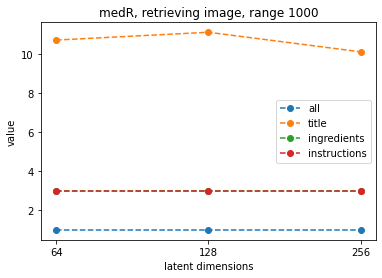

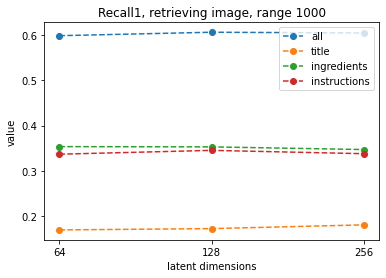

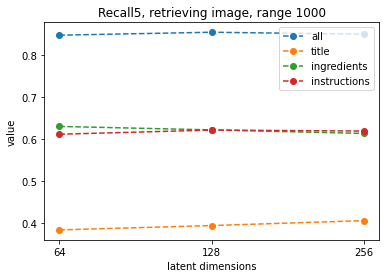

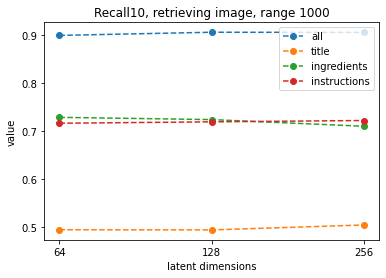

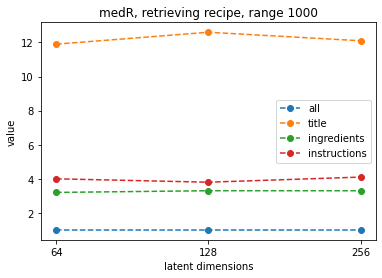

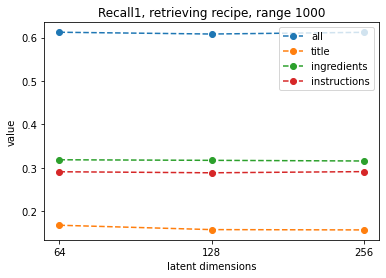

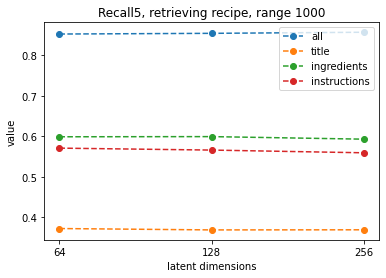

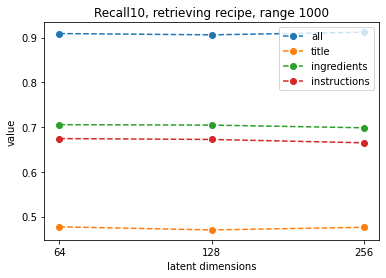

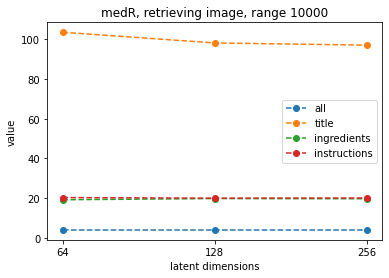

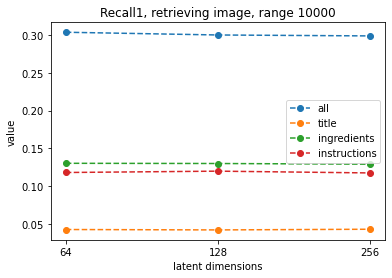

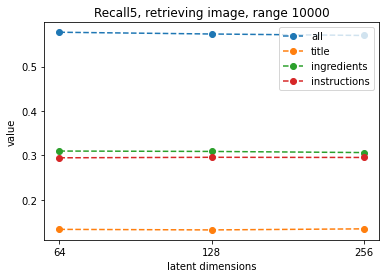

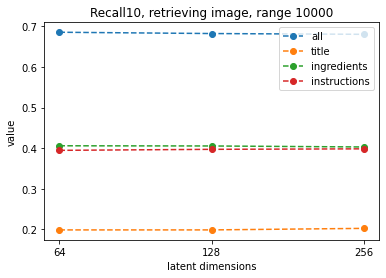

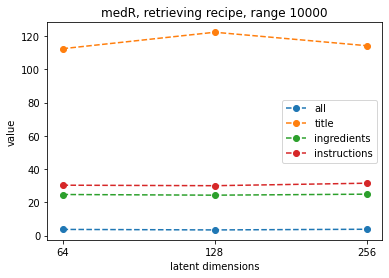

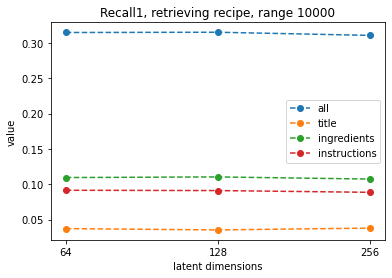

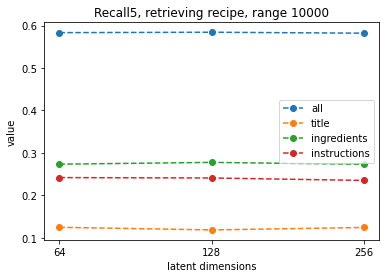

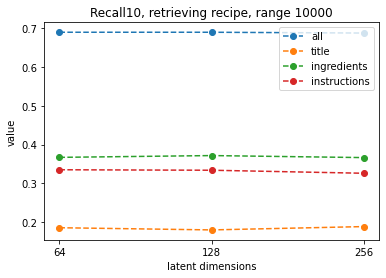

In [50]:
for retrieved_range in [1000, 10000]:
    for retrieved_type in ['image', 'recipe']:
        for metric_name in ['medR', 'Recall1', 'Recall5', 'Recall10']:
            create_plot(retrieved_type, retrieved_range, metric_name, all_metrics)
            plt.show()

## MSE Loss

### Validating

In [44]:
for part in parts:
    text_pkl_path = os.path.join(pkl_path, f'{part}_embeddings_test.pkl')
    image_pkl_path = os.path.join(pkl_path, 'embeddings_test1.pkl')
    val_set = EmbeddingDataset(image_path=image_pkl_path, text_path=text_pkl_path, part=part)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=512, shuffle=False)

    for latent_size in latent_sizes:
        print(f'Validating {part}, {latent_size}')
        dir_name = f'notebook_latent_{latent_size}_{part}_mse'
        ckpt_path = os.path.join(model_dir, dir_name, 'model.pt')
        print('Loading model')
        ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer = load_retrieval_model(ckpt_path, device)
        txt_encoder = nn.DataParallel(txt_encoder)
        img_encoder = nn.DataParallel(img_encoder)
        for retrieved_type in ['image', 'recipe']:
            for retrieved_range in [1000, 10000]:
                args.retrieved_type = retrieved_type
                args.retrieved_range = retrieved_range
                medR, recalls = validate(args, val_loader, txt_encoder, img_encoder, device)
                metrics_save_path = os.path.join(save_dir, f'{latent_size}_{part}_{retrieved_range}_{retrieved_type}_metrics_mse.csv')
                write_metrics_to_file(medR, recalls, metrics_save_path)
                
            # Making space    
            for fpath in glob('./*.pkl'):
                os.remove(fpath)


Validating all, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_all_mse/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 37.63it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=22.5019s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 31.74it/s]


=>retrieved_range=10000, MedR=4.0000(0.0000), time=131.3241s
Writing metrics to file
val


100%|██████████| 119/119 [00:04<00:00, 27.68it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=28.0206s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 38.52it/s]


=>retrieved_range=10000, MedR=3.7000(0.4583), time=119.8507s
Writing metrics to file
Validating all, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_all_mse/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 40.60it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=2.8707s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 35.12it/s]


=>retrieved_range=10000, MedR=4.0000(0.0000), time=100.5892s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 33.80it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8078s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 49.79it/s]


=>retrieved_range=10000, MedR=3.8000(0.4000), time=98.4492s
Writing metrics to file
Validating all, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_all_mse/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 41.57it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=1.8334s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 50.42it/s]


=>retrieved_range=10000, MedR=4.0000(0.0000), time=104.2141s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 46.46it/s]


=>retrieved_range=1000, MedR=1.0000(0.0000), time=22.4609s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.72it/s]


=>retrieved_range=10000, MedR=3.5000(0.5000), time=120.2602s
Writing metrics to file
Validating title, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_title_mse/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 32.42it/s]


=>retrieved_range=1000, MedR=10.6000(0.8000), time=24.3989s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 40.47it/s]


=>retrieved_range=10000, MedR=97.2000(2.7129), time=116.4537s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 34.12it/s]


=>retrieved_range=1000, MedR=13.3000(0.9000), time=2.3560s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 45.18it/s]


=>retrieved_range=10000, MedR=115.6000(1.8547), time=98.1372s
Writing metrics to file
Validating title, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_title_mse/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 39.64it/s]


=>retrieved_range=1000, MedR=10.4000(0.8000), time=2.3628s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.09it/s]


=>retrieved_range=10000, MedR=96.2000(3.3106), time=98.4182s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 37.63it/s]


=>retrieved_range=1000, MedR=12.5000(1.0247), time=1.8080s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 49.91it/s]


=>retrieved_range=10000, MedR=117.2000(2.5612), time=98.4419s
Writing metrics to file
Validating title, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_title_mse/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 47.90it/s]


=>retrieved_range=1000, MedR=10.2000(0.8718), time=28.0688s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 38.27it/s]


=>retrieved_range=10000, MedR=94.1000(2.7731), time=127.8619s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 32.18it/s]


=>retrieved_range=1000, MedR=12.6000(1.2806), time=14.5827s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.62it/s]


=>retrieved_range=10000, MedR=117.6000(2.2450), time=101.7232s
Writing metrics to file
Validating ingredients, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_ingredients_mse/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 35.77it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5565s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 43.31it/s]


=>retrieved_range=10000, MedR=19.4000(0.4899), time=101.2013s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.30it/s]


=>retrieved_range=1000, MedR=3.1000(0.3000), time=2.1092s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 42.90it/s]


=>retrieved_range=10000, MedR=23.8000(0.7483), time=99.2158s
Writing metrics to file
Validating ingredients, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_ingredients_mse/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 48.01it/s]


=>retrieved_range=1000, MedR=2.9000(0.3000), time=1.7778s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 50.66it/s]


=>retrieved_range=10000, MedR=19.6000(0.4899), time=97.4232s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 37.04it/s]


=>retrieved_range=1000, MedR=3.4000(0.4899), time=17.6398s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 49.79it/s]


=>retrieved_range=10000, MedR=24.7000(0.4583), time=125.3318s
Writing metrics to file
Validating ingredients, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_ingredients_mse/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 31.21it/s]


=>retrieved_range=1000, MedR=2.8000(0.4000), time=19.0786s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 35.25it/s]


=>retrieved_range=10000, MedR=19.7000(0.6403), time=100.1693s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 33.40it/s]


=>retrieved_range=1000, MedR=3.5000(0.5000), time=3.0480s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 38.18it/s]


=>retrieved_range=10000, MedR=25.2000(0.4000), time=99.1190s
Writing metrics to file
Validating instructions, 64
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_64_instructions_mse/model.pt
val


100%|██████████| 119/119 [00:03<00:00, 36.89it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.0707s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 31.65it/s]


=>retrieved_range=10000, MedR=19.8000(0.6000), time=97.5823s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.42it/s]


=>retrieved_range=1000, MedR=4.0000(0.0000), time=2.2835s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 42.73it/s]


=>retrieved_range=10000, MedR=31.8000(0.7483), time=100.3429s
Writing metrics to file
Validating instructions, 128
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_128_instructions_mse/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 47.70it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=22.2844s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.01it/s]


=>retrieved_range=10000, MedR=20.4000(0.4899), time=118.3019s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 34.29it/s]


=>retrieved_range=1000, MedR=4.1000(0.5385), time=16.1944s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 41.68it/s]


=>retrieved_range=10000, MedR=31.8000(0.7483), time=98.6655s
Writing metrics to file
Validating instructions, 256
Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_instructions_mse/model.pt
val


100%|██████████| 119/119 [00:02<00:00, 41.13it/s]


=>retrieved_range=1000, MedR=3.0000(0.0000), time=2.5270s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 42.33it/s]


=>retrieved_range=10000, MedR=20.0000(0.6325), time=102.4982s
Writing metrics to file
val


100%|██████████| 119/119 [00:02<00:00, 40.24it/s]


=>retrieved_range=1000, MedR=4.0000(0.0000), time=2.3961s
Writing metrics to file
val


100%|██████████| 119/119 [00:03<00:00, 36.80it/s]


=>retrieved_range=10000, MedR=30.6000(0.6633), time=100.3872s
Writing metrics to file


### Extracting metrics

In [51]:
all_metrics_mse = {}
for part in parts:
    for latent_size in latent_sizes:
        for retrieved_type in ['image', 'recipe']:
            for retrieved_range in [1000, 10000]:
                metrics_save_path = os.path.join(save_dir, f'{latent_size}_{part}_{retrieved_range}_{retrieved_type}_metrics_mse.csv')
                metrics = read_metrics_from_file(metrics_save_path)
                if retrieved_type not in all_metrics_mse:
                    all_metrics_mse[retrieved_type] = {}
                if retrieved_range not in all_metrics_mse[retrieved_type]:
                    all_metrics_mse[retrieved_type][retrieved_range] = {}
                if part not in all_metrics_mse[retrieved_type][retrieved_range]:
                    all_metrics_mse[retrieved_type][retrieved_range][part] = defaultdict(list)

                for k, v in metrics.items():
                    all_metrics_mse[retrieved_type][retrieved_range][part][k].append(v)



### Plotting all metrics

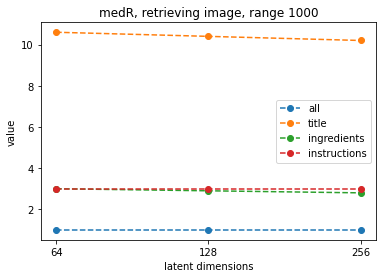

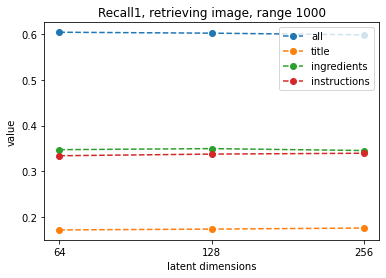

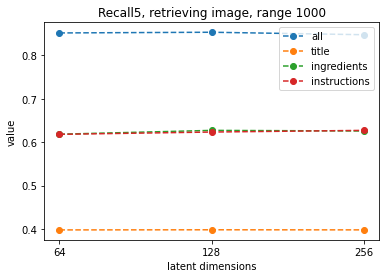

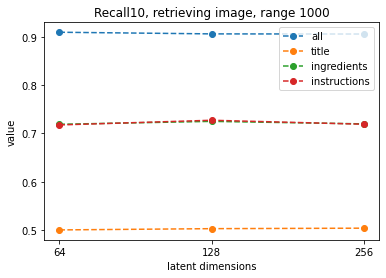

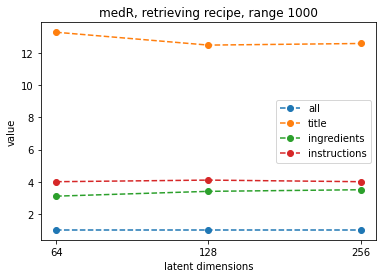

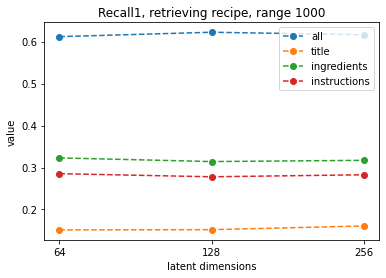

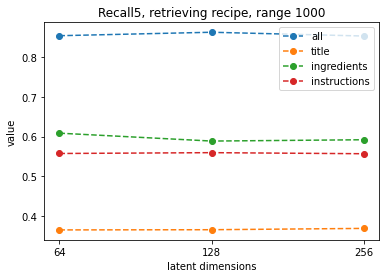

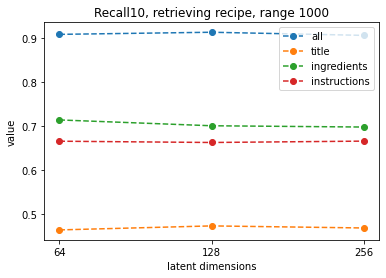

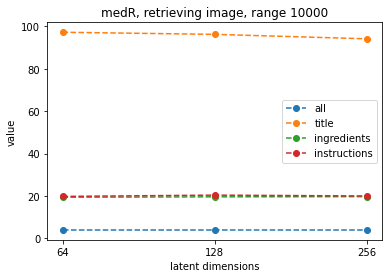

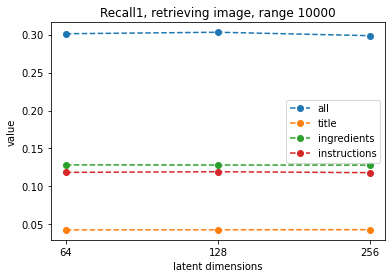

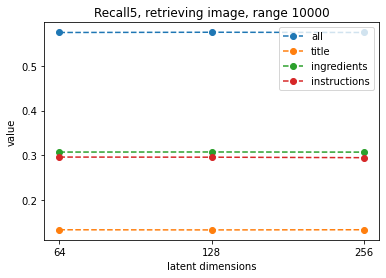

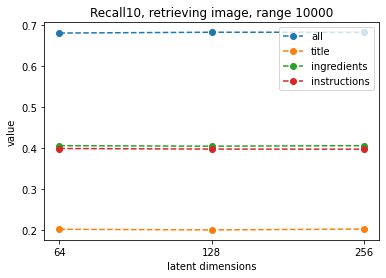

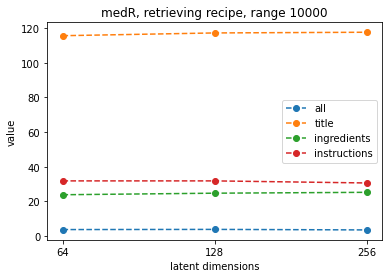

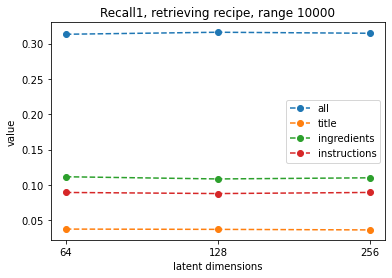

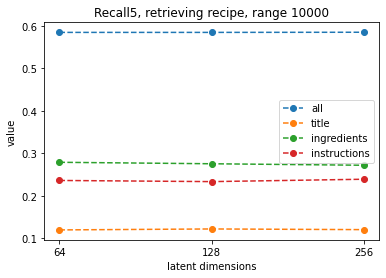

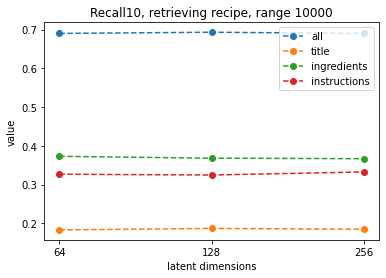

In [52]:
for retrieved_range in [1000, 10000]:
    for retrieved_type in ['image', 'recipe']:
        for metric_name in ['medR', 'Recall1', 'Recall5', 'Recall10']:
            create_plot(retrieved_type, retrieved_range, metric_name, all_metrics_mse)
            plt.show()

## Generating embeddings in latent space

### Helper functions

In [106]:
@torch.no_grad()
def generate_embeddings(img_loader, txt_loader, txt_encoder, img_encoder, device):
    txt_encoder.eval()
    img_encoder.eval()
    txt_outputs = []
    img_outputs = []
    for txt, img in tqdm(zip(txt_loader, img_loader)):
        txt_output = txt_encoder(txt[0].to(device))
        img_output = img_encoder(img[0].to(device))
        txt_outputs.append(txt_output.detach().cpu())
        img_outputs.append(img_output.detach().cpu())

    txt_outputs = torch.cat(txt_outputs, dim=0).numpy()
    img_outputs = torch.cat(img_outputs, dim=0).numpy()
    return txt_outputs, img_outputs


### Getting data from different types of recipes

In [100]:
with open('./muffin_ids.txt') as f:
    muffin_ids = [x.strip() for x in f.read().split('\n') if x.strip()]

with open('./salad_ids.txt') as f:
    salad_ids = [x.strip() for x in f.read().split('\n') if x.strip()]

image_inputs, text_inputs, labels = val_set.read_pickle(os.path.join(pkl_path, 'embeddings_train1.pkl'))
id_to_ind = {label:i for i, label in enumerate(labels)}

muffin_text = list()
muffin_image = list()
salad_text = list()
salad_image = list()

# Fetch image and text corresponding embeddings for muffin and salad.
ignored_muffin_ids = 0
for muffin_id in muffin_ids:
    try:
        muffin_text.append(text_inputs[id_to_ind[muffin_id]])
        muffin_image.append(image_inputs[id_to_ind[muffin_id]])
    except:
        ignored_muffin_ids += 1

print('Total muffin ids', len(muffin_ids), 'Ignored:', ignored_muffin_ids)

ignored_salad_ids = 0
for salad_id in salad_ids:
    try:
        salad_text.append(text_inputs[id_to_ind[salad_id]])
        salad_image.append(image_inputs[id_to_ind[salad_id]])
    except:
        ignored_salad_ids += 1

print('Total salad ids', len(salad_ids), 'Ignored:', ignored_salad_ids)

Total muffin ids 4312 Ignored: 0
Total salad ids 17210 Ignored: 0


### Creating datasets and dataloaders

In [112]:
batch_size = 1024
num_points = 100

muffin_image_dataset = TensorDataset(torch.tensor(muffin_image)[:num_points])
muffin_text_dataset = TensorDataset(torch.tensor(muffin_text)[:num_points])
salad_image_dataset = TensorDataset(torch.tensor(salad_image)[:num_points])
salad_text_dataset = TensorDataset(torch.tensor(salad_text)[:num_points])

muffin_image_dataloader = DataLoader(muffin_image_dataset, batch_size=1024)
muffin_text_dataloader = DataLoader(muffin_text_dataset, batch_size=1024)
salad_image_dataloader = DataLoader(salad_image_dataset, batch_size=1024)
salad_text_dataloader = DataLoader(salad_text_dataset, batch_size=1024)


### Triplet loss

In [124]:
dir_name = f'notebook_latent_256_all'
ckpt_path = os.path.join(model_dir, dir_name, 'model.pt')
print('Loading model')
ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer = load_retrieval_model(ckpt_path, device)
txt_encoder = nn.DataParallel(txt_encoder)
img_encoder = nn.DataParallel(img_encoder)

muffin_txt_outputs, muffin_img_outputs = generate_embeddings(muffin_image_dataloader, muffin_text_dataloader, txt_encoder, img_encoder, device)
salad_txt_outputs, salad_img_outputs = generate_embeddings(salad_image_dataloader, salad_text_dataloader, txt_encoder, img_encoder, device)

Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_all/model.pt


1it [00:00, 37.03it/s]
1it [00:00, 39.88it/s]


### Running t-SNE

In [125]:
tsne_input = np.vstack([muffin_txt_outputs, muffin_img_outputs, salad_txt_outputs, salad_img_outputs])
tsne_input.shape

(400, 256)

In [126]:
tsne = TSNE(perplexity=150, n_jobs=-1)
tsne_output = tsne.fit_transform(tsne_input)

/common/home/as3503/.conda/envs/stylegan3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/common/home/as3503/.conda/envs/stylegan3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


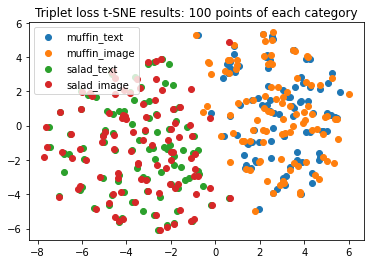

In [127]:
output_labels = [0] * num_points + [1] * num_points + [2] * num_points + [3] * num_points
legends = ['muffin_text', 'muffin_image', 'salad_text', 'salad_image']

# Final scatter plot
for i in range(0, 4 * num_points, num_points):
    plt.scatter(tsne_output[i:i + num_points, 0], tsne_output[i:i + num_points, 1],
                label=legends[i // num_points])
plt.legend()
plt.title('Triplet loss t-SNE results: 100 points of each category')
plt.show()

### MSE

In [119]:
dir_name = f'notebook_latent_256_all_mse'
ckpt_path = os.path.join(model_dir, dir_name, 'model.pt')
print('Loading model')
ckpt_args, epoch_start, txt_encoder, img_encoder, optimizer = load_retrieval_model(ckpt_path, device)
txt_encoder = nn.DataParallel(txt_encoder)
img_encoder = nn.DataParallel(img_encoder)

muffin_txt_outputs, muffin_img_outputs = generate_embeddings(muffin_image_dataloader, muffin_text_dataloader, txt_encoder, img_encoder, device)
salad_txt_outputs, salad_img_outputs = generate_embeddings(salad_image_dataloader, salad_text_dataloader, txt_encoder, img_encoder, device)

Loading model
load retrieval model from /common/home/as3503/as3503/courses/cs536/final_project/Classical Multi-View Representation Learning/saved_models/notebook_latent_256_all_mse/model.pt


1it [00:00, 36.14it/s]
1it [00:00, 42.83it/s]


### Running t-SNE

In [120]:
tsne_input = np.vstack([muffin_txt_outputs, muffin_img_outputs, salad_txt_outputs, salad_img_outputs])
tsne_input.shape

(400, 256)

In [121]:
tsne = TSNE(perplexity=150, n_jobs=-1)
tsne_output = tsne.fit_transform(tsne_input)

/common/home/as3503/.conda/envs/stylegan3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/common/home/as3503/.conda/envs/stylegan3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


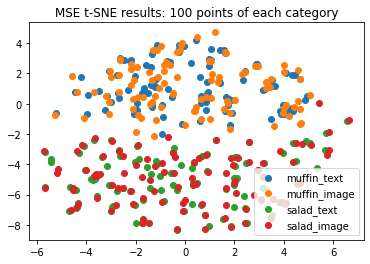

In [123]:
output_labels = [0] * num_points + [1] * num_points + [2] * num_points + [3] * num_points
legends = ['muffin_text', 'muffin_image', 'salad_text', 'salad_image']

# Final scatter plot
for i in range(0, 4 * num_points, num_points):
    plt.scatter(tsne_output[i:i + num_points, 0], tsne_output[i:i + num_points, 1],
                label=legends[i // num_points])
plt.legend()
plt.title('MSE t-SNE results: 100 points of each category')
plt.show()